# **ENTRENAMIENTO DEL MODELOS DE DETECCIÓN DE VIOLENCIA**

In [ ]:
import os
os.kill(os.getpid(), 9)  # Reinicia el entorno

In [ ]:
# Entrenamiento de TimeSformer con Transfer Learning para clasificación de violencia escolar
# - Compatible con YOLOv8 y DeepSort
# - Metodología del Capítulo 11 y buenas prácticas profesionales

# Instalar dependencias
!pip install transformers torch torchvision opencv-python scikit-learn tqdm matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
# Importar librerías
import os
import cv2
import torch
import logging
import pickle
from datetime import datetime
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from transformers import AutoImageProcessor, TimesformerForVideoClassification
from transformers import get_linear_schedule_with_warmup

In [ ]:
from torch.cuda.amp import autocast, GradScaler


In [2]:
from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# Configurar logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler("training.log"),
        logging.StreamHandler()
    ]
)

# Definir rutas
BASE_PATH = "/content/drive/MyDrive/Proyecto IA-3/violence_school_project/"
DATA_PATH = os.path.join(BASE_PATH, "timesformer_data")
MODEL_PATH = os.path.join(BASE_PATH, "models/timesformer")
RUN_ID = datetime.now().strftime("%Y%m%d_%H%M%S")
RUN_PATH = os.path.join(MODEL_PATH, f"run_{RUN_ID}")

# Validar rutas
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"DATA_PATH no encontrado: {DATA_PATH}")
if not os.path.exists(RUN_PATH):
    os.makedirs(RUN_PATH, exist_ok=True)
    logging.info(f"Creado directorio RUN_PATH: {RUN_PATH}")

# Clase para cargar y preprocesar videos
class ViolenceVideoDataset(Dataset):
    def __init__(self, video_dir, split="train", num_frames=8, image_processor=None):
        self.video_dir = os.path.join(video_dir, split)
        self.num_frames = num_frames
        self.image_processor = image_processor
        self.videos = []
        self.labels = []

        # Cargar videos y etiquetas
        for label, class_name in enumerate(["no_violence", "violence"]):
            class_dir = os.path.join(self.video_dir, class_name)
            if not os.path.exists(class_dir):
                logging.warning(f"No se encontró la carpeta: {class_dir}")
                continue
            for video_file in os.listdir(class_dir):
                if video_file.endswith((".mp4", ".avi")):
                    self.videos.append(os.path.join(class_dir, video_file))
                    self.labels.append(label)

        logging.info(f"Cargados {len(self.videos)} videos para {split}")

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        video_path = self.videos[idx]
        label = self.labels[idx]

        # Cargar video
        cap = cv2.VideoCapture(video_path)
        frames = []
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if frame_count < self.num_frames:
            # Repetir el último frame si el video es demasiado corto
            while len(frames) < self.num_frames:
                ret, frame = cap.read()
                if not ret:
                    if frames:
                        frames.append(frames[-1])  # Repetir último frame
                    else:
                        cap.release()
                        logging.warning(f"Video {video_path} no tiene frames válidos")
                        return None, None
                else:
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frames.append(frame)
        else:
            # Submuestreo uniforme
            step = max(1, frame_count // self.num_frames)
            frame_indices = list(range(0, frame_count, step))[:self.num_frames]
            for idx in frame_indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
                ret, frame = cap.read()
                if not ret:
                    continue
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame)

        cap.release()

        if len(frames) != self.num_frames:
            logging.warning(f"No se pudieron cargar {self.num_frames} frames de {video_path}")
            return None, None

        # Preprocesar frames con AutoImageProcessor
        inputs = self.image_processor(frames, return_tensors="pt")
        video_tensor = inputs["pixel_values"].squeeze(0)  # (T, C, H, W) - Corregido: squeeze(0) en lugar de squeeze(1)
        if video_tensor.shape != (self.num_frames, 3, 224, 224):
            logging.warning(f"Dimensiones incorrectas para {video_path}: {video_tensor.shape}")
            return None, None
        label_tensor = torch.LongTensor([label])

        return video_tensor, label_tensor

In [ ]:
image_processor = AutoImageProcessor.from_pretrained("facebook/timesformer-base-finetuned-k400")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/412 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
# Cargar el procesador de imágenes y el modelo preentrenado
image_processor = AutoImageProcessor.from_pretrained("facebook/timesformer-base-finetuned-k400")
model = TimesformerForVideoClassification.from_pretrained(
    "facebook/timesformer-base-finetuned-k400",
    num_labels=2,  # Violencia/No violencia
    ignore_mismatched_sizes=True
)


# Congelar capas excepto el clasificador para Transfer Learning
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True
logging.info("Congeladas todas las capas excepto el clasificador")

# Mover modelo a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
logging.info(f"Modelo cargado en dispositivo: {device}")
print(f"Modelo cargado en dispositivo: {device}")


Some weights of TimesformerForVideoClassification were not initialized from the model checkpoint at facebook/timesformer-base-finetuned-k400 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modelo cargado en dispositivo: cuda


In [ ]:
# Liberar memoria de la GPU
torch.cuda.empty_cache()

In [ ]:
# Configurar dataset y dataloaders
print("Cargando datasets...")
train_dataset = ViolenceVideoDataset(DATA_PATH, split="train", num_frames=8, image_processor=image_processor)
val_dataset = ViolenceVideoDataset(DATA_PATH, split="val", num_frames=8, image_processor=image_processor)
test_dataset = ViolenceVideoDataset(DATA_PATH, split="test", num_frames=8, image_processor=image_processor)

# Filtrar None en los datasets
train_data = [(frames, label) for frames, label in train_dataset if frames is not None]
val_data = [(frames, label) for frames, label in val_dataset if frames is not None]
test_data = [(frames, label) for frames, label in test_dataset if frames is not None]


# Configurar DataLoaders con num_workers=0 para evitar problemas de multiprocessing
train_loader = DataLoader(train_data, batch_size=1, shuffle=True, num_workers=0)
val_loader = DataLoader(val_data, batch_size=1, shuffle=False, num_workers=0)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False, num_workers=0)

print(f"Number of valid training samples: {len(train_data)}")
print(f"Number of valid validation samples: {len(val_data)}")
print(f"Number of valid test samples: {len(test_data)}")

Cargando datasets...
Number of valid training samples: 2100
Number of valid validation samples: 600
Number of valid test samples: 300


In [ ]:
# Configurar optimizador y scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
num_epochs = 10
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),  # 10% de warmup
    num_training_steps=total_steps
)

# Configurar mixed precision training
scaler = torch.amp.GradScaler('cuda')  # Corregido: torch.amp.GradScaler('cuda')

# Listas para almacenar métricas
train_metrics = {
    "losses": [],
    "accuracies": [],
    "precisions": [],
    "recalls": [],
    "f1_scores": []
}
val_metrics = {
    "losses": [],
    "accuracies": [],
    "precisions": [],
    "recalls": [],
    "f1_scores": []
}

# Entrenamiento con early stopping
best_val_loss = float("inf")
patience = 3
early_stop_counter = 0

for epoch in range(num_epochs):
    logging.info(f"Época {epoch + 1}/{num_epochs}")

    # Entrenamiento
    model.train()
    train_loss = 0
    train_preds, train_labels = [], []
    for batch in tqdm(train_loader, desc="Entrenamiento"):
        videos, labels = batch
        print(f"Shape of videos: {videos.shape}")  # Para depuración
        videos = videos.to(device)  # (B, T, C, H, W)
        labels = labels.to(device)  # (B,) - No usamos squeeze() para mantener la dimensión

        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):  # Corregido: torch.amp.autocast('cuda')
            outputs = model(pixel_values=videos, labels=labels)
            loss = outputs.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        train_loss += loss.item()
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())  # Ahora labels es un tensor 1D, compatible con extend

    train_loss /= len(train_loader)
    train_accuracy = accuracy_score(train_labels, train_preds)
    train_precision = precision_score(train_labels, train_preds, average="binary")
    train_recall = recall_score(train_labels, train_preds, average="binary")
    train_f1 = f1_score(train_labels, train_preds, average="binary")

    train_metrics["losses"].append(train_loss)
    train_metrics["accuracies"].append(train_accuracy)
    train_metrics["precisions"].append(train_precision)
    train_metrics["recalls"].append(train_recall)
    train_metrics["f1_scores"].append(train_f1)

    # Validación
    model.eval()
    val_loss = 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validación"):
            videos, labels = batch
            videos = videos.to(device)
            labels = labels.to(device)  # (B,) - No usamos squeeze()

            with torch.amp.autocast('cuda'):  # Corregido: torch.amp.autocast('cuda')
                outputs = model(pixel_values=videos, labels=labels)
                loss = outputs.loss
            val_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_precision = precision_score(val_labels, val_preds, average="binary")
    val_recall = recall_score(val_labels, val_preds, average="binary")
    val_f1 = f1_score(val_labels, val_preds, average="binary")

    val_metrics["losses"].append(val_loss)
    val_metrics["accuracies"].append(val_accuracy)
    val_metrics["precisions"].append(val_precision)
    val_metrics["recalls"].append(val_recall)
    val_metrics["f1_scores"].append(val_f1)

    # Logging de métricas
    logging.info(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}")
    logging.info(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")

    # Guardar checkpoint si mejora
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint_path = os.path.join(RUN_PATH, "best_timesformer_transfer.pt")
        model.save_pretrained(checkpoint_path)
        logging.info(f"Mejor modelo guardado en: {checkpoint_path}")
        print(f"Mejor modelo guardado en: {checkpoint_path}")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            logging.info("Early stopping activado.")
            print("Early stopping activado.")
            break

    # Guardar checkpoint intermedio cada 5 épocas
    if (epoch + 1) % 5 == 0:
        checkpoint_path = os.path.join(RUN_PATH, f"timesformer_transfer_epoch_{epoch + 1}.pt")
        model.save_pretrained(checkpoint_path)
        logging.info(f"Checkpoint intermedio guardado: {checkpoint_path}")
        print(f"Checkpoint intermedio guardado: {checkpoint_path}")


Entrenamiento:   0%|          | 2/2100 [00:00<02:06, 16.61it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   0%|          | 7/2100 [00:00<02:00, 17.36it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|          | 13/2100 [00:00<01:36, 21.68it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|          | 19/2100 [00:00<01:29, 23.36it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|          | 22/2100 [00:01<01:26, 23.92it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|▏         | 28/2100 [00:01<01:25, 24.34it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 34/2100 [00:01<01:24, 24.44it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 37/2100 [00:01<01:26, 23.79it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 43/2100 [00:01<01:23, 24.65it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 49/2100 [00:02<01:22, 24.87it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 55/2100 [00:02<01:21, 24.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 61/2100 [00:02<01:22, 24.83it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 67/2100 [00:02<01:22, 24.79it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 73/2100 [00:03<01:21, 24.84it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▎         | 76/2100 [00:03<01:21, 24.84it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▍         | 82/2100 [00:03<01:21, 24.76it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▍         | 85/2100 [00:03<01:21, 24.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▍         | 91/2100 [00:03<01:21, 24.64it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▍         | 97/2100 [00:04<01:20, 24.73it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▍         | 100/2100 [00:04<01:20, 24.75it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▌         | 106/2100 [00:04<01:20, 24.71it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▌         | 112/2100 [00:04<01:20, 24.62it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▌         | 115/2100 [00:04<01:20, 24.62it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▌         | 121/2100 [00:05<01:20, 24.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▌         | 127/2100 [00:05<01:19, 24.73it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▌         | 130/2100 [00:05<01:19, 24.67it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▋         | 136/2100 [00:05<01:19, 24.61it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 142/2100 [00:05<01:19, 24.67it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 148/2100 [00:06<01:18, 24.72it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 151/2100 [00:06<01:18, 24.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 157/2100 [00:06<01:18, 24.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 160/2100 [00:06<01:18, 24.62it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 166/2100 [00:06<01:18, 24.65it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 172/2100 [00:07<01:18, 24.72it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 175/2100 [00:07<01:17, 24.72it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▊         | 181/2100 [00:07<01:17, 24.66it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▉         | 187/2100 [00:07<01:17, 24.61it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▉         | 190/2100 [00:07<01:17, 24.59it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▉         | 196/2100 [00:08<01:17, 24.71it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|▉         | 202/2100 [00:08<01:16, 24.75it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|▉         | 208/2100 [00:08<01:16, 24.71it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|█         | 214/2100 [00:08<01:16, 24.74it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|█         | 217/2100 [00:08<01:16, 24.70it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█         | 223/2100 [00:09<01:16, 24.70it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█         | 226/2100 [00:09<01:16, 24.65it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█         | 232/2100 [00:09<01:15, 24.58it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█▏        | 238/2100 [00:09<01:15, 24.67it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█▏        | 241/2100 [00:09<01:15, 24.65it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 247/2100 [00:10<01:14, 24.71it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 253/2100 [00:10<01:15, 24.36it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 256/2100 [00:10<01:15, 24.56it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 262/2100 [00:10<01:14, 24.66it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 268/2100 [00:10<01:14, 24.73it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 271/2100 [00:11<01:14, 24.70it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 277/2100 [00:11<01:14, 24.60it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 283/2100 [00:11<01:13, 24.70it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▎        | 286/2100 [00:11<01:13, 24.68it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▍        | 292/2100 [00:11<01:13, 24.70it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▍        | 298/2100 [00:12<01:13, 24.60it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▍        | 301/2100 [00:12<01:13, 24.54it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▍        | 307/2100 [00:12<01:12, 24.60it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▍        | 313/2100 [00:12<01:12, 24.63it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▌        | 316/2100 [00:12<01:12, 24.61it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▌        | 322/2100 [00:13<01:12, 24.62it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▌        | 328/2100 [00:13<01:11, 24.63it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▌        | 331/2100 [00:13<01:11, 24.58it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▌        | 337/2100 [00:13<01:11, 24.62it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▋        | 343/2100 [00:14<01:11, 24.61it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 349/2100 [00:14<01:10, 24.74it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 352/2100 [00:14<01:10, 24.68it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 358/2100 [00:14<01:10, 24.62it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 361/2100 [00:14<01:10, 24.65it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 367/2100 [00:15<01:10, 24.70it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 373/2100 [00:15<01:09, 24.70it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 379/2100 [00:15<01:09, 24.59it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 382/2100 [00:15<01:09, 24.60it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 388/2100 [00:15<01:09, 24.64it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▉        | 394/2100 [00:16<01:09, 24.67it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▉        | 397/2100 [00:16<01:09, 24.68it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▉        | 403/2100 [00:16<01:09, 24.59it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▉        | 409/2100 [00:16<01:08, 24.63it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|█▉        | 412/2100 [00:16<01:08, 24.65it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|█▉        | 418/2100 [00:17<01:08, 24.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|██        | 424/2100 [00:17<01:07, 24.67it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|██        | 427/2100 [00:17<01:07, 24.61it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██        | 433/2100 [00:17<01:07, 24.63it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██        | 439/2100 [00:17<01:07, 24.68it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██        | 442/2100 [00:18<01:07, 24.68it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██▏       | 448/2100 [00:18<01:06, 24.68it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 454/2100 [00:18<01:06, 24.65it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 457/2100 [00:18<01:06, 24.67it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 463/2100 [00:18<01:06, 24.71it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 469/2100 [00:19<01:06, 24.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 472/2100 [00:19<01:05, 24.68it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 478/2100 [00:19<01:05, 24.61it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 484/2100 [00:19<01:05, 24.64it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 487/2100 [00:19<01:05, 24.64it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 493/2100 [00:20<01:05, 24.68it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▍       | 499/2100 [00:20<01:05, 24.60it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▍       | 502/2100 [00:20<01:04, 24.64it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▍       | 508/2100 [00:20<01:04, 24.60it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▍       | 514/2100 [00:20<01:04, 24.58it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▍       | 517/2100 [00:21<01:04, 24.64it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▍       | 523/2100 [00:21<01:04, 24.59it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▌       | 529/2100 [00:21<01:03, 24.67it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▌       | 532/2100 [00:21<01:03, 24.61it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▌       | 538/2100 [00:21<01:03, 24.70it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▌       | 544/2100 [00:22<01:03, 24.70it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▌       | 547/2100 [00:22<01:03, 24.64it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▋       | 553/2100 [00:22<01:02, 24.63it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 559/2100 [00:22<01:02, 24.61it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 562/2100 [00:22<01:02, 24.65it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 568/2100 [00:23<01:02, 24.67it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 574/2100 [00:23<01:01, 24.66it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 577/2100 [00:23<01:01, 24.61it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 583/2100 [00:23<01:01, 24.59it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 589/2100 [00:24<01:01, 24.70it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 592/2100 [00:24<01:01, 24.63it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 598/2100 [00:24<01:00, 24.64it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▉       | 604/2100 [00:24<01:00, 24.64it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▉       | 607/2100 [00:24<01:00, 24.64it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▉       | 613/2100 [00:24<01:00, 24.76it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▉       | 619/2100 [00:25<01:00, 24.66it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|██▉       | 625/2100 [00:25<00:59, 24.67it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|██▉       | 628/2100 [00:25<00:59, 24.61it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|███       | 634/2100 [00:25<00:59, 24.63it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|███       | 640/2100 [00:26<00:58, 24.75it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███       | 643/2100 [00:26<00:58, 24.79it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███       | 649/2100 [00:26<00:58, 24.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███       | 655/2100 [00:26<00:58, 24.74it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███▏      | 658/2100 [00:26<00:58, 24.74it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 664/2100 [00:27<00:58, 24.70it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 670/2100 [00:27<00:57, 24.68it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 676/2100 [00:27<00:57, 24.75it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 679/2100 [00:27<00:57, 24.66it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 685/2100 [00:27<00:57, 24.70it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 691/2100 [00:28<00:56, 24.75it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 694/2100 [00:28<00:56, 24.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 700/2100 [00:28<00:56, 24.78it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▎      | 706/2100 [00:28<00:56, 24.70it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▍      | 709/2100 [00:28<00:56, 24.67it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▍      | 715/2100 [00:29<00:56, 24.68it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▍      | 721/2100 [00:29<00:55, 24.67it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▍      | 724/2100 [00:29<00:55, 24.66it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▍      | 730/2100 [00:29<00:55, 24.65it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▌      | 736/2100 [00:29<00:55, 24.63it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▌      | 742/2100 [00:30<00:54, 24.76it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▌      | 745/2100 [00:30<00:54, 24.76it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▌      | 751/2100 [00:30<00:54, 24.66it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▌      | 754/2100 [00:30<00:54, 24.62it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▌      | 760/2100 [00:30<00:54, 24.71it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▋      | 766/2100 [00:31<00:54, 24.65it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 769/2100 [00:31<00:53, 24.68it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 775/2100 [00:31<00:53, 24.64it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 781/2100 [00:31<00:53, 24.64it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 784/2100 [00:31<00:53, 24.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 790/2100 [00:32<00:53, 24.68it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 796/2100 [00:32<00:52, 24.71it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 802/2100 [00:32<00:52, 24.77it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 805/2100 [00:32<00:52, 24.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▊      | 811/2100 [00:33<00:52, 24.64it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▉      | 817/2100 [00:33<00:51, 24.77it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▉      | 820/2100 [00:33<00:51, 24.72it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▉      | 826/2100 [00:33<00:51, 24.73it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|███▉      | 832/2100 [00:33<00:51, 24.72it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|███▉      | 835/2100 [00:33<00:51, 24.66it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|████      | 841/2100 [00:34<00:50, 24.70it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|████      | 847/2100 [00:34<00:50, 24.76it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|████      | 850/2100 [00:34<00:50, 24.70it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████      | 856/2100 [00:34<00:50, 24.67it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████      | 859/2100 [00:34<00:50, 24.59it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████      | 865/2100 [00:35<00:49, 24.70it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████▏     | 871/2100 [00:35<00:49, 24.68it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 874/2100 [00:35<00:49, 24.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 880/2100 [00:35<00:49, 24.73it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 886/2100 [00:36<00:49, 24.66it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 889/2100 [00:36<00:49, 24.64it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 895/2100 [00:36<00:48, 24.73it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 901/2100 [00:36<00:48, 24.71it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 907/2100 [00:36<00:48, 24.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 913/2100 [00:37<00:48, 24.72it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▎     | 916/2100 [00:37<00:47, 24.68it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▍     | 922/2100 [00:37<00:47, 24.65it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▍     | 925/2100 [00:37<00:47, 24.71it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▍     | 931/2100 [00:37<00:47, 24.67it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▍     | 937/2100 [00:38<00:47, 24.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▍     | 940/2100 [00:38<00:47, 24.65it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▌     | 946/2100 [00:38<00:46, 24.68it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▌     | 952/2100 [00:38<00:46, 24.64it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▌     | 955/2100 [00:38<00:46, 24.64it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▌     | 961/2100 [00:39<00:46, 24.70it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▌     | 967/2100 [00:39<00:45, 24.81it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▌     | 970/2100 [00:39<00:45, 24.72it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▋     | 976/2100 [00:39<00:45, 24.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 982/2100 [00:39<00:45, 24.65it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 988/2100 [00:40<00:45, 24.71it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 991/2100 [00:40<00:44, 24.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 997/2100 [00:40<00:44, 24.70it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1000/2100 [00:40<00:44, 24.66it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1006/2100 [00:40<00:44, 24.63it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1012/2100 [00:41<00:44, 24.68it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1015/2100 [00:41<00:43, 24.68it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▊     | 1021/2100 [00:41<00:43, 24.72it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▉     | 1027/2100 [00:41<00:43, 24.70it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▉     | 1033/2100 [00:42<00:43, 24.75it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▉     | 1036/2100 [00:42<00:43, 24.74it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|████▉     | 1042/2100 [00:42<00:42, 24.67it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|████▉     | 1045/2100 [00:42<00:42, 24.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|█████     | 1051/2100 [00:42<00:42, 24.71it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|█████     | 1057/2100 [00:42<00:42, 24.76it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|█████     | 1060/2100 [00:43<00:42, 24.73it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████     | 1066/2100 [00:43<00:41, 24.65it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████     | 1072/2100 [00:43<00:41, 24.70it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████     | 1075/2100 [00:43<00:41, 24.70it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████▏    | 1081/2100 [00:43<00:41, 24.66it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1087/2100 [00:44<00:41, 24.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1090/2100 [00:44<00:40, 24.71it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1096/2100 [00:44<00:40, 24.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1102/2100 [00:44<00:40, 24.65it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1105/2100 [00:44<00:40, 24.65it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1111/2100 [00:45<00:40, 24.68it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1117/2100 [00:45<00:39, 24.75it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1123/2100 [00:45<00:39, 24.72it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▎    | 1126/2100 [00:45<00:39, 24.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▍    | 1132/2100 [00:46<00:39, 24.74it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▍    | 1138/2100 [00:46<00:39, 24.66it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▍    | 1144/2100 [00:46<00:38, 24.71it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▍    | 1147/2100 [00:46<00:38, 24.75it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▍    | 1153/2100 [00:46<00:38, 24.73it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▌    | 1156/2100 [00:46<00:38, 24.71it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▌    | 1162/2100 [00:47<00:37, 24.70it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▌    | 1168/2100 [00:47<00:37, 24.65it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▌    | 1171/2100 [00:47<00:37, 24.62it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▌    | 1177/2100 [00:47<00:37, 24.64it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▋    | 1183/2100 [00:48<00:37, 24.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▋    | 1186/2100 [00:48<00:37, 24.66it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1192/2100 [00:48<00:36, 24.70it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1198/2100 [00:48<00:36, 24.71it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1201/2100 [00:48<00:36, 24.72it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1207/2100 [00:49<00:36, 24.74it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1213/2100 [00:49<00:35, 24.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1216/2100 [00:49<00:35, 24.63it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1222/2100 [00:49<00:35, 24.63it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1228/2100 [00:49<00:35, 24.66it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▊    | 1231/2100 [00:50<00:35, 24.66it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▉    | 1237/2100 [00:50<00:34, 24.66it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▉    | 1243/2100 [00:50<00:34, 24.76it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▉    | 1249/2100 [00:50<00:34, 24.66it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|█████▉    | 1255/2100 [00:51<00:34, 24.76it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|█████▉    | 1258/2100 [00:51<00:34, 24.68it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|██████    | 1264/2100 [00:51<00:33, 24.71it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|██████    | 1267/2100 [00:51<00:33, 24.68it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████    | 1273/2100 [00:51<00:33, 24.66it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████    | 1279/2100 [00:51<00:33, 24.72it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████    | 1282/2100 [00:52<00:33, 24.66it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████▏   | 1288/2100 [00:52<00:32, 24.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1294/2100 [00:52<00:32, 24.60it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1297/2100 [00:52<00:32, 24.68it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1303/2100 [00:52<00:32, 24.65it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1309/2100 [00:53<00:31, 24.73it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1315/2100 [00:53<00:31, 24.79it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1318/2100 [00:53<00:31, 24.73it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1324/2100 [00:53<00:31, 24.76it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1327/2100 [00:53<00:31, 24.73it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1333/2100 [00:54<00:31, 24.62it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▍   | 1339/2100 [00:54<00:30, 24.60it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▍   | 1342/2100 [00:54<00:30, 24.64it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▍   | 1348/2100 [00:54<00:30, 24.64it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▍   | 1354/2100 [00:55<00:30, 24.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▍   | 1360/2100 [00:55<00:29, 24.73it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▍   | 1363/2100 [00:55<00:29, 24.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▌   | 1369/2100 [00:55<00:29, 24.63it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▌   | 1372/2100 [00:55<00:29, 24.63it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▌   | 1378/2100 [00:55<00:29, 24.61it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▌   | 1384/2100 [00:56<00:29, 24.56it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▌   | 1387/2100 [00:56<00:29, 24.40it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▋   | 1393/2100 [00:56<00:29, 24.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1399/2100 [00:56<00:28, 24.28it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1402/2100 [00:56<00:28, 24.36it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1408/2100 [00:57<00:28, 24.43it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1414/2100 [00:57<00:27, 24.61it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1417/2100 [00:57<00:27, 24.60it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1423/2100 [00:57<00:27, 24.67it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1429/2100 [00:58<00:27, 24.68it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1432/2100 [00:58<00:27, 24.67it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1438/2100 [00:58<00:26, 24.68it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▉   | 1444/2100 [00:58<00:26, 24.70it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▉   | 1447/2100 [00:58<00:26, 24.76it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▉   | 1453/2100 [00:59<00:26, 24.71it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▉   | 1459/2100 [00:59<00:25, 24.67it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|██████▉   | 1462/2100 [00:59<00:25, 24.71it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|██████▉   | 1468/2100 [00:59<00:25, 24.68it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|███████   | 1474/2100 [00:59<00:25, 24.66it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|███████   | 1477/2100 [01:00<00:25, 24.71it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████   | 1483/2100 [01:00<00:24, 24.70it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████   | 1489/2100 [01:00<00:24, 24.71it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████   | 1492/2100 [01:00<00:24, 24.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████▏  | 1498/2100 [01:00<00:24, 24.68it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1504/2100 [01:01<00:24, 24.60it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1507/2100 [01:01<00:24, 24.54it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1513/2100 [01:01<00:24, 24.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1519/2100 [01:01<00:24, 24.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1522/2100 [01:01<00:23, 24.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1528/2100 [01:02<00:23, 24.39it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1534/2100 [01:02<00:23, 24.55it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1537/2100 [01:02<00:22, 24.56it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1543/2100 [01:02<00:22, 24.63it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▍  | 1549/2100 [01:02<00:22, 24.63it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▍  | 1552/2100 [01:03<00:22, 24.67it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▍  | 1558/2100 [01:03<00:21, 24.70it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▍  | 1564/2100 [01:03<00:21, 24.72it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▍  | 1567/2100 [01:03<00:21, 24.68it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▍  | 1573/2100 [01:03<00:21, 24.67it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▌  | 1579/2100 [01:04<00:21, 24.72it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▌  | 1582/2100 [01:04<00:20, 24.73it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▌  | 1588/2100 [01:04<00:20, 24.68it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▌  | 1594/2100 [01:04<00:20, 24.72it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▌  | 1597/2100 [01:04<00:20, 24.65it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▋  | 1603/2100 [01:05<00:20, 24.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1609/2100 [01:05<00:19, 24.71it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1615/2100 [01:05<00:19, 24.75it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1618/2100 [01:05<00:19, 24.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1624/2100 [01:05<00:19, 24.70it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1630/2100 [01:06<00:18, 24.76it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1633/2100 [01:06<00:18, 24.75it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1639/2100 [01:06<00:18, 24.66it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1645/2100 [01:06<00:18, 24.73it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1648/2100 [01:06<00:18, 24.68it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▉  | 1654/2100 [01:07<00:18, 24.74it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▉  | 1660/2100 [01:07<00:17, 24.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▉  | 1666/2100 [01:07<00:17, 24.61it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▉  | 1669/2100 [01:07<00:17, 24.63it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|███████▉  | 1675/2100 [01:08<00:17, 24.65it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|████████  | 1681/2100 [01:08<00:16, 24.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|████████  | 1684/2100 [01:08<00:16, 24.70it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|████████  | 1690/2100 [01:08<00:16, 24.65it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████  | 1696/2100 [01:08<00:16, 24.66it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████  | 1699/2100 [01:09<00:16, 24.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████  | 1705/2100 [01:09<00:16, 24.67it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████▏ | 1711/2100 [01:09<00:15, 24.64it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1714/2100 [01:09<00:15, 24.63it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1720/2100 [01:09<00:15, 24.65it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1726/2100 [01:10<00:15, 24.56it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1729/2100 [01:10<00:15, 24.33it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1735/2100 [01:10<00:15, 24.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1741/2100 [01:10<00:14, 24.32it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1744/2100 [01:10<00:14, 24.37it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1750/2100 [01:11<00:14, 24.46it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▎ | 1756/2100 [01:11<00:14, 24.43it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▍ | 1759/2100 [01:11<00:13, 24.56it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▍ | 1765/2100 [01:11<00:13, 24.56it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▍ | 1771/2100 [01:11<00:13, 24.60it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▍ | 1774/2100 [01:12<00:13, 24.53it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▍ | 1780/2100 [01:12<00:13, 24.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▌ | 1786/2100 [01:12<00:13, 24.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▌ | 1789/2100 [01:12<00:12, 24.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▌ | 1795/2100 [01:12<00:12, 24.29it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▌ | 1801/2100 [01:13<00:12, 24.45it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▌ | 1804/2100 [01:13<00:12, 24.51it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▌ | 1810/2100 [01:13<00:11, 24.39it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▋ | 1816/2100 [01:13<00:11, 24.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1819/2100 [01:13<00:11, 24.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1825/2100 [01:14<00:11, 24.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1831/2100 [01:14<00:11, 24.37it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1834/2100 [01:14<00:10, 24.39it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1840/2100 [01:14<00:10, 24.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1846/2100 [01:15<00:10, 24.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1849/2100 [01:15<00:10, 24.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1855/2100 [01:15<00:10, 24.36it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▊ | 1861/2100 [01:15<00:09, 24.57it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▉ | 1867/2100 [01:15<00:09, 24.61it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▉ | 1870/2100 [01:16<00:09, 24.55it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▉ | 1876/2100 [01:16<00:09, 24.49it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|████████▉ | 1882/2100 [01:16<00:09, 24.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|████████▉ | 1885/2100 [01:16<00:08, 24.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|█████████ | 1891/2100 [01:16<00:08, 24.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|█████████ | 1897/2100 [01:17<00:08, 24.31it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|█████████ | 1900/2100 [01:17<00:08, 24.38it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████ | 1906/2100 [01:17<00:07, 24.42it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████ | 1912/2100 [01:17<00:07, 24.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████ | 1915/2100 [01:17<00:07, 24.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████▏| 1921/2100 [01:18<00:07, 24.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1927/2100 [01:18<00:07, 24.35it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1930/2100 [01:18<00:06, 24.33it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1936/2100 [01:18<00:06, 24.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1942/2100 [01:19<00:06, 24.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1945/2100 [01:19<00:06, 24.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1951/2100 [01:19<00:06, 24.30it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1957/2100 [01:19<00:05, 24.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1960/2100 [01:19<00:05, 24.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▎| 1966/2100 [01:20<00:05, 24.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▍| 1972/2100 [01:20<00:05, 24.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▍| 1975/2100 [01:20<00:05, 24.32it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▍| 1981/2100 [01:20<00:04, 24.28it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▍| 1987/2100 [01:20<00:04, 24.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▍| 1990/2100 [01:21<00:04, 23.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▌| 1996/2100 [01:21<00:04, 24.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▌| 2002/2100 [01:21<00:04, 23.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▌| 2005/2100 [01:21<00:03, 24.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▌| 2011/2100 [01:21<00:03, 24.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▌| 2017/2100 [01:22<00:03, 24.29it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▌| 2020/2100 [01:22<00:03, 24.35it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▋| 2026/2100 [01:22<00:03, 24.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2032/2100 [01:22<00:02, 24.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2035/2100 [01:22<00:02, 24.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2041/2100 [01:23<00:02, 24.23it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2047/2100 [01:23<00:02, 24.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2050/2100 [01:23<00:02, 24.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2056/2100 [01:23<00:01, 24.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2062/2100 [01:23<00:01, 24.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2065/2100 [01:24<00:01, 24.25it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▊| 2071/2100 [01:24<00:01, 24.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▉| 2077/2100 [01:24<00:00, 23.93it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▉| 2080/2100 [01:24<00:00, 23.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▉| 2086/2100 [01:24<00:00, 24.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento: 100%|█████████▉| 2092/2100 [01:25<00:00, 23.88it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento: 100%|█████████▉| 2095/2100 [01:25<00:00, 23.93it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento: 100%|██████████| 2100/2100 [01:25<00:00, 24.54it/s]


Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Validación: 100%|██████████| 600/600 [00:24<00:00, 24.34it/s]


Train Loss: 0.5399, Train Accuracy: 0.7262, Train Precision: 0.6958, Train Recall: 0.8038, Train F1: 0.7459
Val Loss: 0.3456, Val Accuracy: 0.8733, Val Precision: 0.9088, Val Recall: 0.8300, Val F1: 0.8676
Mejor modelo guardado en: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_20250407_115035/best_timesformer_transfer.pt


Entrenamiento:   0%|          | 3/2100 [00:00<01:25, 24.61it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   0%|          | 9/2100 [00:00<01:26, 24.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|          | 12/2100 [00:00<01:26, 24.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|          | 18/2100 [00:00<01:27, 23.87it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|          | 24/2100 [00:01<01:28, 23.38it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|▏         | 27/2100 [00:01<01:28, 23.54it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 33/2100 [00:01<01:26, 23.80it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 39/2100 [00:01<01:25, 24.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 42/2100 [00:01<01:26, 23.85it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 48/2100 [00:02<01:26, 23.77it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 54/2100 [00:02<01:26, 23.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 57/2100 [00:02<01:26, 23.68it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 63/2100 [00:02<01:25, 23.94it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 69/2100 [00:02<01:25, 23.74it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 72/2100 [00:03<01:25, 23.81it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▎         | 78/2100 [00:03<01:24, 24.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▍         | 84/2100 [00:03<01:24, 23.77it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▍         | 87/2100 [00:03<01:24, 23.76it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▍         | 93/2100 [00:03<01:23, 24.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▍         | 99/2100 [00:04<01:24, 23.81it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▍         | 102/2100 [00:04<01:23, 23.84it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▌         | 108/2100 [00:04<01:22, 24.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▌         | 114/2100 [00:04<01:23, 23.76it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▌         | 117/2100 [00:04<01:23, 23.84it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▌         | 123/2100 [00:05<01:22, 24.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▌         | 129/2100 [00:05<01:22, 23.80it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▋         | 132/2100 [00:05<01:22, 23.80it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 138/2100 [00:05<01:22, 23.90it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 144/2100 [00:06<01:22, 23.72it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 147/2100 [00:06<01:22, 23.81it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 153/2100 [00:06<01:22, 23.62it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 159/2100 [00:06<01:21, 23.79it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 162/2100 [00:06<01:21, 23.72it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 168/2100 [00:07<01:21, 23.66it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 174/2100 [00:07<01:21, 23.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 177/2100 [00:07<01:21, 23.61it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▊         | 183/2100 [00:07<01:20, 23.76it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▉         | 189/2100 [00:07<01:20, 23.64it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▉         | 192/2100 [00:08<01:20, 23.73it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▉         | 198/2100 [00:08<01:19, 23.87it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|▉         | 204/2100 [00:08<01:19, 23.73it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|▉         | 207/2100 [00:08<01:19, 23.86it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|█         | 213/2100 [00:08<01:19, 23.70it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|█         | 219/2100 [00:09<01:19, 23.78it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█         | 222/2100 [00:09<01:18, 23.89it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█         | 228/2100 [00:09<01:19, 23.68it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█         | 234/2100 [00:09<01:18, 23.86it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█▏        | 237/2100 [00:09<01:18, 23.77it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 243/2100 [00:10<01:18, 23.63it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 249/2100 [00:10<01:18, 23.70it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 252/2100 [00:10<01:18, 23.57it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 258/2100 [00:10<01:17, 23.79it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 264/2100 [00:11<01:18, 23.51it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 267/2100 [00:11<01:17, 23.65it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 273/2100 [00:11<01:17, 23.64it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 279/2100 [00:11<01:16, 23.74it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 282/2100 [00:11<01:16, 23.90it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▎        | 288/2100 [00:12<01:16, 23.63it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▍        | 294/2100 [00:12<01:15, 23.93it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▍        | 297/2100 [00:12<01:15, 24.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▍        | 303/2100 [00:12<01:15, 23.73it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▍        | 309/2100 [00:12<01:14, 23.93it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▍        | 312/2100 [00:13<01:14, 23.94it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▌        | 318/2100 [00:13<01:14, 23.78it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▌        | 324/2100 [00:13<01:14, 23.91it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▌        | 327/2100 [00:13<01:14, 23.72it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▌        | 333/2100 [00:13<01:14, 23.76it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▌        | 339/2100 [00:14<01:14, 23.68it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▋        | 342/2100 [00:14<01:14, 23.67it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 348/2100 [00:14<01:13, 23.86it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 354/2100 [00:14<01:14, 23.59it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 357/2100 [00:15<01:13, 23.76it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 363/2100 [00:15<01:13, 23.74it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 369/2100 [00:15<01:13, 23.70it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 372/2100 [00:15<01:12, 23.86it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 378/2100 [00:15<01:12, 23.64it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 384/2100 [00:16<01:11, 23.87it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 387/2100 [00:16<01:11, 23.93it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▊        | 393/2100 [00:16<01:12, 23.64it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▉        | 399/2100 [00:16<01:11, 23.85it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▉        | 402/2100 [00:16<01:11, 23.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▉        | 408/2100 [00:17<01:11, 23.77it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|█▉        | 414/2100 [00:17<01:11, 23.71it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|█▉        | 417/2100 [00:17<01:11, 23.61it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|██        | 423/2100 [00:17<01:10, 23.80it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|██        | 429/2100 [00:18<01:10, 23.62it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██        | 432/2100 [00:18<01:10, 23.74it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██        | 438/2100 [00:18<01:10, 23.68it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██        | 444/2100 [00:18<01:09, 23.77it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██▏       | 447/2100 [00:18<01:09, 23.84it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 453/2100 [00:19<01:09, 23.62it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 459/2100 [00:19<01:08, 23.91it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 462/2100 [00:19<01:08, 23.85it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 468/2100 [00:19<01:08, 23.70it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 474/2100 [00:19<01:08, 23.75it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 477/2100 [00:20<01:08, 23.63it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 483/2100 [00:20<01:07, 23.89it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 489/2100 [00:20<01:08, 23.58it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 492/2100 [00:20<01:08, 23.62it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▎       | 498/2100 [00:20<01:08, 23.49it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▍       | 504/2100 [00:21<01:07, 23.72it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▍       | 507/2100 [00:21<01:07, 23.66it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▍       | 513/2100 [00:21<01:07, 23.55it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▍       | 519/2100 [00:21<01:07, 23.43it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▍       | 522/2100 [00:21<01:07, 23.49it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▌       | 528/2100 [00:22<01:06, 23.56it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▌       | 534/2100 [00:22<01:06, 23.66it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▌       | 537/2100 [00:22<01:05, 23.68it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▌       | 543/2100 [00:22<01:06, 23.50it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▌       | 549/2100 [00:23<01:06, 23.44it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▋       | 552/2100 [00:23<01:05, 23.46it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 558/2100 [00:23<01:04, 23.74it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 564/2100 [00:23<01:05, 23.60it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 567/2100 [00:23<01:04, 23.73it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 573/2100 [00:24<01:04, 23.61it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 579/2100 [00:24<01:03, 23.80it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 582/2100 [00:24<01:03, 23.83it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 588/2100 [00:24<01:03, 23.68it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 594/2100 [00:25<01:03, 23.89it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 597/2100 [00:25<01:03, 23.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▊       | 603/2100 [00:25<01:02, 23.79it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▉       | 609/2100 [00:25<01:02, 23.82it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▉       | 612/2100 [00:25<01:02, 23.64it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▉       | 618/2100 [00:26<01:01, 23.90it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|██▉       | 624/2100 [00:26<01:02, 23.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|██▉       | 627/2100 [00:26<01:02, 23.67it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|███       | 633/2100 [00:26<01:01, 23.91it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|███       | 639/2100 [00:26<01:01, 23.62it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███       | 642/2100 [00:27<01:01, 23.80it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███       | 648/2100 [00:27<01:01, 23.77it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███       | 654/2100 [00:27<01:00, 23.71it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███▏      | 657/2100 [00:27<01:00, 23.85it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 663/2100 [00:27<01:00, 23.58it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 669/2100 [00:28<00:59, 23.87it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 672/2100 [00:28<01:00, 23.74it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 678/2100 [00:28<00:59, 23.70it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 684/2100 [00:28<00:59, 23.72it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 687/2100 [00:28<00:59, 23.58it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 693/2100 [00:29<00:58, 23.88it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 699/2100 [00:29<00:59, 23.66it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 702/2100 [00:29<00:59, 23.67it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▎      | 708/2100 [00:29<00:58, 23.92it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▍      | 714/2100 [00:30<00:58, 23.58it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▍      | 717/2100 [00:30<00:58, 23.67it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▍      | 723/2100 [00:30<00:58, 23.56it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▍      | 729/2100 [00:30<00:57, 23.71it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▍      | 732/2100 [00:30<00:57, 23.75it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▌      | 738/2100 [00:31<00:57, 23.55it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▌      | 744/2100 [00:31<00:57, 23.67it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▌      | 747/2100 [00:31<00:57, 23.56it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▌      | 753/2100 [00:31<00:56, 23.80it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▌      | 759/2100 [00:31<00:56, 23.67it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▋      | 762/2100 [00:32<00:56, 23.59it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 768/2100 [00:32<00:55, 23.83it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 774/2100 [00:32<00:56, 23.60it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 777/2100 [00:32<00:55, 23.73it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 783/2100 [00:32<00:55, 23.64it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 789/2100 [00:33<00:55, 23.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 792/2100 [00:33<00:55, 23.70it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 798/2100 [00:33<00:55, 23.56it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 804/2100 [00:33<00:54, 23.66it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 807/2100 [00:33<00:55, 23.47it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▊      | 813/2100 [00:34<00:54, 23.51it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▉      | 819/2100 [00:34<00:54, 23.50it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▉      | 822/2100 [00:34<00:54, 23.60it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▉      | 828/2100 [00:34<00:54, 23.54it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|███▉      | 834/2100 [00:35<00:53, 23.60it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|███▉      | 837/2100 [00:35<00:53, 23.46it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|████      | 843/2100 [00:35<00:53, 23.64it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|████      | 849/2100 [00:35<00:53, 23.56it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████      | 852/2100 [00:35<00:52, 23.60it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████      | 858/2100 [00:36<00:53, 23.42it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████      | 864/2100 [00:36<00:52, 23.70it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████▏     | 867/2100 [00:36<00:52, 23.63it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 873/2100 [00:36<00:51, 23.61it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 879/2100 [00:37<00:51, 23.64it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 882/2100 [00:37<00:51, 23.56it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 888/2100 [00:37<00:50, 23.81it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 894/2100 [00:37<00:51, 23.56it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 897/2100 [00:37<00:50, 23.66it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 903/2100 [00:38<00:50, 23.60it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 909/2100 [00:38<00:50, 23.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 912/2100 [00:38<00:49, 23.77it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▎     | 918/2100 [00:38<00:50, 23.55it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▍     | 924/2100 [00:38<00:49, 23.66it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▍     | 927/2100 [00:39<00:49, 23.50it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▍     | 933/2100 [00:39<00:49, 23.67it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▍     | 939/2100 [00:39<00:49, 23.50it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▍     | 942/2100 [00:39<00:49, 23.57it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▌     | 948/2100 [00:39<00:48, 23.53it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▌     | 954/2100 [00:40<00:48, 23.62it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▌     | 957/2100 [00:40<00:48, 23.34it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▌     | 963/2100 [00:40<00:49, 22.92it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▌     | 969/2100 [00:40<00:48, 23.33it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▋     | 972/2100 [00:41<00:48, 23.31it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 978/2100 [00:41<00:47, 23.51it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 984/2100 [00:41<00:47, 23.42it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 987/2100 [00:41<00:47, 23.58it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 993/2100 [00:41<00:47, 23.48it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 999/2100 [00:42<00:46, 23.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1002/2100 [00:42<00:46, 23.52it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1008/2100 [00:42<00:46, 23.55it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1014/2100 [00:42<00:46, 23.44it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1017/2100 [00:42<00:45, 23.54it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▊     | 1023/2100 [00:43<00:46, 23.40it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▉     | 1029/2100 [00:43<00:45, 23.48it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▉     | 1032/2100 [00:43<00:45, 23.34it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▉     | 1038/2100 [00:43<00:47, 22.38it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|████▉     | 1044/2100 [00:44<00:46, 22.84it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|████▉     | 1047/2100 [00:44<00:45, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|█████     | 1053/2100 [00:44<00:44, 23.29it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|█████     | 1059/2100 [00:44<00:44, 23.28it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████     | 1062/2100 [00:44<00:44, 23.32it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████     | 1068/2100 [00:45<00:43, 23.54it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████     | 1074/2100 [00:45<00:43, 23.58it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████▏    | 1077/2100 [00:45<00:43, 23.65it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1083/2100 [00:45<00:43, 23.39it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1089/2100 [00:46<00:43, 23.42it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1092/2100 [00:46<00:42, 23.48it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1098/2100 [00:46<00:42, 23.58it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1104/2100 [00:46<00:42, 23.50it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1107/2100 [00:46<00:42, 23.56it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1113/2100 [00:47<00:42, 23.40it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1119/2100 [00:47<00:41, 23.45it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1122/2100 [00:47<00:41, 23.46it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▎    | 1128/2100 [00:47<00:41, 23.57it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▍    | 1134/2100 [00:47<00:40, 23.58it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▍    | 1137/2100 [00:48<00:40, 23.76it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▍    | 1143/2100 [00:48<00:40, 23.50it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▍    | 1149/2100 [00:48<00:40, 23.63it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▍    | 1152/2100 [00:48<00:40, 23.50it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▌    | 1158/2100 [00:48<00:39, 23.66it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▌    | 1164/2100 [00:49<00:39, 23.53it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▌    | 1167/2100 [00:49<00:39, 23.60it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▌    | 1173/2100 [00:49<00:39, 23.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▌    | 1179/2100 [00:49<00:39, 23.58it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▋    | 1182/2100 [00:49<00:38, 23.72it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1188/2100 [00:50<00:38, 23.51it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1194/2100 [00:50<00:38, 23.59it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1197/2100 [00:50<00:38, 23.52it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1203/2100 [00:50<00:37, 23.65it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1209/2100 [00:51<00:37, 23.54it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1212/2100 [00:51<00:37, 23.62it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1218/2100 [00:51<00:37, 23.49it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1224/2100 [00:51<00:37, 23.58it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1227/2100 [00:51<00:37, 23.51it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▊    | 1233/2100 [00:52<00:36, 23.67it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▉    | 1239/2100 [00:52<00:36, 23.48it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▉    | 1242/2100 [00:52<00:36, 23.55it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▉    | 1248/2100 [00:52<00:36, 23.49it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|█████▉    | 1254/2100 [00:53<00:35, 23.62it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|█████▉    | 1257/2100 [00:53<00:35, 23.52it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|██████    | 1263/2100 [00:53<00:35, 23.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|██████    | 1269/2100 [00:53<00:35, 23.49it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████    | 1272/2100 [00:53<00:35, 23.57it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████    | 1278/2100 [00:54<00:34, 23.56it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████    | 1284/2100 [00:54<00:34, 23.69it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████▏   | 1287/2100 [00:54<00:34, 23.65it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1293/2100 [00:54<00:34, 23.56it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1299/2100 [00:54<00:34, 23.39it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1302/2100 [00:55<00:33, 23.51it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1308/2100 [00:55<00:33, 23.47it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1314/2100 [00:55<00:33, 23.62it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1317/2100 [00:55<00:33, 23.52it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1323/2100 [00:55<00:32, 23.60it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1329/2100 [00:56<00:32, 23.42it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1332/2100 [00:56<00:32, 23.47it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▎   | 1338/2100 [00:56<00:32, 23.37it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▍   | 1344/2100 [00:56<00:32, 23.55it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▍   | 1347/2100 [00:56<00:32, 23.33it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▍   | 1353/2100 [00:57<00:31, 23.54it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▍   | 1359/2100 [00:57<00:31, 23.42it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▍   | 1362/2100 [00:57<00:31, 23.50it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▌   | 1368/2100 [00:57<00:31, 23.46it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▌   | 1374/2100 [00:58<00:30, 23.49it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▌   | 1377/2100 [00:58<00:30, 23.41it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▌   | 1383/2100 [00:58<00:30, 23.38it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▌   | 1389/2100 [00:58<00:30, 23.53it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▋   | 1392/2100 [00:58<00:30, 23.43it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1398/2100 [00:59<00:29, 23.51it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1404/2100 [00:59<00:29, 23.38it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1407/2100 [00:59<00:29, 23.52it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1413/2100 [00:59<00:29, 23.37it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1419/2100 [01:00<00:29, 23.37it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1422/2100 [01:00<00:29, 23.32it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1428/2100 [01:00<00:28, 23.42it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1434/2100 [01:00<00:28, 23.47it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1437/2100 [01:00<00:28, 23.46it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▊   | 1443/2100 [01:01<00:27, 23.50it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▉   | 1449/2100 [01:01<00:27, 23.48it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▉   | 1452/2100 [01:01<00:27, 23.53it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▉   | 1458/2100 [01:01<00:27, 23.53it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|██████▉   | 1464/2100 [01:01<00:26, 23.58it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|██████▉   | 1467/2100 [01:02<00:26, 23.60it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|███████   | 1473/2100 [01:02<00:26, 23.51it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|███████   | 1479/2100 [01:02<00:26, 23.46it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████   | 1482/2100 [01:02<00:26, 23.48it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████   | 1488/2100 [01:02<00:26, 23.42it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████   | 1494/2100 [01:03<00:25, 23.59it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████▏  | 1497/2100 [01:03<00:25, 23.49it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1503/2100 [01:03<00:25, 23.57it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1509/2100 [01:03<00:25, 23.45it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1512/2100 [01:03<00:25, 23.43it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1518/2100 [01:04<00:24, 23.38it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1524/2100 [01:04<00:24, 23.61it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1527/2100 [01:04<00:24, 23.50it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1533/2100 [01:04<00:24, 23.53it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1539/2100 [01:05<00:23, 23.45it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1542/2100 [01:05<00:23, 23.56it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▎  | 1548/2100 [01:05<00:23, 23.45it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▍  | 1554/2100 [01:05<00:23, 23.53it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▍  | 1557/2100 [01:05<00:23, 23.41it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▍  | 1563/2100 [01:06<00:22, 23.54it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▍  | 1569/2100 [01:06<00:22, 23.46it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▍  | 1572/2100 [01:06<00:22, 23.43it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▌  | 1578/2100 [01:06<00:22, 23.46it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▌  | 1584/2100 [01:07<00:22, 23.35it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▌  | 1587/2100 [01:07<00:21, 23.46it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▌  | 1593/2100 [01:07<00:21, 23.32it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▌  | 1599/2100 [01:07<00:21, 23.54it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▋  | 1602/2100 [01:07<00:21, 23.45it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1608/2100 [01:08<00:20, 23.58it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1614/2100 [01:08<00:20, 23.45it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1617/2100 [01:08<00:20, 23.52it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1623/2100 [01:08<00:20, 23.42it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1629/2100 [01:08<00:20, 23.43it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1632/2100 [01:09<00:20, 23.38it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1638/2100 [01:09<00:19, 23.40it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1644/2100 [01:09<00:19, 23.48it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1647/2100 [01:09<00:19, 23.32it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▊  | 1653/2100 [01:10<00:19, 23.48it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▉  | 1659/2100 [01:10<00:18, 23.30it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▉  | 1662/2100 [01:10<00:18, 23.39it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▉  | 1668/2100 [01:10<00:18, 23.33it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|███████▉  | 1674/2100 [01:10<00:18, 23.29it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|███████▉  | 1677/2100 [01:11<00:18, 23.36it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|████████  | 1683/2100 [01:11<00:17, 23.23it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|████████  | 1689/2100 [01:11<00:17, 23.39it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████  | 1692/2100 [01:11<00:17, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████  | 1698/2100 [01:11<00:17, 23.37it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████  | 1704/2100 [01:12<00:16, 23.43it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████▏ | 1707/2100 [01:12<00:16, 23.47it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1713/2100 [01:12<00:16, 23.43it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1719/2100 [01:12<00:16, 23.51it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1722/2100 [01:12<00:16, 23.40it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1728/2100 [01:13<00:15, 23.35it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1734/2100 [01:13<00:15, 23.49it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1737/2100 [01:13<00:15, 23.39it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1743/2100 [01:13<00:15, 23.55it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1749/2100 [01:14<00:14, 23.47it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1752/2100 [01:14<00:14, 23.51it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▎ | 1758/2100 [01:14<00:14, 23.39it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▍ | 1764/2100 [01:14<00:14, 23.50it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▍ | 1767/2100 [01:14<00:14, 23.33it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▍ | 1773/2100 [01:15<00:13, 23.49it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▍ | 1779/2100 [01:15<00:13, 23.46it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▍ | 1782/2100 [01:15<00:13, 23.55it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▌ | 1788/2100 [01:15<00:13, 23.40it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▌ | 1794/2100 [01:16<00:13, 23.38it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▌ | 1797/2100 [01:16<00:12, 23.39it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▌ | 1803/2100 [01:16<00:12, 23.37it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▌ | 1809/2100 [01:16<00:12, 23.60it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▋ | 1812/2100 [01:16<00:12, 23.48it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1818/2100 [01:17<00:11, 23.51it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1824/2100 [01:17<00:11, 23.34it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1827/2100 [01:17<00:11, 23.49it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1833/2100 [01:17<00:11, 23.39it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1839/2100 [01:17<00:11, 23.39it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1842/2100 [01:18<00:11, 23.38it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1848/2100 [01:18<00:10, 23.35it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1854/2100 [01:18<00:10, 23.53it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1857/2100 [01:18<00:10, 23.40it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▊ | 1863/2100 [01:18<00:10, 23.47it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▉ | 1869/2100 [01:19<00:09, 23.37it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▉ | 1872/2100 [01:19<00:09, 23.49it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▉ | 1878/2100 [01:19<00:09, 23.36it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|████████▉ | 1884/2100 [01:19<00:09, 23.47it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|████████▉ | 1887/2100 [01:20<00:09, 23.42it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|█████████ | 1893/2100 [01:20<00:08, 23.33it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|█████████ | 1899/2100 [01:20<00:08, 23.48it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████ | 1902/2100 [01:20<00:08, 23.44it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████ | 1908/2100 [01:20<00:08, 23.47it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████ | 1914/2100 [01:21<00:07, 23.34it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████▏| 1917/2100 [01:21<00:07, 23.43it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1923/2100 [01:21<00:07, 23.29it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1929/2100 [01:21<00:07, 23.45it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1932/2100 [01:21<00:07, 23.36it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1938/2100 [01:22<00:06, 23.38it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1944/2100 [01:22<00:06, 23.39it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1947/2100 [01:22<00:06, 23.28it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1953/2100 [01:22<00:06, 23.45it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1959/2100 [01:23<00:06, 23.32it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1962/2100 [01:23<00:05, 23.47it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▎| 1968/2100 [01:23<00:05, 23.34it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▍| 1974/2100 [01:23<00:05, 23.42it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▍| 1977/2100 [01:23<00:05, 23.34it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▍| 1983/2100 [01:24<00:05, 23.36it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▍| 1989/2100 [01:24<00:04, 23.42it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▍| 1992/2100 [01:24<00:04, 23.32it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▌| 1998/2100 [01:24<00:04, 23.46it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▌| 2004/2100 [01:25<00:04, 23.39it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▌| 2007/2100 [01:25<00:03, 23.53it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▌| 2013/2100 [01:25<00:03, 23.38it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▌| 2019/2100 [01:25<00:03, 23.30it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▋| 2022/2100 [01:25<00:03, 23.39it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2028/2100 [01:26<00:03, 23.44it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2034/2100 [01:26<00:02, 23.47it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2037/2100 [01:26<00:02, 23.33it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2043/2100 [01:26<00:02, 23.47it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2049/2100 [01:26<00:02, 23.40it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2052/2100 [01:27<00:02, 23.56it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2058/2100 [01:27<00:01, 23.42it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2064/2100 [01:27<00:01, 23.29it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2067/2100 [01:27<00:01, 23.44it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▊| 2073/2100 [01:27<00:01, 23.42it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▉| 2079/2100 [01:28<00:00, 23.54it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▉| 2082/2100 [01:28<00:00, 23.36it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▉| 2088/2100 [01:28<00:00, 23.46it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento: 100%|█████████▉| 2094/2100 [01:28<00:00, 23.42it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento: 100%|█████████▉| 2097/2100 [01:28<00:00, 23.52it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Validación: 100%|██████████| 600/600 [00:25<00:00, 23.52it/s]


Train Loss: 0.2603, Train Accuracy: 0.9000, Train Precision: 0.9078, Train Recall: 0.8905, Train F1: 0.8990
Val Loss: 0.2354, Val Accuracy: 0.9100, Val Precision: 0.9184, Val Recall: 0.9000, Val F1: 0.9091
Mejor modelo guardado en: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_20250407_115035/best_timesformer_transfer.pt


Entrenamiento:   0%|          | 3/2100 [00:00<01:25, 24.58it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   0%|          | 9/2100 [00:00<01:28, 23.74it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|          | 12/2100 [00:00<01:28, 23.59it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|          | 18/2100 [00:00<01:27, 23.67it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|          | 24/2100 [00:01<01:31, 22.72it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|▏         | 27/2100 [00:01<01:30, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 33/2100 [00:01<01:29, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 39/2100 [00:01<01:28, 23.42it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 42/2100 [00:01<01:28, 23.29it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 48/2100 [00:02<01:28, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 54/2100 [00:02<01:27, 23.38it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 57/2100 [00:02<01:27, 23.32it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 63/2100 [00:02<01:27, 23.41it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 69/2100 [00:02<01:27, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 72/2100 [00:03<01:27, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▎         | 78/2100 [00:03<01:26, 23.32it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▍         | 84/2100 [00:03<01:26, 23.26it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▍         | 87/2100 [00:03<01:26, 23.25it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▍         | 93/2100 [00:03<01:26, 23.29it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▍         | 99/2100 [00:04<01:26, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▍         | 102/2100 [00:04<01:25, 23.30it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▌         | 108/2100 [00:04<01:25, 23.31it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▌         | 114/2100 [00:04<01:25, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▌         | 117/2100 [00:05<01:24, 23.34it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▌         | 123/2100 [00:05<01:24, 23.28it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▌         | 129/2100 [00:05<01:24, 23.39it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▋         | 132/2100 [00:05<01:24, 23.32it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 138/2100 [00:05<01:23, 23.36it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 144/2100 [00:06<01:23, 23.36it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 147/2100 [00:06<01:23, 23.28it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 153/2100 [00:06<01:22, 23.47it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 159/2100 [00:06<01:23, 23.35it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 162/2100 [00:06<01:22, 23.44it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 168/2100 [00:07<01:22, 23.34it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 174/2100 [00:07<01:22, 23.23it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 177/2100 [00:07<01:22, 23.34it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▊         | 183/2100 [00:07<01:22, 23.30it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▉         | 189/2100 [00:08<01:22, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▉         | 192/2100 [00:08<01:21, 23.31it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▉         | 198/2100 [00:08<01:21, 23.33it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|▉         | 204/2100 [00:08<01:20, 23.43it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|▉         | 207/2100 [00:08<01:21, 23.31it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|█         | 213/2100 [00:09<01:20, 23.37it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|█         | 219/2100 [00:09<01:20, 23.38it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█         | 222/2100 [00:09<01:20, 23.36it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█         | 228/2100 [00:09<01:20, 23.39it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█         | 234/2100 [00:10<01:20, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█▏        | 237/2100 [00:10<01:19, 23.34it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 243/2100 [00:10<01:19, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 249/2100 [00:10<01:19, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 252/2100 [00:10<01:18, 23.42it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 258/2100 [00:11<01:19, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 264/2100 [00:11<01:19, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 267/2100 [00:11<01:18, 23.25it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 273/2100 [00:11<01:18, 23.26it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 279/2100 [00:11<01:17, 23.36it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 282/2100 [00:12<01:18, 23.26it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▎        | 288/2100 [00:12<01:18, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▍        | 294/2100 [00:12<01:17, 23.40it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▍        | 297/2100 [00:12<01:17, 23.29it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▍        | 303/2100 [00:13<01:16, 23.44it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▍        | 309/2100 [00:13<01:16, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▍        | 312/2100 [00:13<01:17, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▌        | 318/2100 [00:13<01:16, 23.32it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▌        | 324/2100 [00:13<01:16, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▌        | 327/2100 [00:14<01:15, 23.35it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▌        | 333/2100 [00:14<01:15, 23.29it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▌        | 339/2100 [00:14<01:16, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▋        | 342/2100 [00:14<01:15, 23.23it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 348/2100 [00:14<01:15, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 354/2100 [00:15<01:15, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 357/2100 [00:15<01:15, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 363/2100 [00:15<01:14, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 369/2100 [00:15<01:14, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 372/2100 [00:15<01:14, 23.30it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 378/2100 [00:16<01:14, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 384/2100 [00:16<01:14, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 387/2100 [00:16<01:13, 23.35it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▊        | 393/2100 [00:16<01:13, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▉        | 399/2100 [00:17<01:12, 23.37it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▉        | 402/2100 [00:17<01:12, 23.32it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▉        | 408/2100 [00:17<01:12, 23.29it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|█▉        | 414/2100 [00:17<01:11, 23.44it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|█▉        | 417/2100 [00:17<01:12, 23.28it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|██        | 423/2100 [00:18<01:12, 23.28it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|██        | 429/2100 [00:18<01:11, 23.34it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██        | 432/2100 [00:18<01:11, 23.35it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██        | 438/2100 [00:18<01:10, 23.41it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██        | 444/2100 [00:19<01:11, 23.30it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██▏       | 447/2100 [00:19<01:10, 23.45it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 453/2100 [00:19<01:10, 23.25it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 459/2100 [00:19<01:10, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 462/2100 [00:19<01:10, 23.31it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 468/2100 [00:20<01:10, 23.23it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 474/2100 [00:20<01:10, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 477/2100 [00:20<01:09, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 483/2100 [00:20<01:09, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 489/2100 [00:21<01:09, 23.24it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 492/2100 [00:21<01:09, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▎       | 498/2100 [00:21<01:09, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▍       | 504/2100 [00:21<01:08, 23.34it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▍       | 507/2100 [00:21<01:08, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▍       | 513/2100 [00:22<01:08, 23.31it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▍       | 519/2100 [00:22<01:07, 23.40it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▍       | 522/2100 [00:22<01:07, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▌       | 528/2100 [00:22<01:07, 23.38it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▌       | 534/2100 [00:22<01:07, 23.33it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▌       | 537/2100 [00:23<01:06, 23.40it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▌       | 543/2100 [00:23<01:06, 23.38it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▌       | 549/2100 [00:23<01:06, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▋       | 552/2100 [00:23<01:06, 23.38it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 558/2100 [00:23<01:06, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 564/2100 [00:24<01:06, 23.26it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 567/2100 [00:24<01:05, 23.29it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 573/2100 [00:24<01:05, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 579/2100 [00:24<01:05, 23.30it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 582/2100 [00:24<01:05, 23.25it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 588/2100 [00:25<01:05, 23.24it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 594/2100 [00:25<01:04, 23.41it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 597/2100 [00:25<01:04, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▊       | 603/2100 [00:25<01:04, 23.29it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▉       | 609/2100 [00:26<01:03, 23.40it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▉       | 612/2100 [00:26<01:03, 23.25it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▉       | 618/2100 [00:26<01:03, 23.30it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|██▉       | 624/2100 [00:26<01:03, 23.30it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|██▉       | 627/2100 [00:26<01:03, 23.32it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|███       | 633/2100 [00:27<01:02, 23.35it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|███       | 639/2100 [00:27<01:02, 23.25it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███       | 642/2100 [00:27<01:02, 23.35it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███       | 648/2100 [00:27<01:02, 23.26it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███       | 654/2100 [00:28<01:02, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███▏      | 657/2100 [00:28<01:01, 23.28it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 663/2100 [00:28<01:01, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 669/2100 [00:28<01:01, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 672/2100 [00:28<01:01, 23.30it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 678/2100 [00:29<01:01, 23.29it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 684/2100 [00:29<01:00, 23.30it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 687/2100 [00:29<01:00, 23.35it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 693/2100 [00:29<01:00, 23.30it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 699/2100 [00:30<01:00, 23.30it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 702/2100 [00:30<01:00, 23.23it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▎      | 708/2100 [00:30<00:59, 23.24it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▍      | 714/2100 [00:30<00:59, 23.34it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▍      | 717/2100 [00:30<00:59, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▍      | 723/2100 [00:31<00:58, 23.38it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▍      | 729/2100 [00:31<00:58, 23.34it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▍      | 732/2100 [00:31<00:58, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▌      | 738/2100 [00:31<00:58, 23.34it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▌      | 744/2100 [00:31<00:58, 23.26it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▌      | 747/2100 [00:32<00:57, 23.36it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▌      | 753/2100 [00:32<00:57, 23.31it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▌      | 759/2100 [00:32<00:57, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▋      | 762/2100 [00:32<00:57, 23.39it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 768/2100 [00:32<00:57, 23.26it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 774/2100 [00:33<00:57, 23.25it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 777/2100 [00:33<00:56, 23.36it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 783/2100 [00:33<00:56, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 789/2100 [00:33<00:56, 23.24it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 792/2100 [00:34<00:56, 23.23it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 798/2100 [00:34<00:56, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 804/2100 [00:34<00:55, 23.23it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 807/2100 [00:34<00:55, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▊      | 813/2100 [00:34<00:55, 23.24it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▉      | 819/2100 [00:35<00:54, 23.39it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▉      | 822/2100 [00:35<00:54, 23.29it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▉      | 828/2100 [00:35<00:54, 23.34it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|███▉      | 834/2100 [00:35<00:54, 23.33it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|███▉      | 837/2100 [00:35<00:54, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|████      | 843/2100 [00:36<00:53, 23.40it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|████      | 849/2100 [00:36<00:53, 23.30it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████      | 852/2100 [00:36<00:53, 23.34it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████      | 858/2100 [00:36<00:53, 23.34it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████      | 864/2100 [00:37<00:53, 23.26it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████▏     | 867/2100 [00:37<00:52, 23.37it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 873/2100 [00:37<00:52, 23.24it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 879/2100 [00:37<00:52, 23.24it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 882/2100 [00:37<00:52, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 888/2100 [00:38<00:52, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 894/2100 [00:38<00:51, 23.32it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 897/2100 [00:38<00:51, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 903/2100 [00:38<00:51, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 909/2100 [00:39<00:51, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 912/2100 [00:39<00:51, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▎     | 918/2100 [00:39<00:51, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▍     | 924/2100 [00:39<00:50, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▍     | 927/2100 [00:39<00:50, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▍     | 933/2100 [00:40<00:50, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▍     | 939/2100 [00:40<00:50, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▍     | 942/2100 [00:40<00:50, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▌     | 948/2100 [00:40<00:49, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▌     | 954/2100 [00:40<00:49, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▌     | 957/2100 [00:41<00:49, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▌     | 963/2100 [00:41<00:49, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▌     | 969/2100 [00:41<00:48, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▋     | 972/2100 [00:41<00:48, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 978/2100 [00:42<00:48, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 984/2100 [00:42<00:47, 23.43it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 987/2100 [00:42<00:48, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 993/2100 [00:42<00:47, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 999/2100 [00:42<00:47, 23.38it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1002/2100 [00:43<00:47, 23.24it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1008/2100 [00:43<00:46, 23.30it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1014/2100 [00:43<00:46, 23.29it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1017/2100 [00:43<00:46, 23.25it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▊     | 1023/2100 [00:43<00:46, 23.39it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▉     | 1029/2100 [00:44<00:46, 23.26it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▉     | 1032/2100 [00:44<00:45, 23.24it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▉     | 1038/2100 [00:44<00:45, 23.25it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|████▉     | 1044/2100 [00:44<00:45, 23.25it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|████▉     | 1047/2100 [00:44<00:44, 23.41it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|█████     | 1053/2100 [00:45<00:45, 23.26it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|█████     | 1059/2100 [00:45<00:45, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████     | 1062/2100 [00:45<00:44, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████     | 1068/2100 [00:45<00:44, 23.24it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████     | 1074/2100 [00:46<00:44, 23.25it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████▏    | 1077/2100 [00:46<00:43, 23.28it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1083/2100 [00:46<00:43, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1089/2100 [00:46<00:43, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1092/2100 [00:46<00:43, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1098/2100 [00:47<00:43, 23.26it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1104/2100 [00:47<00:42, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1107/2100 [00:47<00:42, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1113/2100 [00:47<00:42, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1119/2100 [00:48<00:41, 23.42it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1122/2100 [00:48<00:42, 23.26it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▎    | 1128/2100 [00:48<00:41, 23.25it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▍    | 1134/2100 [00:48<00:41, 23.31it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▍    | 1137/2100 [00:48<00:41, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▍    | 1143/2100 [00:49<00:41, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▍    | 1149/2100 [00:49<00:40, 23.28it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▍    | 1152/2100 [00:49<00:40, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▌    | 1158/2100 [00:49<00:40, 23.23it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▌    | 1164/2100 [00:50<00:40, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▌    | 1167/2100 [00:50<00:40, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▌    | 1173/2100 [00:50<00:39, 23.29it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▌    | 1179/2100 [00:50<00:39, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▋    | 1182/2100 [00:50<00:39, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1188/2100 [00:51<00:39, 23.24it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1194/2100 [00:51<00:39, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1197/2100 [00:51<00:38, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1203/2100 [00:51<00:38, 23.25it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1209/2100 [00:51<00:38, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1212/2100 [00:52<00:38, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1218/2100 [00:52<00:37, 23.23it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1224/2100 [00:52<00:37, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1227/2100 [00:52<00:37, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▊    | 1233/2100 [00:53<00:37, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▉    | 1239/2100 [00:53<00:37, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▉    | 1242/2100 [00:53<00:36, 23.23it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▉    | 1248/2100 [00:53<00:36, 23.23it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|█████▉    | 1254/2100 [00:53<00:36, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|█████▉    | 1257/2100 [00:54<00:36, 23.29it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|██████    | 1263/2100 [00:54<00:35, 23.26it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|██████    | 1269/2100 [00:54<00:35, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████    | 1272/2100 [00:54<00:35, 23.29it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████    | 1278/2100 [00:54<00:35, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████    | 1284/2100 [00:55<00:35, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████▏   | 1287/2100 [00:55<00:34, 23.25it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1293/2100 [00:55<00:34, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1299/2100 [00:55<00:34, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1302/2100 [00:55<00:34, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1308/2100 [00:56<00:34, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1314/2100 [00:56<00:33, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1317/2100 [00:56<00:33, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1323/2100 [00:56<00:33, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1329/2100 [00:57<00:33, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1332/2100 [00:57<00:33, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▎   | 1338/2100 [00:57<00:32, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▍   | 1344/2100 [00:57<00:32, 23.24it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▍   | 1347/2100 [00:57<00:32, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▍   | 1353/2100 [00:58<00:32, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▍   | 1359/2100 [00:58<00:31, 23.38it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▍   | 1362/2100 [00:58<00:31, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▌   | 1368/2100 [00:58<00:31, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▌   | 1374/2100 [00:59<00:31, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▌   | 1377/2100 [00:59<00:31, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▌   | 1383/2100 [00:59<00:30, 23.35it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▌   | 1389/2100 [00:59<00:30, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▋   | 1392/2100 [00:59<00:30, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1398/2100 [01:00<00:30, 23.30it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1404/2100 [01:00<00:30, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1407/2100 [01:00<00:29, 23.30it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1413/2100 [01:00<00:29, 23.28it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1419/2100 [01:01<00:29, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1422/2100 [01:01<00:29, 23.28it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1428/2100 [01:01<00:28, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1434/2100 [01:01<00:28, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1437/2100 [01:01<00:28, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▊   | 1443/2100 [01:02<00:28, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▉   | 1449/2100 [01:02<00:28, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▉   | 1452/2100 [01:02<00:27, 23.25it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▉   | 1458/2100 [01:02<00:27, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|██████▉   | 1464/2100 [01:02<00:27, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|██████▉   | 1467/2100 [01:03<00:27, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|███████   | 1473/2100 [01:03<00:27, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|███████   | 1479/2100 [01:03<00:26, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████   | 1482/2100 [01:03<00:26, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████   | 1488/2100 [01:03<00:26, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████   | 1494/2100 [01:04<00:26, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████▏  | 1497/2100 [01:04<00:26, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1503/2100 [01:04<00:25, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1509/2100 [01:04<00:25, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1512/2100 [01:05<00:25, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1518/2100 [01:05<00:25, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1524/2100 [01:05<00:25, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1527/2100 [01:05<00:24, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1533/2100 [01:05<00:24, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1539/2100 [01:06<00:24, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1542/2100 [01:06<00:24, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▎  | 1548/2100 [01:06<00:23, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▍  | 1554/2100 [01:06<00:23, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▍  | 1557/2100 [01:06<00:23, 23.26it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▍  | 1563/2100 [01:07<00:23, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▍  | 1569/2100 [01:07<00:22, 23.24it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▍  | 1572/2100 [01:07<00:22, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▌  | 1578/2100 [01:07<00:22, 23.26it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▌  | 1584/2100 [01:08<00:22, 23.34it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▌  | 1587/2100 [01:08<00:22, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▌  | 1593/2100 [01:08<00:21, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▌  | 1599/2100 [01:08<00:21, 23.33it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▋  | 1602/2100 [01:08<00:21, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1608/2100 [01:09<00:21, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1614/2100 [01:09<00:20, 23.31it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1617/2100 [01:09<00:20, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1623/2100 [01:09<00:20, 23.29it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1629/2100 [01:10<00:20, 23.31it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1632/2100 [01:10<00:20, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1638/2100 [01:10<00:19, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1644/2100 [01:10<00:19, 23.26it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1647/2100 [01:10<00:19, 23.34it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▊  | 1653/2100 [01:11<00:19, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▉  | 1659/2100 [01:11<00:19, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▉  | 1662/2100 [01:11<00:18, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▉  | 1668/2100 [01:11<00:18, 23.31it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|███████▉  | 1674/2100 [01:12<00:18, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|███████▉  | 1677/2100 [01:12<00:18, 23.35it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|████████  | 1683/2100 [01:12<00:17, 23.23it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|████████  | 1689/2100 [01:12<00:17, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████  | 1692/2100 [01:12<00:17, 23.31it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████  | 1698/2100 [01:13<00:17, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████  | 1704/2100 [01:13<00:17, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████▏ | 1707/2100 [01:13<00:16, 23.24it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1713/2100 [01:13<00:16, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1719/2100 [01:13<00:16, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1722/2100 [01:14<00:16, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1728/2100 [01:14<00:16, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1734/2100 [01:14<00:15, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1737/2100 [01:14<00:15, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1743/2100 [01:14<00:15, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1749/2100 [01:15<00:15, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1752/2100 [01:15<00:14, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▎ | 1758/2100 [01:15<00:14, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▍ | 1764/2100 [01:15<00:14, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▍ | 1767/2100 [01:16<00:14, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▍ | 1773/2100 [01:16<00:14, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▍ | 1779/2100 [01:16<00:13, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▍ | 1782/2100 [01:16<00:13, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▌ | 1788/2100 [01:16<00:13, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▌ | 1794/2100 [01:17<00:13, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▌ | 1797/2100 [01:17<00:13, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▌ | 1803/2100 [01:17<00:12, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▌ | 1809/2100 [01:17<00:12, 23.26it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▋ | 1812/2100 [01:17<00:12, 23.23it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1818/2100 [01:18<00:12, 23.26it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1824/2100 [01:18<00:11, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1827/2100 [01:18<00:11, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1833/2100 [01:18<00:11, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1839/2100 [01:19<00:11, 23.23it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1842/2100 [01:19<00:11, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1848/2100 [01:19<00:10, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1854/2100 [01:19<00:10, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1857/2100 [01:19<00:10, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▊ | 1863/2100 [01:20<00:10, 23.23it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▉ | 1869/2100 [01:20<00:09, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▉ | 1872/2100 [01:20<00:09, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▉ | 1878/2100 [01:20<00:09, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|████████▉ | 1884/2100 [01:21<00:09, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|████████▉ | 1887/2100 [01:21<00:09, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|█████████ | 1893/2100 [01:21<00:08, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|█████████ | 1899/2100 [01:21<00:08, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████ | 1902/2100 [01:21<00:08, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████ | 1908/2100 [01:22<00:08, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████ | 1914/2100 [01:22<00:08, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████▏| 1917/2100 [01:22<00:07, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1923/2100 [01:22<00:07, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1929/2100 [01:23<00:07, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1932/2100 [01:23<00:07, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1938/2100 [01:23<00:07, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1944/2100 [01:23<00:06, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1947/2100 [01:23<00:06, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1953/2100 [01:24<00:06, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1959/2100 [01:24<00:06, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1962/2100 [01:24<00:05, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▎| 1968/2100 [01:24<00:05, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▍| 1974/2100 [01:24<00:05, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▍| 1977/2100 [01:25<00:05, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▍| 1983/2100 [01:25<00:05, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▍| 1989/2100 [01:25<00:04, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▍| 1992/2100 [01:25<00:04, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▌| 1998/2100 [01:26<00:04, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▌| 2004/2100 [01:26<00:04, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▌| 2007/2100 [01:26<00:04, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▌| 2013/2100 [01:26<00:03, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▌| 2019/2100 [01:26<00:03, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▋| 2022/2100 [01:27<00:03, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2028/2100 [01:27<00:03, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2034/2100 [01:27<00:02, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2037/2100 [01:27<00:02, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2043/2100 [01:27<00:02, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2049/2100 [01:28<00:02, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2052/2100 [01:28<00:02, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2058/2100 [01:28<00:01, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2064/2100 [01:28<00:01, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2067/2100 [01:29<00:01, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▊| 2073/2100 [01:29<00:01, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▉| 2079/2100 [01:29<00:00, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▉| 2082/2100 [01:29<00:00, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▉| 2088/2100 [01:29<00:00, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento: 100%|█████████▉| 2094/2100 [01:30<00:00, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento: 100%|█████████▉| 2097/2100 [01:30<00:00, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Validación: 100%|██████████| 600/600 [00:25<00:00, 23.36it/s]


Train Loss: 0.1972, Train Accuracy: 0.9286, Train Precision: 0.9335, Train Recall: 0.9229, Train F1: 0.9282
Val Loss: 0.2016, Val Accuracy: 0.9167, Val Precision: 0.9310, Val Recall: 0.9000, Val F1: 0.9153
Mejor modelo guardado en: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_20250407_115035/best_timesformer_transfer.pt


Entrenamiento:   0%|          | 3/2100 [00:00<01:25, 24.39it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   0%|          | 9/2100 [00:00<01:29, 23.48it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|          | 12/2100 [00:00<01:29, 23.40it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|          | 18/2100 [00:00<01:29, 23.29it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|          | 24/2100 [00:01<01:31, 22.68it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|▏         | 27/2100 [00:01<01:30, 22.91it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 33/2100 [00:01<01:29, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 39/2100 [00:01<01:28, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 42/2100 [00:01<01:28, 23.29it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 48/2100 [00:02<01:28, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 54/2100 [00:02<01:28, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 57/2100 [00:02<01:27, 23.24it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 63/2100 [00:02<01:27, 23.23it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 69/2100 [00:02<01:28, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 72/2100 [00:03<01:27, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▎         | 78/2100 [00:03<01:27, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▍         | 84/2100 [00:03<01:26, 23.26it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▍         | 87/2100 [00:03<01:26, 23.23it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▍         | 93/2100 [00:04<01:26, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▍         | 99/2100 [00:04<01:26, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▍         | 102/2100 [00:04<01:26, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▌         | 108/2100 [00:04<01:26, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▌         | 114/2100 [00:04<01:26, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▌         | 117/2100 [00:05<01:25, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▌         | 123/2100 [00:05<01:25, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▌         | 129/2100 [00:05<01:25, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▋         | 132/2100 [00:05<01:25, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 138/2100 [00:05<01:25, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 144/2100 [00:06<01:24, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 147/2100 [00:06<01:24, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 153/2100 [00:06<01:23, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 159/2100 [00:06<01:24, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 162/2100 [00:07<01:23, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 168/2100 [00:07<01:23, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 174/2100 [00:07<01:23, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 177/2100 [00:07<01:23, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▊         | 183/2100 [00:07<01:22, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▉         | 189/2100 [00:08<01:22, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▉         | 192/2100 [00:08<01:23, 22.90it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▉         | 198/2100 [00:08<01:22, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|▉         | 204/2100 [00:08<01:21, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|▉         | 207/2100 [00:08<01:22, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|█         | 213/2100 [00:09<01:21, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|█         | 219/2100 [00:09<01:21, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█         | 222/2100 [00:09<01:21, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█         | 228/2100 [00:09<01:21, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█         | 234/2100 [00:10<01:21, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█▏        | 237/2100 [00:10<01:20, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 243/2100 [00:10<01:20, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 249/2100 [00:10<01:20, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 252/2100 [00:10<01:20, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 258/2100 [00:11<01:20, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 264/2100 [00:11<01:20, 22.94it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 267/2100 [00:11<01:19, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 273/2100 [00:11<01:19, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 279/2100 [00:12<01:19, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 282/2100 [00:12<01:19, 22.93it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▎        | 288/2100 [00:12<01:18, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▍        | 294/2100 [00:12<01:18, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▍        | 297/2100 [00:12<01:18, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▍        | 303/2100 [00:13<01:17, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▍        | 309/2100 [00:13<01:17, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▍        | 312/2100 [00:13<01:17, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▌        | 318/2100 [00:13<01:17, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▌        | 324/2100 [00:14<01:17, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▌        | 327/2100 [00:14<01:17, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▌        | 333/2100 [00:14<01:17, 22.94it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▌        | 339/2100 [00:14<01:16, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▋        | 342/2100 [00:14<01:16, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 348/2100 [00:15<01:15, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 354/2100 [00:15<01:16, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 357/2100 [00:15<01:15, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 363/2100 [00:15<01:15, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 369/2100 [00:15<01:15, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 372/2100 [00:16<01:15, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 378/2100 [00:16<01:14, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 384/2100 [00:16<01:14, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 387/2100 [00:16<01:14, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▊        | 393/2100 [00:17<01:14, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▉        | 399/2100 [00:17<01:13, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▉        | 402/2100 [00:17<01:13, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▉        | 408/2100 [00:17<01:13, 22.94it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|█▉        | 414/2100 [00:17<01:13, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|█▉        | 417/2100 [00:18<01:12, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|██        | 423/2100 [00:18<01:12, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|██        | 429/2100 [00:18<01:12, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██        | 432/2100 [00:18<01:12, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██        | 438/2100 [00:18<01:11, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██        | 444/2100 [00:19<01:11, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██▏       | 447/2100 [00:19<01:11, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 453/2100 [00:19<01:11, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 459/2100 [00:19<01:11, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 462/2100 [00:20<01:10, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 468/2100 [00:20<01:10, 23.24it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 474/2100 [00:20<01:10, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 477/2100 [00:20<01:10, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 483/2100 [00:20<01:09, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 489/2100 [00:21<01:09, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 492/2100 [00:21<01:09, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▎       | 498/2100 [00:21<01:09, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▍       | 504/2100 [00:21<01:08, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▍       | 507/2100 [00:21<01:09, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▍       | 513/2100 [00:22<01:08, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▍       | 519/2100 [00:22<01:08, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▍       | 522/2100 [00:22<01:08, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▌       | 528/2100 [00:22<01:07, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▌       | 534/2100 [00:23<01:07, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▌       | 537/2100 [00:23<01:07, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▌       | 543/2100 [00:23<01:07, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▌       | 549/2100 [00:23<01:06, 23.26it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▋       | 552/2100 [00:23<01:06, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 558/2100 [00:24<01:06, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 564/2100 [00:24<01:06, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 567/2100 [00:24<01:06, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 573/2100 [00:24<01:06, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 579/2100 [00:25<01:05, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 582/2100 [00:25<01:05, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 588/2100 [00:25<01:05, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 594/2100 [00:25<01:05, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 597/2100 [00:25<01:04, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▊       | 603/2100 [00:26<01:04, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▉       | 609/2100 [00:26<01:04, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▉       | 612/2100 [00:26<01:04, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▉       | 618/2100 [00:26<01:04, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|██▉       | 624/2100 [00:27<01:03, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|██▉       | 627/2100 [00:27<01:03, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|███       | 633/2100 [00:27<01:03, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|███       | 639/2100 [00:27<01:03, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███       | 642/2100 [00:27<01:02, 23.23it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███       | 648/2100 [00:28<01:02, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███       | 654/2100 [00:28<01:02, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███▏      | 657/2100 [00:28<01:02, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 663/2100 [00:28<01:02, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 669/2100 [00:28<01:01, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 672/2100 [00:29<01:01, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 678/2100 [00:29<01:01, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 684/2100 [00:29<01:01, 22.94it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 687/2100 [00:29<01:01, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 693/2100 [00:30<01:01, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 699/2100 [00:30<01:00, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 702/2100 [00:30<01:00, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▎      | 708/2100 [00:30<01:00, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▍      | 714/2100 [00:30<01:00, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▍      | 717/2100 [00:31<00:59, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▍      | 723/2100 [00:31<00:59, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▍      | 729/2100 [00:31<00:59, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▍      | 732/2100 [00:31<00:59, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▌      | 738/2100 [00:31<00:58, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▌      | 744/2100 [00:32<00:58, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▌      | 747/2100 [00:32<00:58, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▌      | 753/2100 [00:32<00:58, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▌      | 759/2100 [00:32<00:57, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▋      | 762/2100 [00:33<00:57, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 768/2100 [00:33<00:57, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 774/2100 [00:33<00:57, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 777/2100 [00:33<00:57, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 783/2100 [00:33<00:57, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 789/2100 [00:34<00:56, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 792/2100 [00:34<00:56, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 798/2100 [00:34<00:56, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 804/2100 [00:34<00:56, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 807/2100 [00:34<00:56, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▊      | 813/2100 [00:35<00:55, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▉      | 819/2100 [00:35<00:55, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▉      | 822/2100 [00:35<00:55, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▉      | 828/2100 [00:35<00:55, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|███▉      | 834/2100 [00:36<00:54, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|███▉      | 837/2100 [00:36<00:54, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|████      | 843/2100 [00:36<00:54, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|████      | 849/2100 [00:36<00:54, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████      | 852/2100 [00:36<00:54, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████      | 858/2100 [00:37<00:53, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████      | 864/2100 [00:37<00:53, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████▏     | 867/2100 [00:37<00:53, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 873/2100 [00:37<00:53, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 879/2100 [00:38<00:52, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 882/2100 [00:38<00:52, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 888/2100 [00:38<00:52, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 894/2100 [00:38<00:52, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 897/2100 [00:38<00:52, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 903/2100 [00:39<00:51, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 909/2100 [00:39<00:51, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 912/2100 [00:39<00:51, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▎     | 918/2100 [00:39<00:51, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▍     | 924/2100 [00:40<00:50, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▍     | 927/2100 [00:40<00:51, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▍     | 933/2100 [00:40<00:50, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▍     | 939/2100 [00:40<00:50, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▍     | 942/2100 [00:40<00:50, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▌     | 948/2100 [00:41<00:50, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▌     | 954/2100 [00:41<00:49, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▌     | 957/2100 [00:41<00:49, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▌     | 963/2100 [00:41<00:49, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▌     | 969/2100 [00:41<00:49, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▋     | 972/2100 [00:42<00:48, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 978/2100 [00:42<00:48, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 984/2100 [00:42<00:48, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 987/2100 [00:42<00:48, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 993/2100 [00:43<00:48, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 999/2100 [00:43<00:47, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1002/2100 [00:43<00:47, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1008/2100 [00:43<00:47, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1014/2100 [00:43<00:47, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1017/2100 [00:44<00:47, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▊     | 1023/2100 [00:44<00:46, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▉     | 1029/2100 [00:44<00:46, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▉     | 1032/2100 [00:44<00:46, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▉     | 1038/2100 [00:44<00:46, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|████▉     | 1044/2100 [00:45<00:45, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|████▉     | 1047/2100 [00:45<00:45, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|█████     | 1053/2100 [00:45<00:45, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|█████     | 1059/2100 [00:45<00:45, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████     | 1062/2100 [00:46<00:44, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████     | 1068/2100 [00:46<00:44, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████     | 1074/2100 [00:46<00:44, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████▏    | 1077/2100 [00:46<00:44, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1083/2100 [00:46<00:44, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1089/2100 [00:47<00:43, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1092/2100 [00:47<00:46, 21.86it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1098/2100 [00:47<00:45, 22.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1101/2100 [00:47<00:44, 22.36it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1107/2100 [00:48<00:43, 22.79it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1113/2100 [00:48<00:43, 22.78it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1116/2100 [00:48<00:43, 22.76it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1122/2100 [00:48<00:42, 22.91it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▎    | 1128/2100 [00:48<00:42, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▍    | 1131/2100 [00:49<00:41, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▍    | 1137/2100 [00:49<00:41, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▍    | 1143/2100 [00:49<00:41, 22.93it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▍    | 1146/2100 [00:49<00:41, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▍    | 1152/2100 [00:49<00:41, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▌    | 1158/2100 [00:50<00:40, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▌    | 1161/2100 [00:50<00:40, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▌    | 1167/2100 [00:50<00:40, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▌    | 1173/2100 [00:50<00:40, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▌    | 1176/2100 [00:50<00:39, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▋    | 1182/2100 [00:51<00:39, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1188/2100 [00:51<00:39, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1191/2100 [00:51<00:39, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1197/2100 [00:51<00:39, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1203/2100 [00:52<00:38, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1206/2100 [00:52<00:38, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1212/2100 [00:52<00:38, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1218/2100 [00:52<00:38, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1221/2100 [00:52<00:38, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1227/2100 [00:53<00:38, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▊    | 1233/2100 [00:53<00:37, 22.91it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▉    | 1236/2100 [00:53<00:37, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▉    | 1242/2100 [00:53<00:37, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▉    | 1248/2100 [00:54<00:36, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|█████▉    | 1251/2100 [00:54<00:36, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|█████▉    | 1257/2100 [00:54<00:36, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|██████    | 1263/2100 [00:54<00:36, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|██████    | 1266/2100 [00:54<00:35, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████    | 1272/2100 [00:55<00:35, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████    | 1278/2100 [00:55<00:35, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████    | 1281/2100 [00:55<00:35, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████▏   | 1287/2100 [00:55<00:35, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1293/2100 [00:56<00:34, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1296/2100 [00:56<00:34, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1302/2100 [00:56<00:34, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1308/2100 [00:56<00:34, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1311/2100 [00:56<00:34, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1317/2100 [00:57<00:33, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1323/2100 [00:57<00:33, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1326/2100 [00:57<00:33, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1332/2100 [00:57<00:33, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▎   | 1338/2100 [00:58<00:32, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▍   | 1341/2100 [00:58<00:32, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▍   | 1347/2100 [00:58<00:32, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▍   | 1353/2100 [00:58<00:32, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▍   | 1356/2100 [00:58<00:32, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▍   | 1362/2100 [00:59<00:32, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▌   | 1368/2100 [00:59<00:31, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▌   | 1371/2100 [00:59<00:31, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▌   | 1377/2100 [00:59<00:31, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▌   | 1383/2100 [00:59<00:31, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▌   | 1386/2100 [01:00<00:30, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▋   | 1392/2100 [01:00<00:30, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1398/2100 [01:00<00:30, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1401/2100 [01:00<00:30, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1407/2100 [01:01<00:29, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1413/2100 [01:01<00:29, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1416/2100 [01:01<00:29, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1422/2100 [01:01<00:29, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1428/2100 [01:01<00:29, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1431/2100 [01:02<00:29, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1437/2100 [01:02<00:28, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▊   | 1443/2100 [01:02<00:28, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▉   | 1446/2100 [01:02<00:28, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▉   | 1452/2100 [01:02<00:28, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▉   | 1458/2100 [01:03<00:27, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|██████▉   | 1461/2100 [01:03<00:27, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|██████▉   | 1467/2100 [01:03<00:27, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|███████   | 1473/2100 [01:03<00:27, 22.94it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|███████   | 1476/2100 [01:04<00:27, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████   | 1482/2100 [01:04<00:26, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████   | 1488/2100 [01:04<00:26, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████   | 1491/2100 [01:04<00:26, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████▏  | 1497/2100 [01:04<00:26, 22.89it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1503/2100 [01:05<00:25, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1506/2100 [01:05<00:25, 22.90it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1512/2100 [01:05<00:25, 22.91it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1518/2100 [01:05<00:25, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1521/2100 [01:05<00:25, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1527/2100 [01:06<00:24, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1533/2100 [01:06<00:24, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1536/2100 [01:06<00:24, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1542/2100 [01:06<00:24, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▎  | 1548/2100 [01:07<00:24, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▍  | 1551/2100 [01:07<00:23, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▍  | 1557/2100 [01:07<00:23, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▍  | 1563/2100 [01:07<00:23, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▍  | 1566/2100 [01:07<00:23, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▍  | 1572/2100 [01:08<00:22, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▌  | 1578/2100 [01:08<00:22, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▌  | 1581/2100 [01:08<00:22, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▌  | 1587/2100 [01:08<00:22, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▌  | 1593/2100 [01:09<00:21, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▌  | 1596/2100 [01:09<00:21, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▋  | 1602/2100 [01:09<00:21, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1608/2100 [01:09<00:21, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1611/2100 [01:09<00:21, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1617/2100 [01:10<00:20, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1623/2100 [01:10<00:20, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1626/2100 [01:10<00:20, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1632/2100 [01:10<00:20, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1638/2100 [01:11<00:19, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1641/2100 [01:11<00:19, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1647/2100 [01:11<00:19, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▊  | 1653/2100 [01:11<00:19, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▉  | 1656/2100 [01:11<00:19, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▉  | 1662/2100 [01:12<00:19, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▉  | 1668/2100 [01:12<00:18, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|███████▉  | 1671/2100 [01:12<00:18, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|███████▉  | 1677/2100 [01:12<00:18, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|████████  | 1683/2100 [01:12<00:18, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|████████  | 1686/2100 [01:13<00:17, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████  | 1692/2100 [01:13<00:17, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████  | 1698/2100 [01:13<00:17, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████  | 1701/2100 [01:13<00:17, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████▏ | 1707/2100 [01:14<00:16, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1713/2100 [01:14<00:16, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1716/2100 [01:14<00:16, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1722/2100 [01:14<00:16, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1728/2100 [01:14<00:16, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1731/2100 [01:15<00:15, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1737/2100 [01:15<00:15, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1743/2100 [01:15<00:15, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1746/2100 [01:15<00:15, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1752/2100 [01:15<00:15, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▎ | 1758/2100 [01:16<00:14, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▍ | 1761/2100 [01:16<00:14, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▍ | 1767/2100 [01:16<00:14, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▍ | 1773/2100 [01:16<00:14, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▍ | 1776/2100 [01:17<00:14, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▍ | 1782/2100 [01:17<00:13, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▌ | 1788/2100 [01:17<00:13, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▌ | 1791/2100 [01:17<00:13, 22.93it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▌ | 1797/2100 [01:17<00:13, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▌ | 1803/2100 [01:18<00:12, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▌ | 1806/2100 [01:18<00:12, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▋ | 1812/2100 [01:18<00:12, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1818/2100 [01:18<00:12, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1821/2100 [01:18<00:12, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1827/2100 [01:19<00:11, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1833/2100 [01:19<00:11, 22.94it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1836/2100 [01:19<00:11, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1842/2100 [01:19<00:11, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1848/2100 [01:20<00:10, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1851/2100 [01:20<00:10, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1857/2100 [01:20<00:10, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▊ | 1863/2100 [01:20<00:10, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▉ | 1866/2100 [01:20<00:10, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▉ | 1872/2100 [01:21<00:09, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▉ | 1878/2100 [01:21<00:09, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|████████▉ | 1881/2100 [01:21<00:09, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|████████▉ | 1887/2100 [01:21<00:09, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|█████████ | 1893/2100 [01:22<00:08, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|█████████ | 1896/2100 [01:22<00:08, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████ | 1902/2100 [01:22<00:08, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████ | 1908/2100 [01:22<00:08, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████ | 1911/2100 [01:22<00:08, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████▏| 1917/2100 [01:23<00:07, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1923/2100 [01:23<00:07, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1926/2100 [01:23<00:07, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1932/2100 [01:23<00:07, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1938/2100 [01:24<00:07, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1941/2100 [01:24<00:06, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1947/2100 [01:24<00:06, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1953/2100 [01:24<00:06, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1956/2100 [01:24<00:06, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1962/2100 [01:25<00:05, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▎| 1968/2100 [01:25<00:05, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▍| 1971/2100 [01:25<00:05, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▍| 1977/2100 [01:25<00:05, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▍| 1983/2100 [01:26<00:05, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▍| 1986/2100 [01:26<00:04, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▍| 1992/2100 [01:26<00:04, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▌| 1998/2100 [01:26<00:04, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▌| 2001/2100 [01:26<00:04, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▌| 2007/2100 [01:27<00:04, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▌| 2013/2100 [01:27<00:03, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▌| 2016/2100 [01:27<00:03, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▋| 2022/2100 [01:27<00:03, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2028/2100 [01:27<00:03, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2031/2100 [01:28<00:02, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2037/2100 [01:28<00:02, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2043/2100 [01:28<00:02, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2046/2100 [01:28<00:02, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2052/2100 [01:28<00:02, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2058/2100 [01:29<00:01, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2061/2100 [01:29<00:01, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2067/2100 [01:29<00:01, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▊| 2073/2100 [01:29<00:01, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▉| 2076/2100 [01:30<00:01, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▉| 2082/2100 [01:30<00:00, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▉| 2088/2100 [01:30<00:00, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento: 100%|█████████▉| 2091/2100 [01:30<00:00, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento: 100%|█████████▉| 2097/2100 [01:30<00:00, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento: 100%|██████████| 2100/2100 [01:31<00:00, 23.06it/s]


Shape of videos: torch.Size([1, 8, 3, 224, 224])


Validación: 100%|██████████| 600/600 [00:25<00:00, 23.34it/s]


Train Loss: 0.1701, Train Accuracy: 0.9400, Train Precision: 0.9494, Train Recall: 0.9295, Train F1: 0.9394
Val Loss: 0.1851, Val Accuracy: 0.9283, Val Precision: 0.9541, Val Recall: 0.9000, Val F1: 0.9262
Mejor modelo guardado en: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_20250407_115035/best_timesformer_transfer.pt


Entrenamiento:   0%|          | 3/2100 [00:00<01:27, 23.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   0%|          | 9/2100 [00:00<01:29, 23.44it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|          | 12/2100 [00:00<01:29, 23.35it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|          | 18/2100 [00:00<01:29, 23.29it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|          | 24/2100 [00:01<01:31, 22.61it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|▏         | 27/2100 [00:01<01:31, 22.74it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 33/2100 [00:01<01:29, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 39/2100 [00:01<01:28, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 42/2100 [00:01<01:28, 23.25it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 48/2100 [00:02<01:28, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 54/2100 [00:02<01:28, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 57/2100 [00:02<01:28, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 63/2100 [00:02<01:27, 23.30it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 69/2100 [00:02<01:27, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 72/2100 [00:03<01:27, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▎         | 78/2100 [00:03<01:27, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▍         | 84/2100 [00:03<01:26, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▍         | 87/2100 [00:03<01:26, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▍         | 93/2100 [00:04<01:26, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▍         | 99/2100 [00:04<01:26, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▍         | 102/2100 [00:04<01:26, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▌         | 108/2100 [00:04<01:25, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▌         | 114/2100 [00:04<01:25, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▌         | 117/2100 [00:05<01:25, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▌         | 123/2100 [00:05<01:25, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▌         | 129/2100 [00:05<01:25, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▋         | 132/2100 [00:05<01:25, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 138/2100 [00:05<01:25, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 144/2100 [00:06<01:24, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 147/2100 [00:06<01:24, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 153/2100 [00:06<01:24, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 159/2100 [00:06<01:24, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 162/2100 [00:07<01:24, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 168/2100 [00:07<01:24, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 174/2100 [00:07<01:23, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 177/2100 [00:07<01:23, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▊         | 183/2100 [00:07<01:23, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▉         | 189/2100 [00:08<01:22, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▉         | 192/2100 [00:08<01:22, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▉         | 198/2100 [00:08<01:22, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|▉         | 204/2100 [00:08<01:21, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|▉         | 207/2100 [00:08<01:22, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|█         | 213/2100 [00:09<01:22, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|█         | 219/2100 [00:09<01:21, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█         | 222/2100 [00:09<01:21, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█         | 228/2100 [00:09<01:21, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█         | 234/2100 [00:10<01:21, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█▏        | 237/2100 [00:10<01:20, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 243/2100 [00:10<01:20, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 249/2100 [00:10<01:20, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 252/2100 [00:10<01:19, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 258/2100 [00:11<01:19, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 264/2100 [00:11<01:19, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 267/2100 [00:11<01:19, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 273/2100 [00:11<01:19, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 279/2100 [00:12<01:18, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 282/2100 [00:12<01:18, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▎        | 288/2100 [00:12<01:18, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▍        | 294/2100 [00:12<01:18, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▍        | 297/2100 [00:12<01:17, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▍        | 303/2100 [00:13<01:17, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▍        | 309/2100 [00:13<01:17, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▍        | 312/2100 [00:13<01:17, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▌        | 318/2100 [00:13<01:16, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▌        | 324/2100 [00:14<01:16, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▌        | 327/2100 [00:14<01:16, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▌        | 333/2100 [00:14<01:16, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▌        | 339/2100 [00:14<01:16, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▋        | 342/2100 [00:14<01:16, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 348/2100 [00:15<01:16, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 354/2100 [00:15<01:15, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 357/2100 [00:15<01:15, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 363/2100 [00:15<01:15, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 369/2100 [00:15<01:15, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 372/2100 [00:16<01:14, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 378/2100 [00:16<01:14, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 384/2100 [00:16<01:14, 22.94it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 387/2100 [00:16<01:14, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▊        | 393/2100 [00:17<01:14, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▉        | 399/2100 [00:17<01:13, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▉        | 402/2100 [00:17<01:13, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▉        | 408/2100 [00:17<01:13, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|█▉        | 414/2100 [00:17<01:13, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|█▉        | 417/2100 [00:18<01:12, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|██        | 423/2100 [00:18<01:12, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|██        | 429/2100 [00:18<01:12, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██        | 432/2100 [00:18<01:12, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██        | 438/2100 [00:18<01:12, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██        | 444/2100 [00:19<01:11, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██▏       | 447/2100 [00:19<01:11, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 453/2100 [00:19<01:11, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 459/2100 [00:19<01:11, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 462/2100 [00:20<01:11, 22.94it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 468/2100 [00:20<01:10, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 474/2100 [00:20<01:10, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 477/2100 [00:20<01:10, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 483/2100 [00:20<01:10, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 489/2100 [00:21<01:09, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 492/2100 [00:21<01:09, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▎       | 498/2100 [00:21<01:09, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▍       | 504/2100 [00:21<01:09, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▍       | 507/2100 [00:21<01:09, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▍       | 513/2100 [00:22<01:08, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▍       | 519/2100 [00:22<01:08, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▍       | 522/2100 [00:22<01:08, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▌       | 528/2100 [00:22<01:08, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▌       | 534/2100 [00:23<01:07, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▌       | 537/2100 [00:23<01:07, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▌       | 543/2100 [00:23<01:07, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▌       | 549/2100 [00:23<01:07, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▋       | 552/2100 [00:23<01:06, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 558/2100 [00:24<01:06, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 564/2100 [00:24<01:06, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 567/2100 [00:24<01:06, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 573/2100 [00:24<01:06, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 579/2100 [00:25<01:05, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 582/2100 [00:25<01:05, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 588/2100 [00:25<01:05, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 594/2100 [00:25<01:04, 23.24it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 597/2100 [00:25<01:04, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▊       | 603/2100 [00:26<01:04, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▉       | 609/2100 [00:26<01:03, 23.34it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▉       | 612/2100 [00:26<01:04, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▉       | 618/2100 [00:26<01:03, 23.25it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|██▉       | 624/2100 [00:27<01:03, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|██▉       | 627/2100 [00:27<01:03, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|███       | 633/2100 [00:27<01:03, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|███       | 639/2100 [00:27<01:02, 23.29it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███       | 642/2100 [00:27<01:02, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███       | 648/2100 [00:28<01:02, 23.31it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███       | 654/2100 [00:28<01:02, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███▏      | 657/2100 [00:28<01:02, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 663/2100 [00:28<01:01, 23.28it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 669/2100 [00:28<01:01, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 672/2100 [00:29<01:01, 23.35it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 678/2100 [00:29<01:01, 23.28it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 684/2100 [00:29<01:01, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 687/2100 [00:29<01:00, 23.34it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 693/2100 [00:29<01:00, 23.24it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 699/2100 [00:30<01:00, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 702/2100 [00:30<01:00, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▎      | 708/2100 [00:30<01:00, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▍      | 714/2100 [00:30<00:59, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▍      | 717/2100 [00:31<00:59, 23.23it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▍      | 723/2100 [00:31<00:59, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▍      | 729/2100 [00:31<00:59, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▍      | 732/2100 [00:31<00:58, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▌      | 738/2100 [00:31<00:58, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▌      | 744/2100 [00:32<00:58, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▌      | 747/2100 [00:32<00:58, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▌      | 753/2100 [00:32<00:58, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▌      | 759/2100 [00:32<00:58, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▋      | 762/2100 [00:32<00:57, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 768/2100 [00:33<00:57, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 774/2100 [00:33<00:57, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 777/2100 [00:33<00:57, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 783/2100 [00:33<00:57, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 789/2100 [00:34<00:56, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 792/2100 [00:34<00:56, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 798/2100 [00:34<00:55, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 804/2100 [00:34<00:56, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 807/2100 [00:34<00:56, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▊      | 813/2100 [00:35<00:55, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▉      | 819/2100 [00:35<00:55, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▉      | 822/2100 [00:35<00:55, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▉      | 828/2100 [00:35<00:54, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|███▉      | 834/2100 [00:36<00:54, 23.31it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|███▉      | 837/2100 [00:36<00:54, 23.24it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|████      | 843/2100 [00:36<00:54, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|████      | 849/2100 [00:36<00:53, 23.25it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████      | 852/2100 [00:36<00:53, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████      | 858/2100 [00:37<00:53, 23.28it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████      | 864/2100 [00:37<00:53, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████▏     | 867/2100 [00:37<00:53, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 873/2100 [00:37<00:52, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 879/2100 [00:38<00:52, 23.23it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 882/2100 [00:38<00:52, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 888/2100 [00:38<00:52, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 894/2100 [00:38<00:51, 23.24it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 897/2100 [00:38<00:51, 23.24it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 903/2100 [00:39<00:51, 23.26it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 909/2100 [00:39<00:51, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 912/2100 [00:39<00:51, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▎     | 918/2100 [00:39<00:50, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▍     | 924/2100 [00:39<00:50, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▍     | 927/2100 [00:40<00:50, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▍     | 933/2100 [00:40<00:50, 23.25it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▍     | 939/2100 [00:40<00:50, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▍     | 942/2100 [00:40<00:50, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▌     | 948/2100 [00:41<00:49, 23.24it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▌     | 954/2100 [00:41<00:49, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▌     | 957/2100 [00:41<00:49, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▌     | 963/2100 [00:41<00:48, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▌     | 969/2100 [00:41<00:48, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▋     | 972/2100 [00:42<00:48, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 978/2100 [00:42<00:48, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 984/2100 [00:42<00:48, 23.23it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 987/2100 [00:42<00:48, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 993/2100 [00:42<00:47, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 999/2100 [00:43<00:47, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1002/2100 [00:43<00:47, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1008/2100 [00:43<00:47, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1014/2100 [00:43<00:47, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1017/2100 [00:43<00:47, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▊     | 1023/2100 [00:44<00:46, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▉     | 1029/2100 [00:44<00:46, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▉     | 1032/2100 [00:44<00:46, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▉     | 1038/2100 [00:44<00:46, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|████▉     | 1044/2100 [00:45<00:45, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|████▉     | 1047/2100 [00:45<00:45, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|█████     | 1053/2100 [00:45<00:45, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|█████     | 1059/2100 [00:45<00:45, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████     | 1062/2100 [00:45<00:44, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████     | 1068/2100 [00:46<00:44, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████     | 1074/2100 [00:46<00:44, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████▏    | 1077/2100 [00:46<00:44, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1083/2100 [00:46<00:43, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1089/2100 [00:47<00:43, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1092/2100 [00:47<00:43, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1098/2100 [00:47<00:43, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1104/2100 [00:47<00:43, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1107/2100 [00:47<00:43, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1113/2100 [00:48<00:42, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1119/2100 [00:48<00:42, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1122/2100 [00:48<00:42, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▎    | 1128/2100 [00:48<00:42, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▍    | 1134/2100 [00:49<00:41, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▍    | 1137/2100 [00:49<00:41, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▍    | 1143/2100 [00:49<00:41, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▍    | 1149/2100 [00:49<00:41, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▍    | 1152/2100 [00:49<00:40, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▌    | 1158/2100 [00:50<00:40, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▌    | 1164/2100 [00:50<00:40, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▌    | 1167/2100 [00:50<00:40, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▌    | 1173/2100 [00:50<00:40, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▌    | 1179/2100 [00:51<00:39, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▋    | 1182/2100 [00:51<00:39, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1188/2100 [00:51<00:39, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1194/2100 [00:51<00:39, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1197/2100 [00:51<00:39, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1203/2100 [00:52<00:38, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1209/2100 [00:52<00:38, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1212/2100 [00:52<00:38, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1218/2100 [00:52<00:38, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1224/2100 [00:52<00:37, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1227/2100 [00:53<00:37, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▊    | 1233/2100 [00:53<00:37, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▉    | 1239/2100 [00:53<00:37, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▉    | 1242/2100 [00:53<00:37, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▉    | 1248/2100 [00:54<00:37, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|█████▉    | 1254/2100 [00:54<00:36, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|█████▉    | 1257/2100 [00:54<00:36, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|██████    | 1263/2100 [00:54<00:36, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|██████    | 1269/2100 [00:54<00:36, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████    | 1272/2100 [00:55<00:35, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████    | 1278/2100 [00:55<00:35, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████    | 1284/2100 [00:55<00:36, 22.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████▏   | 1287/2100 [00:55<00:36, 22.42it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1293/2100 [00:55<00:35, 22.70it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1299/2100 [00:56<00:35, 22.82it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1302/2100 [00:56<00:34, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1308/2100 [00:56<00:34, 22.79it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1314/2100 [00:56<00:34, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1317/2100 [00:57<00:34, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1323/2100 [00:57<00:33, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1329/2100 [00:57<00:33, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1332/2100 [00:57<00:33, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▎   | 1338/2100 [00:57<00:33, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▍   | 1344/2100 [00:58<00:32, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▍   | 1347/2100 [00:58<00:32, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▍   | 1353/2100 [00:58<00:32, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▍   | 1359/2100 [00:58<00:32, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▍   | 1362/2100 [00:58<00:32, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▌   | 1368/2100 [00:59<00:31, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▌   | 1374/2100 [00:59<00:31, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▌   | 1377/2100 [00:59<00:31, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▌   | 1383/2100 [00:59<00:31, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▌   | 1389/2100 [01:00<00:30, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▋   | 1392/2100 [01:00<00:30, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1398/2100 [01:00<00:30, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1404/2100 [01:00<00:30, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1407/2100 [01:00<00:30, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1413/2100 [01:01<00:29, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1419/2100 [01:01<00:29, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1422/2100 [01:01<00:29, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1428/2100 [01:01<00:29, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1434/2100 [01:02<00:28, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1437/2100 [01:02<00:28, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▊   | 1443/2100 [01:02<00:28, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▉   | 1449/2100 [01:02<00:28, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▉   | 1452/2100 [01:02<00:28, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▉   | 1458/2100 [01:03<00:27, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|██████▉   | 1464/2100 [01:03<00:27, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|██████▉   | 1467/2100 [01:03<00:27, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|███████   | 1473/2100 [01:03<00:27, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|███████   | 1479/2100 [01:04<00:26, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████   | 1482/2100 [01:04<00:26, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████   | 1488/2100 [01:04<00:26, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████   | 1494/2100 [01:04<00:26, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████▏  | 1497/2100 [01:04<00:26, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1503/2100 [01:05<00:25, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1509/2100 [01:05<00:25, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1512/2100 [01:05<00:25, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1518/2100 [01:05<00:25, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1524/2100 [01:06<00:25, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1527/2100 [01:06<00:24, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1533/2100 [01:06<00:24, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1539/2100 [01:06<00:24, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1542/2100 [01:06<00:24, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▎  | 1548/2100 [01:07<00:24, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▍  | 1554/2100 [01:07<00:23, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▍  | 1557/2100 [01:07<00:23, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▍  | 1563/2100 [01:07<00:23, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▍  | 1569/2100 [01:07<00:23, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▍  | 1572/2100 [01:08<00:23, 22.92it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▌  | 1578/2100 [01:08<00:22, 22.93it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▌  | 1584/2100 [01:08<00:22, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▌  | 1587/2100 [01:08<00:22, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▌  | 1593/2100 [01:09<00:22, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▌  | 1599/2100 [01:09<00:21, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▋  | 1602/2100 [01:09<00:21, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1608/2100 [01:09<00:21, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1614/2100 [01:09<00:21, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1617/2100 [01:10<00:20, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1623/2100 [01:10<00:20, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1629/2100 [01:10<00:20, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1632/2100 [01:10<00:20, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1638/2100 [01:10<00:20, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1644/2100 [01:11<00:19, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1647/2100 [01:11<00:19, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▊  | 1653/2100 [01:11<00:19, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▉  | 1659/2100 [01:11<00:19, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▉  | 1662/2100 [01:11<00:18, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▉  | 1668/2100 [01:12<00:18, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|███████▉  | 1674/2100 [01:12<00:18, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|███████▉  | 1677/2100 [01:12<00:18, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|████████  | 1683/2100 [01:12<00:18, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|████████  | 1689/2100 [01:13<00:17, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████  | 1692/2100 [01:13<00:17, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████  | 1698/2100 [01:13<00:17, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████  | 1704/2100 [01:13<00:17, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████▏ | 1707/2100 [01:13<00:17, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1713/2100 [01:14<00:16, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1719/2100 [01:14<00:16, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1722/2100 [01:14<00:16, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1728/2100 [01:14<00:16, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1734/2100 [01:15<00:15, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1737/2100 [01:15<00:15, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1743/2100 [01:15<00:15, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1749/2100 [01:15<00:15, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1752/2100 [01:15<00:15, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▎ | 1758/2100 [01:16<00:14, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▍ | 1764/2100 [01:16<00:14, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▍ | 1767/2100 [01:16<00:14, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▍ | 1773/2100 [01:16<00:14, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▍ | 1779/2100 [01:17<00:13, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▍ | 1782/2100 [01:17<00:13, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▌ | 1788/2100 [01:17<00:13, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▌ | 1794/2100 [01:17<00:13, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▌ | 1797/2100 [01:17<00:13, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▌ | 1803/2100 [01:18<00:12, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▌ | 1809/2100 [01:18<00:12, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▋ | 1812/2100 [01:18<00:12, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1818/2100 [01:18<00:12, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1824/2100 [01:19<00:11, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1827/2100 [01:19<00:11, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1833/2100 [01:19<00:11, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1839/2100 [01:19<00:11, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1842/2100 [01:19<00:11, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1848/2100 [01:20<00:10, 22.93it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1854/2100 [01:20<00:10, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1857/2100 [01:20<00:10, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▊ | 1863/2100 [01:20<00:10, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▉ | 1869/2100 [01:20<00:10, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▉ | 1872/2100 [01:21<00:09, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▉ | 1878/2100 [01:21<00:09, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|████████▉ | 1884/2100 [01:21<00:09, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|████████▉ | 1887/2100 [01:21<00:09, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|█████████ | 1893/2100 [01:22<00:08, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|█████████ | 1899/2100 [01:22<00:08, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████ | 1902/2100 [01:22<00:08, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████ | 1908/2100 [01:22<00:08, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████ | 1914/2100 [01:22<00:08, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████▏| 1917/2100 [01:23<00:07, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1923/2100 [01:23<00:07, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1929/2100 [01:23<00:07, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1932/2100 [01:23<00:07, 22.94it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1938/2100 [01:23<00:07, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1944/2100 [01:24<00:06, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1947/2100 [01:24<00:06, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1953/2100 [01:24<00:06, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1959/2100 [01:24<00:06, 22.94it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1962/2100 [01:25<00:05, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▎| 1968/2100 [01:25<00:05, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▍| 1974/2100 [01:25<00:05, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▍| 1977/2100 [01:25<00:05, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▍| 1983/2100 [01:25<00:05, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▍| 1989/2100 [01:26<00:04, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▍| 1992/2100 [01:26<00:04, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▌| 1998/2100 [01:26<00:04, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▌| 2004/2100 [01:26<00:04, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▌| 2007/2100 [01:26<00:04, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▌| 2013/2100 [01:27<00:03, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▌| 2019/2100 [01:27<00:03, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▋| 2022/2100 [01:27<00:03, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2028/2100 [01:27<00:03, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2034/2100 [01:28<00:02, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2037/2100 [01:28<00:02, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2043/2100 [01:28<00:02, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2049/2100 [01:28<00:02, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2052/2100 [01:28<00:02, 22.94it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2058/2100 [01:29<00:01, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2064/2100 [01:29<00:01, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2067/2100 [01:29<00:01, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▊| 2073/2100 [01:29<00:01, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▉| 2079/2100 [01:30<00:00, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▉| 2082/2100 [01:30<00:00, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▉| 2088/2100 [01:30<00:00, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento: 100%|█████████▉| 2094/2100 [01:30<00:00, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento: 100%|█████████▉| 2097/2100 [01:30<00:00, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Validación: 100%|██████████| 600/600 [00:25<00:00, 23.31it/s]


Train Loss: 0.1537, Train Accuracy: 0.9462, Train Precision: 0.9544, Train Recall: 0.9371, Train F1: 0.9457
Val Loss: 0.1753, Val Accuracy: 0.9350, Val Precision: 0.9644, Val Recall: 0.9033, Val F1: 0.9329
Mejor modelo guardado en: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_20250407_115035/best_timesformer_transfer.pt
Checkpoint intermedio guardado: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_20250407_115035/timesformer_transfer_epoch_5.pt


Entrenamiento:   0%|          | 2/2100 [00:00<01:51, 18.86it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   0%|          | 8/2100 [00:00<01:34, 22.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|          | 14/2100 [00:00<01:31, 22.78it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|          | 17/2100 [00:00<01:30, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|          | 23/2100 [00:01<01:29, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|▏         | 29/2100 [00:01<01:29, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 32/2100 [00:01<01:29, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 38/2100 [00:01<01:28, 23.25it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 44/2100 [00:01<01:28, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 47/2100 [00:02<01:27, 23.34it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 53/2100 [00:02<01:28, 23.25it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 59/2100 [00:02<01:28, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 62/2100 [00:02<01:27, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 68/2100 [00:02<01:27, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▎         | 74/2100 [00:03<01:27, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▎         | 77/2100 [00:03<01:26, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▍         | 83/2100 [00:03<01:27, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▍         | 89/2100 [00:03<01:26, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▍         | 92/2100 [00:03<01:25, 23.36it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▍         | 98/2100 [00:04<01:26, 23.25it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▍         | 104/2100 [00:04<01:26, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▌         | 107/2100 [00:04<01:26, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▌         | 113/2100 [00:04<01:26, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▌         | 119/2100 [00:05<01:25, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▌         | 122/2100 [00:05<01:25, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▌         | 128/2100 [00:05<01:25, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▋         | 134/2100 [00:05<01:25, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 137/2100 [00:05<01:24, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 143/2100 [00:06<01:24, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 149/2100 [00:06<01:24, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 152/2100 [00:06<01:23, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 158/2100 [00:06<01:24, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 164/2100 [00:07<01:24, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 167/2100 [00:07<01:24, 22.87it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 173/2100 [00:07<01:24, 22.81it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▊         | 179/2100 [00:07<01:23, 22.92it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▊         | 182/2100 [00:07<01:23, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▉         | 188/2100 [00:08<01:23, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▉         | 194/2100 [00:08<01:22, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▉         | 197/2100 [00:08<01:22, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|▉         | 203/2100 [00:08<01:22, 22.94it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|▉         | 209/2100 [00:09<01:22, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|█         | 212/2100 [00:09<01:21, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|█         | 218/2100 [00:09<01:21, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█         | 224/2100 [00:09<01:21, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█         | 227/2100 [00:09<01:21, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█         | 233/2100 [00:10<01:21, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█▏        | 239/2100 [00:10<01:20, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 242/2100 [00:10<01:20, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 248/2100 [00:10<01:20, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 254/2100 [00:11<01:20, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 257/2100 [00:11<01:20, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 263/2100 [00:11<01:19, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 269/2100 [00:11<01:19, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 272/2100 [00:11<01:19, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 278/2100 [00:12<01:19, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▎        | 284/2100 [00:12<01:18, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▎        | 287/2100 [00:12<01:18, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▍        | 293/2100 [00:12<01:18, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▍        | 299/2100 [00:12<01:17, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▍        | 302/2100 [00:13<01:17, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▍        | 308/2100 [00:13<01:17, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▍        | 314/2100 [00:13<01:17, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▌        | 317/2100 [00:13<01:16, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▌        | 323/2100 [00:14<01:16, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▌        | 329/2100 [00:14<01:16, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▌        | 332/2100 [00:14<01:16, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▌        | 338/2100 [00:14<01:16, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▋        | 344/2100 [00:14<01:16, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 347/2100 [00:15<01:15, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 353/2100 [00:15<01:15, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 359/2100 [00:15<01:15, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 362/2100 [00:15<01:14, 23.23it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 368/2100 [00:15<01:14, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 374/2100 [00:16<01:14, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 377/2100 [00:16<01:15, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 383/2100 [00:16<01:14, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▊        | 389/2100 [00:16<01:14, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▊        | 392/2100 [00:16<01:14, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▉        | 398/2100 [00:17<01:13, 23.23it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▉        | 404/2100 [00:17<01:13, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▉        | 407/2100 [00:17<01:13, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|█▉        | 413/2100 [00:17<01:12, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|█▉        | 419/2100 [00:18<01:12, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|██        | 422/2100 [00:18<01:12, 23.24it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|██        | 428/2100 [00:18<01:11, 23.33it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██        | 434/2100 [00:18<01:11, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██        | 437/2100 [00:18<01:11, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██        | 443/2100 [00:19<01:11, 23.25it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██▏       | 449/2100 [00:19<01:11, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 452/2100 [00:19<01:10, 23.29it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 458/2100 [00:19<01:10, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 464/2100 [00:20<01:10, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 467/2100 [00:20<01:10, 23.23it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 473/2100 [00:20<01:10, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 479/2100 [00:20<01:10, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 482/2100 [00:20<01:09, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 488/2100 [00:21<01:09, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▎       | 494/2100 [00:21<01:09, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▎       | 497/2100 [00:21<01:09, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▍       | 503/2100 [00:21<01:09, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▍       | 509/2100 [00:22<01:08, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▍       | 512/2100 [00:22<01:08, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▍       | 518/2100 [00:22<01:07, 23.30it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▍       | 524/2100 [00:22<01:08, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▌       | 527/2100 [00:22<01:08, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▌       | 533/2100 [00:23<01:07, 23.29it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▌       | 539/2100 [00:23<01:07, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▌       | 542/2100 [00:23<01:07, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▌       | 548/2100 [00:23<01:06, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▋       | 554/2100 [00:23<01:06, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 557/2100 [00:24<01:06, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 563/2100 [00:24<01:06, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 569/2100 [00:24<01:05, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 572/2100 [00:24<01:05, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 578/2100 [00:25<01:05, 23.32it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 584/2100 [00:25<01:05, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 587/2100 [00:25<01:05, 23.26it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 593/2100 [00:25<01:04, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▊       | 599/2100 [00:25<01:04, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▊       | 602/2100 [00:26<01:04, 23.30it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▉       | 608/2100 [00:26<01:03, 23.33it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▉       | 614/2100 [00:26<01:04, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▉       | 617/2100 [00:26<01:03, 23.31it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|██▉       | 623/2100 [00:26<01:03, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|██▉       | 629/2100 [00:27<01:03, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|███       | 632/2100 [00:27<01:02, 23.36it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|███       | 638/2100 [00:27<01:03, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███       | 644/2100 [00:27<01:02, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███       | 647/2100 [00:27<01:02, 23.28it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███       | 653/2100 [00:28<01:02, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███▏      | 659/2100 [00:28<01:02, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 662/2100 [00:28<01:02, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 668/2100 [00:28<01:01, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 674/2100 [00:29<01:01, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 677/2100 [00:29<01:01, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 683/2100 [00:29<01:01, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 689/2100 [00:29<01:00, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 692/2100 [00:29<01:00, 23.24it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 698/2100 [00:30<01:00, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▎      | 704/2100 [00:30<01:00, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▎      | 707/2100 [00:30<01:00, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▍      | 713/2100 [00:30<01:00, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▍      | 719/2100 [00:31<00:59, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▍      | 722/2100 [00:31<00:59, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▍      | 728/2100 [00:31<00:59, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▍      | 734/2100 [00:31<00:59, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▌      | 737/2100 [00:31<00:59, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▌      | 743/2100 [00:32<00:58, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▌      | 749/2100 [00:32<00:58, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▌      | 752/2100 [00:32<00:58, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▌      | 758/2100 [00:32<00:58, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▋      | 764/2100 [00:33<00:58, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 767/2100 [00:33<00:57, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 773/2100 [00:33<00:57, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 779/2100 [00:33<00:57, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 782/2100 [00:33<00:56, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 788/2100 [00:34<00:56, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 794/2100 [00:34<00:56, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 797/2100 [00:34<00:56, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 803/2100 [00:34<00:56, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▊      | 809/2100 [00:34<00:56, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▊      | 812/2100 [00:35<00:55, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▉      | 818/2100 [00:35<00:55, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▉      | 824/2100 [00:35<00:55, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▉      | 827/2100 [00:35<00:54, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|███▉      | 833/2100 [00:36<00:54, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|███▉      | 839/2100 [00:36<00:54, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|████      | 842/2100 [00:36<00:54, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|████      | 848/2100 [00:36<00:54, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████      | 854/2100 [00:36<00:54, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████      | 857/2100 [00:37<00:53, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████      | 863/2100 [00:37<00:53, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████▏     | 869/2100 [00:37<00:53, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 872/2100 [00:37<00:52, 23.23it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 878/2100 [00:37<00:52, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 884/2100 [00:38<00:52, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 887/2100 [00:38<00:52, 23.25it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 893/2100 [00:38<00:52, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 899/2100 [00:38<00:52, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 902/2100 [00:39<00:51, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 908/2100 [00:39<00:51, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▎     | 914/2100 [00:39<00:51, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▎     | 917/2100 [00:39<00:51, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▍     | 923/2100 [00:39<00:50, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▍     | 929/2100 [00:40<00:50, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▍     | 932/2100 [00:40<00:50, 23.24it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▍     | 938/2100 [00:40<00:50, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▍     | 944/2100 [00:40<00:50, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▌     | 947/2100 [00:40<00:49, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▌     | 953/2100 [00:41<00:49, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▌     | 959/2100 [00:41<00:49, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▌     | 962/2100 [00:41<00:48, 23.23it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▌     | 968/2100 [00:41<00:48, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▋     | 974/2100 [00:42<00:48, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 977/2100 [00:42<00:48, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 983/2100 [00:42<00:48, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 989/2100 [00:42<00:48, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 992/2100 [00:42<00:47, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 998/2100 [00:43<00:47, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1004/2100 [00:43<00:47, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1007/2100 [00:43<00:47, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1013/2100 [00:43<00:47, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▊     | 1019/2100 [00:44<00:46, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▊     | 1022/2100 [00:44<00:46, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▉     | 1028/2100 [00:44<00:46, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▉     | 1034/2100 [00:44<00:46, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▉     | 1037/2100 [00:44<00:46, 22.91it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|████▉     | 1043/2100 [00:45<00:46, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|████▉     | 1049/2100 [00:45<00:45, 22.94it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|█████     | 1052/2100 [00:45<00:45, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|█████     | 1058/2100 [00:45<00:45, 22.94it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████     | 1064/2100 [00:46<00:45, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████     | 1067/2100 [00:46<00:44, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████     | 1073/2100 [00:46<00:44, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████▏    | 1079/2100 [00:46<00:44, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1082/2100 [00:46<00:44, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1088/2100 [00:47<00:43, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1094/2100 [00:47<00:43, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1097/2100 [00:47<00:43, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1103/2100 [00:47<00:43, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1109/2100 [00:47<00:42, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1112/2100 [00:48<00:42, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1118/2100 [00:48<00:42, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▎    | 1124/2100 [00:48<00:42, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▎    | 1127/2100 [00:48<00:42, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▍    | 1133/2100 [00:49<00:42, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▍    | 1139/2100 [00:49<00:41, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▍    | 1142/2100 [00:49<00:41, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▍    | 1148/2100 [00:49<00:41, 22.94it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▍    | 1154/2100 [00:49<00:41, 22.94it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▌    | 1157/2100 [00:50<00:41, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▌    | 1163/2100 [00:50<00:40, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▌    | 1169/2100 [00:50<00:40, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▌    | 1172/2100 [00:50<00:40, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▌    | 1178/2100 [00:50<00:39, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▋    | 1184/2100 [00:51<00:39, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1187/2100 [00:51<00:39, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1193/2100 [00:51<00:39, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1199/2100 [00:51<00:39, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1202/2100 [00:52<00:39, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1208/2100 [00:52<00:38, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1214/2100 [00:52<00:38, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1217/2100 [00:52<00:38, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1223/2100 [00:52<00:38, 22.92it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▊    | 1229/2100 [00:53<00:37, 22.94it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▊    | 1232/2100 [00:53<00:37, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▉    | 1238/2100 [00:53<00:37, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▉    | 1244/2100 [00:53<00:37, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▉    | 1247/2100 [00:53<00:37, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|█████▉    | 1253/2100 [00:54<00:36, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|█████▉    | 1259/2100 [00:54<00:36, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|██████    | 1262/2100 [00:54<00:36, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|██████    | 1268/2100 [00:54<00:36, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████    | 1274/2100 [00:55<00:36, 22.94it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████    | 1277/2100 [00:55<00:35, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████    | 1283/2100 [00:55<00:35, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████▏   | 1289/2100 [00:55<00:35, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1292/2100 [00:55<00:35, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1298/2100 [00:56<00:34, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1304/2100 [00:56<00:34, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1307/2100 [00:56<00:34, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1313/2100 [00:56<00:34, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1319/2100 [00:57<00:33, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1322/2100 [00:57<00:34, 22.87it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1328/2100 [00:57<00:33, 22.93it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▎   | 1334/2100 [00:57<00:33, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▎   | 1337/2100 [00:57<00:33, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▍   | 1343/2100 [00:58<00:32, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▍   | 1349/2100 [00:58<00:32, 22.93it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▍   | 1352/2100 [00:58<00:32, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▍   | 1358/2100 [00:58<00:32, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▍   | 1364/2100 [00:59<00:32, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▌   | 1367/2100 [00:59<00:31, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▌   | 1373/2100 [00:59<00:31, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▌   | 1379/2100 [00:59<00:31, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▌   | 1382/2100 [00:59<00:31, 22.88it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▌   | 1388/2100 [01:00<00:31, 22.93it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▋   | 1394/2100 [01:00<00:30, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1397/2100 [01:00<00:30, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1403/2100 [01:00<00:30, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1409/2100 [01:01<00:30, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1412/2100 [01:01<00:29, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1418/2100 [01:01<00:29, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1424/2100 [01:01<00:29, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1427/2100 [01:01<00:29, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1433/2100 [01:02<00:29, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▊   | 1439/2100 [01:02<00:28, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▊   | 1442/2100 [01:02<00:28, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▉   | 1448/2100 [01:02<00:28, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▉   | 1454/2100 [01:02<00:28, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▉   | 1457/2100 [01:03<00:27, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|██████▉   | 1463/2100 [01:03<00:27, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|██████▉   | 1469/2100 [01:03<00:27, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|███████   | 1472/2100 [01:03<00:27, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|███████   | 1478/2100 [01:04<00:27, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████   | 1484/2100 [01:04<00:26, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████   | 1487/2100 [01:04<00:26, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████   | 1493/2100 [01:04<00:26, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████▏  | 1499/2100 [01:04<00:26, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1502/2100 [01:05<00:26, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1508/2100 [01:05<00:25, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1514/2100 [01:05<00:25, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1517/2100 [01:05<00:25, 22.87it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1523/2100 [01:05<00:25, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1529/2100 [01:06<00:24, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1532/2100 [01:06<00:24, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1538/2100 [01:06<00:24, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▎  | 1544/2100 [01:06<00:24, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▎  | 1547/2100 [01:07<00:23, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▍  | 1553/2100 [01:07<00:23, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▍  | 1559/2100 [01:07<00:23, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▍  | 1562/2100 [01:07<00:23, 22.94it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▍  | 1568/2100 [01:07<00:23, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▍  | 1574/2100 [01:08<00:22, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▌  | 1577/2100 [01:08<00:22, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▌  | 1583/2100 [01:08<00:22, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▌  | 1589/2100 [01:08<00:22, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▌  | 1592/2100 [01:08<00:22, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▌  | 1598/2100 [01:09<00:21, 22.92it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▋  | 1604/2100 [01:09<00:21, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1607/2100 [01:09<00:21, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1613/2100 [01:09<00:21, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1619/2100 [01:10<00:20, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1622/2100 [01:10<00:20, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1628/2100 [01:10<00:20, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1634/2100 [01:10<00:20, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1637/2100 [01:10<00:20, 22.82it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1643/2100 [01:11<00:19, 22.86it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▊  | 1649/2100 [01:11<00:19, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▊  | 1652/2100 [01:11<00:19, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▉  | 1658/2100 [01:11<00:19, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▉  | 1664/2100 [01:12<00:18, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▉  | 1667/2100 [01:12<00:18, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|███████▉  | 1673/2100 [01:12<00:18, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|███████▉  | 1679/2100 [01:12<00:18, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|████████  | 1682/2100 [01:12<00:18, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|████████  | 1688/2100 [01:13<00:17, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████  | 1694/2100 [01:13<00:17, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████  | 1697/2100 [01:13<00:17, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████  | 1703/2100 [01:13<00:17, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████▏ | 1709/2100 [01:14<00:16, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1712/2100 [01:14<00:16, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1718/2100 [01:14<00:16, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1724/2100 [01:14<00:16, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1727/2100 [01:14<00:16, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1733/2100 [01:15<00:15, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1739/2100 [01:15<00:15, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1742/2100 [01:15<00:15, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1748/2100 [01:15<00:15, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▎ | 1754/2100 [01:16<00:14, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▎ | 1757/2100 [01:16<00:14, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▍ | 1763/2100 [01:16<00:14, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▍ | 1769/2100 [01:16<00:14, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▍ | 1772/2100 [01:16<00:14, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▍ | 1778/2100 [01:17<00:13, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▍ | 1784/2100 [01:17<00:13, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▌ | 1787/2100 [01:17<00:13, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▌ | 1793/2100 [01:17<00:13, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▌ | 1799/2100 [01:17<00:13, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▌ | 1802/2100 [01:18<00:12, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▌ | 1808/2100 [01:18<00:12, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▋ | 1814/2100 [01:18<00:12, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1817/2100 [01:18<00:12, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1823/2100 [01:19<00:11, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1829/2100 [01:19<00:11, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1832/2100 [01:19<00:11, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1838/2100 [01:19<00:11, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1844/2100 [01:19<00:11, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1847/2100 [01:20<00:10, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1853/2100 [01:20<00:10, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▊ | 1859/2100 [01:20<00:10, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▊ | 1862/2100 [01:20<00:10, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▉ | 1868/2100 [01:20<00:10, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▉ | 1874/2100 [01:21<00:09, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▉ | 1877/2100 [01:21<00:09, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|████████▉ | 1883/2100 [01:21<00:09, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|████████▉ | 1889/2100 [01:21<00:09, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|█████████ | 1892/2100 [01:21<00:09, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|█████████ | 1898/2100 [01:22<00:08, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████ | 1904/2100 [01:22<00:08, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████ | 1907/2100 [01:22<00:08, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████ | 1913/2100 [01:22<00:08, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████▏| 1919/2100 [01:23<00:07, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1922/2100 [01:23<00:07, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1928/2100 [01:23<00:07, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1934/2100 [01:23<00:07, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1937/2100 [01:23<00:07, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1943/2100 [01:24<00:06, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1949/2100 [01:24<00:06, 23.26it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1952/2100 [01:24<00:06, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1958/2100 [01:24<00:06, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▎| 1964/2100 [01:25<00:05, 23.39it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▎| 1967/2100 [01:25<00:05, 23.23it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▍| 1973/2100 [01:25<00:05, 23.34it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▍| 1979/2100 [01:25<00:05, 23.30it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▍| 1982/2100 [01:25<00:05, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▍| 1988/2100 [01:26<00:04, 23.38it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▍| 1994/2100 [01:26<00:04, 23.23it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▌| 1997/2100 [01:26<00:04, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▌| 2003/2100 [01:26<00:04, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▌| 2009/2100 [01:27<00:03, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▌| 2012/2100 [01:27<00:03, 23.23it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▌| 2018/2100 [01:27<00:03, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▋| 2024/2100 [01:27<00:03, 23.24it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2027/2100 [01:27<00:03, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2033/2100 [01:28<00:02, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2039/2100 [01:28<00:02, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2042/2100 [01:28<00:02, 23.26it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2048/2100 [01:28<00:02, 23.32it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2054/2100 [01:28<00:01, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2057/2100 [01:29<00:01, 23.36it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2063/2100 [01:29<00:01, 23.28it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▊| 2069/2100 [01:29<00:01, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▊| 2072/2100 [01:29<00:01, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▉| 2078/2100 [01:30<00:00, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▉| 2084/2100 [01:30<00:00, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▉| 2087/2100 [01:30<00:00, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento: 100%|█████████▉| 2093/2100 [01:30<00:00, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento: 100%|█████████▉| 2099/2100 [01:30<00:00, 23.23it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Validación: 100%|██████████| 600/600 [00:25<00:00, 23.42it/s]


Train Loss: 0.1433, Train Accuracy: 0.9529, Train Precision: 0.9639, Train Recall: 0.9410, Train F1: 0.9523
Val Loss: 0.1664, Val Accuracy: 0.9417, Val Precision: 0.9585, Val Recall: 0.9233, Val F1: 0.9406
Mejor modelo guardado en: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_20250407_115035/best_timesformer_transfer.pt


Entrenamiento:   0%|          | 3/2100 [00:00<01:26, 24.28it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   0%|          | 9/2100 [00:00<01:29, 23.48it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|          | 12/2100 [00:00<01:29, 23.32it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|          | 18/2100 [00:00<01:29, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|          | 24/2100 [00:01<01:31, 22.66it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|▏         | 27/2100 [00:01<01:30, 22.85it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 33/2100 [00:01<01:29, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 39/2100 [00:01<01:28, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 42/2100 [00:01<01:28, 23.24it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 48/2100 [00:02<01:29, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 54/2100 [00:02<01:28, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 57/2100 [00:02<01:28, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 63/2100 [00:02<01:27, 23.28it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 69/2100 [00:02<01:27, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 72/2100 [00:03<01:28, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▎         | 78/2100 [00:03<01:27, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▍         | 84/2100 [00:03<01:26, 23.29it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▍         | 87/2100 [00:03<01:26, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▍         | 93/2100 [00:04<01:27, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▍         | 99/2100 [00:04<01:27, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▍         | 102/2100 [00:04<01:26, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▌         | 108/2100 [00:04<01:26, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▌         | 114/2100 [00:04<01:26, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▌         | 117/2100 [00:05<01:26, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▌         | 123/2100 [00:05<01:26, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▌         | 129/2100 [00:05<01:25, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▋         | 132/2100 [00:05<01:25, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 138/2100 [00:05<01:24, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 144/2100 [00:06<01:24, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 147/2100 [00:06<01:24, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 153/2100 [00:06<01:24, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 159/2100 [00:06<01:23, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 162/2100 [00:07<01:24, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 168/2100 [00:07<01:24, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 174/2100 [00:07<01:24, 22.92it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 177/2100 [00:07<01:23, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▊         | 183/2100 [00:07<01:23, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▉         | 189/2100 [00:08<01:23, 22.88it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▉         | 192/2100 [00:08<01:22, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▉         | 198/2100 [00:08<01:22, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|▉         | 204/2100 [00:08<01:22, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|▉         | 207/2100 [00:08<01:22, 22.92it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|█         | 213/2100 [00:09<01:22, 22.91it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|█         | 219/2100 [00:09<01:21, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█         | 222/2100 [00:09<01:21, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█         | 228/2100 [00:09<01:21, 22.91it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█         | 234/2100 [00:10<01:21, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█▏        | 237/2100 [00:10<01:21, 22.92it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 243/2100 [00:10<01:20, 22.93it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 249/2100 [00:10<01:20, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 252/2100 [00:10<01:20, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 258/2100 [00:11<01:20, 22.94it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 264/2100 [00:11<01:19, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 267/2100 [00:11<01:20, 22.91it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 273/2100 [00:11<01:19, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 279/2100 [00:12<01:18, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 282/2100 [00:12<01:19, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▎        | 288/2100 [00:12<01:19, 22.92it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▍        | 294/2100 [00:12<01:18, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▍        | 297/2100 [00:12<01:18, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▍        | 303/2100 [00:13<01:18, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▍        | 309/2100 [00:13<01:18, 22.91it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▍        | 312/2100 [00:13<01:18, 22.88it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▌        | 318/2100 [00:13<01:17, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▌        | 324/2100 [00:14<01:16, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▌        | 327/2100 [00:14<01:16, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▌        | 333/2100 [00:14<01:16, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▌        | 339/2100 [00:14<01:16, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▋        | 342/2100 [00:14<01:16, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 348/2100 [00:15<01:16, 22.92it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 354/2100 [00:15<01:16, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 357/2100 [00:15<01:15, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 363/2100 [00:15<01:15, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 369/2100 [00:16<01:15, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 372/2100 [00:16<01:14, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 378/2100 [00:16<01:14, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 384/2100 [00:16<01:14, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 387/2100 [00:16<01:14, 22.92it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▊        | 393/2100 [00:17<01:14, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▉        | 399/2100 [00:17<01:13, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▉        | 402/2100 [00:17<01:13, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▉        | 408/2100 [00:17<01:13, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|█▉        | 414/2100 [00:17<01:13, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|█▉        | 417/2100 [00:18<01:13, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|██        | 423/2100 [00:18<01:12, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|██        | 429/2100 [00:18<01:12, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██        | 432/2100 [00:18<01:12, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██        | 438/2100 [00:19<01:12, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██        | 444/2100 [00:19<01:11, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██▏       | 447/2100 [00:19<01:11, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 453/2100 [00:19<01:11, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 459/2100 [00:19<01:11, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 462/2100 [00:20<01:11, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 468/2100 [00:20<01:10, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 474/2100 [00:20<01:10, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 477/2100 [00:20<01:10, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 483/2100 [00:20<01:10, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 489/2100 [00:21<01:09, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 492/2100 [00:21<01:09, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▎       | 498/2100 [00:21<01:09, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▍       | 504/2100 [00:21<01:09, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▍       | 507/2100 [00:22<01:09, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▍       | 513/2100 [00:22<01:08, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▍       | 519/2100 [00:22<01:08, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▍       | 522/2100 [00:22<01:08, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▌       | 528/2100 [00:22<01:08, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▌       | 534/2100 [00:23<01:08, 22.91it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▌       | 537/2100 [00:23<01:08, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▌       | 543/2100 [00:23<01:07, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▌       | 549/2100 [00:23<01:07, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▋       | 552/2100 [00:23<01:07, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 558/2100 [00:24<01:06, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 564/2100 [00:24<01:06, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 567/2100 [00:24<01:06, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 573/2100 [00:24<01:06, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 579/2100 [00:25<01:06, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 582/2100 [00:25<01:05, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 588/2100 [00:25<01:05, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 594/2100 [00:25<01:05, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 597/2100 [00:25<01:05, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▊       | 603/2100 [00:26<01:04, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▉       | 609/2100 [00:26<01:04, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▉       | 612/2100 [00:26<01:04, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▉       | 618/2100 [00:26<01:04, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|██▉       | 624/2100 [00:27<01:04, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|██▉       | 627/2100 [00:27<01:03, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|███       | 633/2100 [00:27<01:03, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|███       | 639/2100 [00:27<01:03, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███       | 642/2100 [00:27<01:03, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███       | 648/2100 [00:28<01:03, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███       | 654/2100 [00:28<01:02, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███▏      | 657/2100 [00:28<01:02, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 663/2100 [00:28<01:02, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 669/2100 [00:29<01:01, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 672/2100 [00:29<01:01, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 678/2100 [00:29<01:01, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 684/2100 [00:29<01:01, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 687/2100 [00:29<01:01, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 693/2100 [00:30<01:01, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 699/2100 [00:30<01:00, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 702/2100 [00:30<01:00, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▎      | 708/2100 [00:30<01:00, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▍      | 714/2100 [00:31<01:00, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▍      | 717/2100 [00:31<01:00, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▍      | 723/2100 [00:31<00:59, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▍      | 729/2100 [00:31<00:59, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▍      | 732/2100 [00:31<00:59, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▌      | 738/2100 [00:32<00:58, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▌      | 744/2100 [00:32<00:58, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▌      | 747/2100 [00:32<00:58, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▌      | 753/2100 [00:32<00:58, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▌      | 759/2100 [00:32<00:58, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▋      | 762/2100 [00:33<00:58, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 768/2100 [00:33<00:57, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 774/2100 [00:33<00:57, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 777/2100 [00:33<00:57, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 783/2100 [00:33<00:57, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 789/2100 [00:34<00:57, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 792/2100 [00:34<00:57, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 798/2100 [00:34<00:56, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 804/2100 [00:34<00:56, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 807/2100 [00:35<00:56, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▊      | 813/2100 [00:35<00:55, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▉      | 819/2100 [00:35<00:55, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▉      | 822/2100 [00:35<00:55, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▉      | 828/2100 [00:35<00:55, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|███▉      | 834/2100 [00:36<00:55, 22.91it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|███▉      | 837/2100 [00:36<00:55, 22.90it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|████      | 843/2100 [00:36<00:54, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|████      | 849/2100 [00:36<00:54, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████      | 852/2100 [00:36<00:54, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████      | 858/2100 [00:37<00:54, 22.89it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████      | 864/2100 [00:37<00:53, 22.94it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████▏     | 867/2100 [00:37<00:53, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 873/2100 [00:37<00:53, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 879/2100 [00:38<00:53, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 882/2100 [00:38<00:52, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 888/2100 [00:38<00:52, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 894/2100 [00:38<00:52, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 897/2100 [00:38<00:52, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 903/2100 [00:39<00:51, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 909/2100 [00:39<00:51, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 912/2100 [00:39<00:51, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▎     | 918/2100 [00:39<00:51, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▍     | 924/2100 [00:40<00:50, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▍     | 927/2100 [00:40<00:50, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▍     | 933/2100 [00:40<00:50, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▍     | 939/2100 [00:40<00:50, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▍     | 942/2100 [00:40<00:50, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▌     | 948/2100 [00:41<00:50, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▌     | 954/2100 [00:41<00:49, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▌     | 957/2100 [00:41<00:49, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▌     | 963/2100 [00:41<00:49, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▌     | 969/2100 [00:42<00:49, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▋     | 972/2100 [00:42<00:48, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 978/2100 [00:42<00:48, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 984/2100 [00:42<00:48, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 987/2100 [00:42<00:48, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 993/2100 [00:43<00:47, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 999/2100 [00:43<00:47, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1002/2100 [00:43<00:47, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1008/2100 [00:43<00:47, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1014/2100 [00:44<00:50, 21.71it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1017/2100 [00:44<00:48, 22.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▊     | 1023/2100 [00:44<00:47, 22.71it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▉     | 1029/2100 [00:44<00:46, 22.89it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▉     | 1032/2100 [00:44<00:47, 22.61it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▉     | 1038/2100 [00:45<00:46, 22.90it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|████▉     | 1044/2100 [00:45<00:45, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|████▉     | 1047/2100 [00:45<00:45, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|█████     | 1053/2100 [00:45<00:45, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|█████     | 1059/2100 [00:46<00:45, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████     | 1062/2100 [00:46<00:45, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████     | 1068/2100 [00:46<00:44, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████     | 1074/2100 [00:46<00:44, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████▏    | 1077/2100 [00:46<00:44, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1083/2100 [00:47<00:44, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1089/2100 [00:47<00:43, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1092/2100 [00:47<00:43, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1098/2100 [00:47<00:43, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1104/2100 [00:47<00:43, 22.92it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1107/2100 [00:48<00:43, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1113/2100 [00:48<00:42, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1119/2100 [00:48<00:42, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1122/2100 [00:48<00:42, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▎    | 1128/2100 [00:48<00:42, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▍    | 1134/2100 [00:49<00:41, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▍    | 1137/2100 [00:49<00:41, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▍    | 1143/2100 [00:49<00:41, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▍    | 1149/2100 [00:49<00:41, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▍    | 1152/2100 [00:50<00:41, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▌    | 1158/2100 [00:50<00:40, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▌    | 1164/2100 [00:50<00:40, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▌    | 1167/2100 [00:50<00:40, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▌    | 1173/2100 [00:50<00:40, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▌    | 1179/2100 [00:51<00:39, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▋    | 1182/2100 [00:51<00:39, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1188/2100 [00:51<00:39, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1194/2100 [00:51<00:39, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1197/2100 [00:51<00:39, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1203/2100 [00:52<00:39, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1209/2100 [00:52<00:38, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1212/2100 [00:52<00:38, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1218/2100 [00:52<00:38, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1224/2100 [00:53<00:37, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1227/2100 [00:53<00:37, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▊    | 1233/2100 [00:53<00:37, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▉    | 1239/2100 [00:53<00:37, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▉    | 1242/2100 [00:53<00:37, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▉    | 1248/2100 [00:54<00:37, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|█████▉    | 1254/2100 [00:54<00:36, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|█████▉    | 1257/2100 [00:54<00:36, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|██████    | 1263/2100 [00:54<00:36, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|██████    | 1269/2100 [00:55<00:35, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████    | 1272/2100 [00:55<00:35, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████    | 1278/2100 [00:55<00:35, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████    | 1284/2100 [00:55<00:35, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████▏   | 1287/2100 [00:55<00:35, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1293/2100 [00:56<00:34, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1299/2100 [00:56<00:34, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1302/2100 [00:56<00:34, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1308/2100 [00:56<00:34, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1314/2100 [00:57<00:34, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1317/2100 [00:57<00:33, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1323/2100 [00:57<00:33, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1329/2100 [00:57<00:33, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1332/2100 [00:57<00:33, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▎   | 1338/2100 [00:58<00:32, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▍   | 1344/2100 [00:58<00:32, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▍   | 1347/2100 [00:58<00:32, 23.25it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▍   | 1353/2100 [00:58<00:32, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▍   | 1359/2100 [00:59<00:32, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▍   | 1362/2100 [00:59<00:32, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▌   | 1368/2100 [00:59<00:31, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▌   | 1374/2100 [00:59<00:31, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▌   | 1377/2100 [00:59<00:31, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▌   | 1383/2100 [01:00<00:31, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▌   | 1389/2100 [01:00<00:30, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▋   | 1392/2100 [01:00<00:30, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1398/2100 [01:00<00:30, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1404/2100 [01:00<00:30, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1407/2100 [01:01<00:30, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1413/2100 [01:01<00:29, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1419/2100 [01:01<00:29, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1422/2100 [01:01<00:29, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1428/2100 [01:01<00:29, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1434/2100 [01:02<00:28, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1437/2100 [01:02<00:28, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▊   | 1443/2100 [01:02<00:28, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▉   | 1449/2100 [01:02<00:28, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▉   | 1452/2100 [01:03<00:28, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▉   | 1458/2100 [01:03<00:27, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|██████▉   | 1464/2100 [01:03<00:27, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|██████▉   | 1467/2100 [01:03<00:27, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|███████   | 1473/2100 [01:03<00:27, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|███████   | 1479/2100 [01:04<00:26, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████   | 1482/2100 [01:04<00:26, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████   | 1488/2100 [01:04<00:26, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████   | 1494/2100 [01:04<00:26, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████▏  | 1497/2100 [01:04<00:26, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1503/2100 [01:05<00:25, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1509/2100 [01:05<00:25, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1512/2100 [01:05<00:25, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1518/2100 [01:05<00:25, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1524/2100 [01:06<00:24, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1527/2100 [01:06<00:24, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1533/2100 [01:06<00:24, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1539/2100 [01:06<00:24, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1542/2100 [01:06<00:24, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▎  | 1548/2100 [01:07<00:23, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▍  | 1554/2100 [01:07<00:23, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▍  | 1557/2100 [01:07<00:23, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▍  | 1563/2100 [01:07<00:23, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▍  | 1569/2100 [01:08<00:23, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▍  | 1572/2100 [01:08<00:22, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▌  | 1578/2100 [01:08<00:22, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▌  | 1584/2100 [01:08<00:22, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▌  | 1587/2100 [01:08<00:22, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▌  | 1593/2100 [01:09<00:21, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▌  | 1599/2100 [01:09<00:21, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▋  | 1602/2100 [01:09<00:21, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1608/2100 [01:09<00:21, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1614/2100 [01:10<00:21, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1617/2100 [01:10<00:20, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1623/2100 [01:10<00:20, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1629/2100 [01:10<00:20, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1632/2100 [01:10<00:20, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1638/2100 [01:11<00:20, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1644/2100 [01:11<00:19, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1647/2100 [01:11<00:19, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▊  | 1653/2100 [01:11<00:19, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▉  | 1659/2100 [01:11<00:19, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▉  | 1662/2100 [01:12<00:19, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▉  | 1668/2100 [01:12<00:18, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|███████▉  | 1674/2100 [01:12<00:18, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|███████▉  | 1677/2100 [01:12<00:18, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|████████  | 1683/2100 [01:13<00:18, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|████████  | 1689/2100 [01:13<00:17, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████  | 1692/2100 [01:13<00:17, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████  | 1698/2100 [01:13<00:17, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████  | 1704/2100 [01:13<00:17, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████▏ | 1707/2100 [01:14<00:17, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1713/2100 [01:14<00:16, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1719/2100 [01:14<00:16, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1722/2100 [01:14<00:16, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1728/2100 [01:14<00:16, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1734/2100 [01:15<00:15, 23.23it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1737/2100 [01:15<00:15, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1743/2100 [01:15<00:15, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1749/2100 [01:15<00:15, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1752/2100 [01:16<00:15, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▎ | 1758/2100 [01:16<00:14, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▍ | 1764/2100 [01:16<00:14, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▍ | 1767/2100 [01:16<00:14, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▍ | 1773/2100 [01:16<00:14, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▍ | 1779/2100 [01:17<00:13, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▍ | 1782/2100 [01:17<00:13, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▌ | 1788/2100 [01:17<00:13, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▌ | 1794/2100 [01:17<00:13, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▌ | 1797/2100 [01:17<00:13, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▌ | 1803/2100 [01:18<00:12, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▌ | 1809/2100 [01:18<00:12, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▋ | 1812/2100 [01:18<00:12, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1818/2100 [01:18<00:12, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1824/2100 [01:19<00:11, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1827/2100 [01:19<00:11, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1833/2100 [01:19<00:11, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1839/2100 [01:19<00:11, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1842/2100 [01:19<00:11, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1848/2100 [01:20<00:10, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1854/2100 [01:20<00:10, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1857/2100 [01:20<00:10, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▊ | 1863/2100 [01:20<00:10, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▉ | 1869/2100 [01:21<00:09, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▉ | 1872/2100 [01:21<00:09, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▉ | 1878/2100 [01:21<00:09, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|████████▉ | 1884/2100 [01:21<00:09, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|████████▉ | 1887/2100 [01:21<00:09, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|█████████ | 1893/2100 [01:22<00:09, 22.94it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|█████████ | 1899/2100 [01:22<00:08, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████ | 1902/2100 [01:22<00:08, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████ | 1908/2100 [01:22<00:08, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████ | 1914/2100 [01:23<00:08, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████▏| 1917/2100 [01:23<00:07, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1923/2100 [01:23<00:07, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1929/2100 [01:23<00:07, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1932/2100 [01:23<00:07, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1938/2100 [01:24<00:07, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1944/2100 [01:24<00:06, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1947/2100 [01:24<00:06, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1953/2100 [01:24<00:06, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1959/2100 [01:24<00:06, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1962/2100 [01:25<00:06, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▎| 1968/2100 [01:25<00:05, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▍| 1974/2100 [01:25<00:05, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▍| 1977/2100 [01:25<00:05, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▍| 1983/2100 [01:26<00:05, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▍| 1989/2100 [01:26<00:04, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▍| 1992/2100 [01:26<00:04, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▌| 1998/2100 [01:26<00:04, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▌| 2004/2100 [01:26<00:04, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▌| 2007/2100 [01:27<00:04, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▌| 2013/2100 [01:27<00:03, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▌| 2019/2100 [01:27<00:03, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▋| 2022/2100 [01:27<00:03, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2028/2100 [01:27<00:03, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2034/2100 [01:28<00:02, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2037/2100 [01:28<00:02, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2043/2100 [01:28<00:02, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2049/2100 [01:28<00:02, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2052/2100 [01:29<00:02, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2058/2100 [01:29<00:01, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2064/2100 [01:29<00:01, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2067/2100 [01:29<00:01, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▊| 2073/2100 [01:29<00:01, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▉| 2079/2100 [01:30<00:00, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▉| 2082/2100 [01:30<00:00, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▉| 2088/2100 [01:30<00:00, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento: 100%|█████████▉| 2094/2100 [01:30<00:00, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento: 100%|█████████▉| 2097/2100 [01:30<00:00, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Validación: 100%|██████████| 600/600 [00:25<00:00, 23.30it/s]


Train Loss: 0.1358, Train Accuracy: 0.9543, Train Precision: 0.9640, Train Recall: 0.9438, Train F1: 0.9538
Val Loss: 0.1610, Val Accuracy: 0.9467, Val Precision: 0.9589, Val Recall: 0.9333, Val F1: 0.9459
Mejor modelo guardado en: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_20250407_115035/best_timesformer_transfer.pt


Entrenamiento:   0%|          | 3/2100 [00:00<01:25, 24.44it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   0%|          | 9/2100 [00:00<01:29, 23.43it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|          | 12/2100 [00:00<01:29, 23.46it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|          | 18/2100 [00:00<01:29, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|          | 24/2100 [00:01<01:31, 22.78it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|▏         | 27/2100 [00:01<01:30, 22.92it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 33/2100 [00:01<01:29, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 39/2100 [00:01<01:29, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 42/2100 [00:01<01:28, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 48/2100 [00:02<01:29, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 54/2100 [00:02<01:28, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 57/2100 [00:02<01:28, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 63/2100 [00:02<01:27, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 69/2100 [00:02<01:27, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 72/2100 [00:03<01:28, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▎         | 78/2100 [00:03<01:27, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▍         | 84/2100 [00:03<01:27, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▍         | 87/2100 [00:03<01:27, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▍         | 93/2100 [00:04<01:26, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▍         | 99/2100 [00:04<01:26, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▍         | 102/2100 [00:04<01:26, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▌         | 108/2100 [00:04<01:25, 23.36it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▌         | 114/2100 [00:04<01:25, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▌         | 117/2100 [00:05<01:25, 23.26it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▌         | 123/2100 [00:05<01:25, 23.25it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▌         | 129/2100 [00:05<01:25, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▋         | 132/2100 [00:05<01:24, 23.25it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 138/2100 [00:05<01:24, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 144/2100 [00:06<01:24, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 147/2100 [00:06<01:23, 23.31it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 153/2100 [00:06<01:23, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 159/2100 [00:06<01:24, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 162/2100 [00:07<01:23, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 168/2100 [00:07<01:23, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 174/2100 [00:07<01:23, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 177/2100 [00:07<01:23, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▊         | 183/2100 [00:07<01:22, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▉         | 189/2100 [00:08<01:22, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▉         | 192/2100 [00:08<01:22, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▉         | 198/2100 [00:08<01:22, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|▉         | 204/2100 [00:08<01:21, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|▉         | 207/2100 [00:08<01:21, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|█         | 213/2100 [00:09<01:21, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|█         | 219/2100 [00:09<01:21, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█         | 222/2100 [00:09<01:21, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█         | 228/2100 [00:09<01:21, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█         | 234/2100 [00:10<01:20, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█▏        | 237/2100 [00:10<01:20, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 243/2100 [00:10<01:20, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 249/2100 [00:10<01:19, 23.24it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 252/2100 [00:10<01:20, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 258/2100 [00:11<01:19, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 264/2100 [00:11<01:19, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 267/2100 [00:11<01:19, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 273/2100 [00:11<01:19, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 279/2100 [00:12<01:19, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 282/2100 [00:12<01:19, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▎        | 288/2100 [00:12<01:18, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▍        | 294/2100 [00:12<01:18, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▍        | 297/2100 [00:12<01:18, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▍        | 303/2100 [00:13<01:18, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▍        | 309/2100 [00:13<01:18, 22.94it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▍        | 312/2100 [00:13<01:17, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▌        | 318/2100 [00:13<01:17, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▌        | 324/2100 [00:14<01:17, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▌        | 327/2100 [00:14<01:17, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▌        | 333/2100 [00:14<01:16, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▌        | 339/2100 [00:14<01:16, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▋        | 342/2100 [00:14<01:16, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 348/2100 [00:15<01:15, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 354/2100 [00:15<01:15, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 357/2100 [00:15<01:15, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 363/2100 [00:15<01:15, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 369/2100 [00:15<01:15, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 372/2100 [00:16<01:15, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 378/2100 [00:16<01:14, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 384/2100 [00:16<01:14, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 387/2100 [00:16<01:14, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▊        | 393/2100 [00:17<01:13, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▉        | 399/2100 [00:17<01:13, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▉        | 402/2100 [00:17<01:13, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▉        | 408/2100 [00:17<01:13, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|█▉        | 414/2100 [00:17<01:13, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|█▉        | 417/2100 [00:18<01:12, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|██        | 423/2100 [00:18<01:12, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|██        | 429/2100 [00:18<01:12, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██        | 432/2100 [00:18<01:12, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██        | 438/2100 [00:18<01:12, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██        | 444/2100 [00:19<01:11, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██▏       | 447/2100 [00:19<01:11, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 453/2100 [00:19<01:11, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 459/2100 [00:19<01:10, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 462/2100 [00:20<01:10, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 468/2100 [00:20<01:10, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 474/2100 [00:20<01:10, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 477/2100 [00:20<01:09, 23.29it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 483/2100 [00:20<01:09, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 489/2100 [00:21<01:09, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 492/2100 [00:21<01:09, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▎       | 498/2100 [00:21<01:08, 23.23it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▍       | 504/2100 [00:21<01:08, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▍       | 507/2100 [00:21<01:08, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▍       | 513/2100 [00:22<01:08, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▍       | 519/2100 [00:22<01:08, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▍       | 522/2100 [00:22<01:07, 23.23it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▌       | 528/2100 [00:22<01:07, 23.26it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▌       | 534/2100 [00:23<01:07, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▌       | 537/2100 [00:23<01:07, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▌       | 543/2100 [00:23<01:07, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▌       | 549/2100 [00:23<01:06, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▋       | 552/2100 [00:23<01:06, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 558/2100 [00:24<01:06, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 564/2100 [00:24<01:06, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 567/2100 [00:24<01:06, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 573/2100 [00:24<01:06, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 579/2100 [00:25<01:05, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 582/2100 [00:25<01:06, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 588/2100 [00:25<01:05, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 594/2100 [00:25<01:05, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 597/2100 [00:25<01:05, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▊       | 603/2100 [00:26<01:04, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▉       | 609/2100 [00:26<01:04, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▉       | 612/2100 [00:26<01:04, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▉       | 618/2100 [00:26<01:04, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|██▉       | 624/2100 [00:27<01:03, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|██▉       | 627/2100 [00:27<01:03, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|███       | 633/2100 [00:27<01:03, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|███       | 639/2100 [00:27<01:03, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███       | 642/2100 [00:27<01:03, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███       | 648/2100 [00:28<01:02, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███       | 654/2100 [00:28<01:02, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███▏      | 657/2100 [00:28<01:02, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 663/2100 [00:28<01:02, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 669/2100 [00:28<01:01, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 672/2100 [00:29<01:01, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 678/2100 [00:29<01:01, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 684/2100 [00:29<01:01, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 687/2100 [00:29<01:01, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 693/2100 [00:29<01:00, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 699/2100 [00:30<01:00, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 702/2100 [00:30<01:00, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▎      | 708/2100 [00:30<01:00, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▍      | 714/2100 [00:30<01:00, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▍      | 717/2100 [00:31<00:59, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▍      | 723/2100 [00:31<00:59, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▍      | 729/2100 [00:31<00:59, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▍      | 732/2100 [00:31<00:59, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▌      | 738/2100 [00:31<00:59, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▌      | 744/2100 [00:32<00:58, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▌      | 747/2100 [00:32<00:58, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▌      | 753/2100 [00:32<00:58, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▌      | 759/2100 [00:32<00:58, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▋      | 762/2100 [00:32<00:58, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 768/2100 [00:33<00:57, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 774/2100 [00:33<00:57, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 777/2100 [00:33<00:57, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 783/2100 [00:33<00:56, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 789/2100 [00:34<00:56, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 792/2100 [00:34<00:56, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 798/2100 [00:34<00:56, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 804/2100 [00:34<00:56, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 807/2100 [00:34<00:56, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▊      | 813/2100 [00:35<00:55, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▉      | 819/2100 [00:35<00:55, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▉      | 822/2100 [00:35<00:55, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▉      | 828/2100 [00:35<00:55, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|███▉      | 834/2100 [00:36<00:55, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|███▉      | 837/2100 [00:36<00:54, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|████      | 843/2100 [00:36<00:54, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|████      | 849/2100 [00:36<00:54, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████      | 852/2100 [00:36<00:54, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████      | 858/2100 [00:37<00:53, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████      | 864/2100 [00:37<00:53, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████▏     | 867/2100 [00:37<00:53, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 873/2100 [00:37<00:53, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 879/2100 [00:38<00:53, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 882/2100 [00:38<00:53, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 888/2100 [00:38<00:52, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 894/2100 [00:38<00:52, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 897/2100 [00:38<00:52, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 903/2100 [00:39<00:52, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 909/2100 [00:39<00:51, 22.93it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 912/2100 [00:39<00:51, 22.94it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▎     | 918/2100 [00:39<00:51, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▍     | 924/2100 [00:40<00:50, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▍     | 927/2100 [00:40<00:50, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▍     | 933/2100 [00:40<00:50, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▍     | 939/2100 [00:40<00:50, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▍     | 942/2100 [00:40<00:50, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▌     | 948/2100 [00:41<00:49, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▌     | 954/2100 [00:41<00:49, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▌     | 957/2100 [00:41<00:49, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▌     | 963/2100 [00:41<00:49, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▌     | 969/2100 [00:41<00:48, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▋     | 972/2100 [00:42<00:48, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 978/2100 [00:42<00:48, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 984/2100 [00:42<00:48, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 987/2100 [00:42<00:48, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 993/2100 [00:43<00:48, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 999/2100 [00:43<00:47, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1002/2100 [00:43<00:47, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1008/2100 [00:43<00:47, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1014/2100 [00:43<00:47, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1017/2100 [00:44<00:46, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▊     | 1023/2100 [00:44<00:46, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▉     | 1029/2100 [00:44<00:46, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▉     | 1032/2100 [00:44<00:46, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▉     | 1038/2100 [00:44<00:45, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|████▉     | 1044/2100 [00:45<00:45, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|████▉     | 1047/2100 [00:45<00:45, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|█████     | 1053/2100 [00:45<00:45, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|█████     | 1059/2100 [00:45<00:45, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████     | 1062/2100 [00:45<00:45, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████     | 1068/2100 [00:46<00:44, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████     | 1074/2100 [00:46<00:44, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████▏    | 1077/2100 [00:46<00:44, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1083/2100 [00:46<00:44, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1089/2100 [00:47<00:43, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1092/2100 [00:47<00:43, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1098/2100 [00:47<00:43, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1104/2100 [00:47<00:43, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1107/2100 [00:47<00:43, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1113/2100 [00:48<00:42, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1119/2100 [00:48<00:42, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1122/2100 [00:48<00:42, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▎    | 1128/2100 [00:48<00:42, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▍    | 1134/2100 [00:49<00:41, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▍    | 1137/2100 [00:49<00:41, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▍    | 1143/2100 [00:49<00:41, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▍    | 1149/2100 [00:49<00:41, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▍    | 1152/2100 [00:49<00:41, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▌    | 1158/2100 [00:50<00:41, 22.94it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▌    | 1164/2100 [00:50<00:40, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▌    | 1167/2100 [00:50<00:40, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▌    | 1173/2100 [00:50<00:40, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▌    | 1179/2100 [00:51<00:40, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▋    | 1182/2100 [00:51<00:39, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1188/2100 [00:51<00:39, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1194/2100 [00:51<00:39, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1197/2100 [00:51<00:39, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1203/2100 [00:52<00:38, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1209/2100 [00:52<00:38, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1212/2100 [00:52<00:38, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1218/2100 [00:52<00:38, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1224/2100 [00:53<00:37, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1227/2100 [00:53<00:38, 22.93it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▊    | 1233/2100 [00:53<00:37, 22.93it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▉    | 1239/2100 [00:53<00:37, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▉    | 1242/2100 [00:53<00:37, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▉    | 1248/2100 [00:54<00:37, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|█████▉    | 1254/2100 [00:54<00:36, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|█████▉    | 1257/2100 [00:54<00:36, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|██████    | 1263/2100 [00:54<00:36, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|██████    | 1269/2100 [00:54<00:36, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████    | 1272/2100 [00:55<00:35, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████    | 1278/2100 [00:55<00:35, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████    | 1284/2100 [00:55<00:35, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████▏   | 1287/2100 [00:55<00:35, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1293/2100 [00:56<00:34, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1299/2100 [00:56<00:34, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1302/2100 [00:56<00:34, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1308/2100 [00:56<00:34, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1314/2100 [00:56<00:34, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1317/2100 [00:57<00:34, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1323/2100 [00:57<00:33, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1329/2100 [00:57<00:33, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1332/2100 [00:57<00:33, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▎   | 1338/2100 [00:57<00:33, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▍   | 1344/2100 [00:58<00:32, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▍   | 1347/2100 [00:58<00:32, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▍   | 1353/2100 [00:58<00:32, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▍   | 1359/2100 [00:58<00:32, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▍   | 1362/2100 [00:59<00:31, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▌   | 1368/2100 [00:59<00:31, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▌   | 1374/2100 [00:59<00:31, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▌   | 1377/2100 [00:59<00:31, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▌   | 1383/2100 [00:59<00:31, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▌   | 1389/2100 [01:00<00:30, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▋   | 1392/2100 [01:00<00:30, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1398/2100 [01:00<00:30, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1404/2100 [01:00<00:30, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1407/2100 [01:00<00:30, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1413/2100 [01:01<00:29, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1419/2100 [01:01<00:29, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1422/2100 [01:01<00:29, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1428/2100 [01:01<00:29, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1434/2100 [01:02<00:28, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1437/2100 [01:02<00:28, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▊   | 1443/2100 [01:02<00:28, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▉   | 1449/2100 [01:02<00:28, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▉   | 1452/2100 [01:02<00:28, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▉   | 1458/2100 [01:03<00:27, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|██████▉   | 1464/2100 [01:03<00:27, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|██████▉   | 1467/2100 [01:03<00:27, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|███████   | 1473/2100 [01:03<00:27, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|███████   | 1479/2100 [01:04<00:26, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████   | 1482/2100 [01:04<00:26, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████   | 1488/2100 [01:04<00:26, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████   | 1494/2100 [01:04<00:26, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████▏  | 1497/2100 [01:04<00:26, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1503/2100 [01:05<00:25, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1509/2100 [01:05<00:25, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1512/2100 [01:05<00:25, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1518/2100 [01:05<00:25, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1524/2100 [01:06<00:24, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1527/2100 [01:06<00:24, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1533/2100 [01:06<00:24, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1539/2100 [01:06<00:24, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1542/2100 [01:06<00:24, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▎  | 1548/2100 [01:07<00:23, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▍  | 1554/2100 [01:07<00:23, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▍  | 1557/2100 [01:07<00:23, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▍  | 1563/2100 [01:07<00:23, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▍  | 1569/2100 [01:08<00:23, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▍  | 1572/2100 [01:08<00:22, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▌  | 1578/2100 [01:08<00:22, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▌  | 1584/2100 [01:08<00:22, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▌  | 1587/2100 [01:08<00:22, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▌  | 1593/2100 [01:09<00:21, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▌  | 1599/2100 [01:09<00:21, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▋  | 1602/2100 [01:09<00:21, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1608/2100 [01:09<00:21, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1614/2100 [01:09<00:21, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1617/2100 [01:10<00:20, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1623/2100 [01:10<00:20, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1629/2100 [01:10<00:20, 22.92it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1632/2100 [01:10<00:20, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1638/2100 [01:10<00:20, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1644/2100 [01:11<00:19, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1647/2100 [01:11<00:19, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▊  | 1653/2100 [01:11<00:19, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▉  | 1659/2100 [01:11<00:19, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▉  | 1662/2100 [01:12<00:18, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▉  | 1668/2100 [01:12<00:18, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|███████▉  | 1674/2100 [01:12<00:18, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|███████▉  | 1677/2100 [01:12<00:18, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|████████  | 1683/2100 [01:12<00:18, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|████████  | 1689/2100 [01:13<00:17, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████  | 1692/2100 [01:13<00:17, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████  | 1698/2100 [01:13<00:17, 22.94it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████  | 1704/2100 [01:13<00:17, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████▏ | 1707/2100 [01:13<00:17, 22.91it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1713/2100 [01:14<00:16, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1719/2100 [01:14<00:16, 22.88it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1722/2100 [01:14<00:16, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1728/2100 [01:14<00:16, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1734/2100 [01:15<00:15, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1737/2100 [01:15<00:15, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1743/2100 [01:15<00:15, 22.94it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1749/2100 [01:15<00:15, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1752/2100 [01:15<00:15, 22.94it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▎ | 1758/2100 [01:16<00:14, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▍ | 1764/2100 [01:16<00:14, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▍ | 1767/2100 [01:16<00:14, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▍ | 1773/2100 [01:16<00:14, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▍ | 1779/2100 [01:17<00:13, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▍ | 1782/2100 [01:17<00:13, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▌ | 1788/2100 [01:17<00:13, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▌ | 1794/2100 [01:17<00:13, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▌ | 1797/2100 [01:17<00:13, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▌ | 1803/2100 [01:18<00:12, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▌ | 1809/2100 [01:18<00:12, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▋ | 1812/2100 [01:18<00:12, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1818/2100 [01:18<00:12, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1824/2100 [01:19<00:11, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1827/2100 [01:19<00:11, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1833/2100 [01:19<00:11, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1839/2100 [01:19<00:11, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1842/2100 [01:19<00:11, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1848/2100 [01:20<00:10, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1854/2100 [01:20<00:10, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1857/2100 [01:20<00:10, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▊ | 1863/2100 [01:20<00:10, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▉ | 1869/2100 [01:21<00:10, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▉ | 1872/2100 [01:21<00:09, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▉ | 1878/2100 [01:21<00:09, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|████████▉ | 1884/2100 [01:21<00:09, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|████████▉ | 1887/2100 [01:21<00:09, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|█████████ | 1893/2100 [01:22<00:08, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|█████████ | 1899/2100 [01:22<00:08, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████ | 1902/2100 [01:22<00:08, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████ | 1908/2100 [01:22<00:08, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████ | 1914/2100 [01:22<00:08, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████▏| 1917/2100 [01:23<00:07, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1923/2100 [01:23<00:07, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1929/2100 [01:23<00:07, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1932/2100 [01:23<00:07, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1938/2100 [01:24<00:07, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1944/2100 [01:24<00:06, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1947/2100 [01:24<00:06, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1953/2100 [01:24<00:06, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1959/2100 [01:24<00:06, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1962/2100 [01:25<00:05, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▎| 1968/2100 [01:25<00:05, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▍| 1974/2100 [01:25<00:05, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▍| 1977/2100 [01:25<00:05, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▍| 1983/2100 [01:25<00:05, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▍| 1989/2100 [01:26<00:04, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▍| 1992/2100 [01:26<00:04, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▌| 1998/2100 [01:26<00:04, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▌| 2004/2100 [01:26<00:04, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▌| 2007/2100 [01:27<00:04, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▌| 2013/2100 [01:27<00:03, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▌| 2019/2100 [01:27<00:03, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▋| 2022/2100 [01:27<00:03, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2028/2100 [01:27<00:03, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2034/2100 [01:28<00:02, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2037/2100 [01:28<00:02, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2043/2100 [01:28<00:02, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2049/2100 [01:28<00:02, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2052/2100 [01:28<00:02, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2058/2100 [01:29<00:01, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2064/2100 [01:29<00:01, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2067/2100 [01:29<00:01, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▊| 2073/2100 [01:29<00:01, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▉| 2079/2100 [01:30<00:00, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▉| 2082/2100 [01:30<00:00, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▉| 2088/2100 [01:30<00:00, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento: 100%|█████████▉| 2094/2100 [01:30<00:00, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento: 100%|█████████▉| 2097/2100 [01:30<00:00, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Validación: 100%|██████████| 600/600 [00:25<00:00, 23.32it/s]


Train Loss: 0.1304, Train Accuracy: 0.9581, Train Precision: 0.9679, Train Recall: 0.9476, Train F1: 0.9577
Val Loss: 0.1583, Val Accuracy: 0.9483, Val Precision: 0.9590, Val Recall: 0.9367, Val F1: 0.9477
Mejor modelo guardado en: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_20250407_115035/best_timesformer_transfer.pt


Entrenamiento:   0%|          | 3/2100 [00:00<01:26, 24.24it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   0%|          | 9/2100 [00:00<01:29, 23.36it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|          | 12/2100 [00:00<01:29, 23.41it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|          | 18/2100 [00:00<01:29, 23.26it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|          | 24/2100 [00:01<01:31, 22.68it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|▏         | 27/2100 [00:01<01:30, 22.80it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 33/2100 [00:01<01:29, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 39/2100 [00:01<01:28, 23.26it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 42/2100 [00:01<01:29, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 48/2100 [00:02<01:29, 22.83it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 54/2100 [00:02<01:28, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 57/2100 [00:02<01:28, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 63/2100 [00:02<01:28, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 69/2100 [00:02<01:28, 22.88it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 72/2100 [00:03<01:27, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▎         | 78/2100 [00:03<01:27, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▍         | 84/2100 [00:03<01:27, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▍         | 87/2100 [00:03<01:26, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▍         | 93/2100 [00:04<01:27, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▍         | 99/2100 [00:04<01:26, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▍         | 102/2100 [00:04<01:26, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▌         | 108/2100 [00:04<01:26, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▌         | 114/2100 [00:04<01:26, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▌         | 117/2100 [00:05<01:26, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▌         | 123/2100 [00:05<01:25, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▌         | 129/2100 [00:05<01:25, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▋         | 132/2100 [00:05<01:25, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 138/2100 [00:05<01:25, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 144/2100 [00:06<01:25, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 147/2100 [00:06<01:24, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 153/2100 [00:06<01:24, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 159/2100 [00:06<01:24, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 162/2100 [00:07<01:24, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 168/2100 [00:07<01:23, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 174/2100 [00:07<01:23, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 177/2100 [00:07<01:23, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▊         | 183/2100 [00:07<01:22, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▉         | 189/2100 [00:08<01:23, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▉         | 192/2100 [00:08<01:22, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▉         | 198/2100 [00:08<01:22, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|▉         | 204/2100 [00:08<01:22, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|▉         | 207/2100 [00:08<01:22, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|█         | 213/2100 [00:09<01:21, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|█         | 219/2100 [00:09<01:21, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█         | 222/2100 [00:09<01:21, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█         | 228/2100 [00:09<01:21, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█         | 234/2100 [00:10<01:20, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█▏        | 237/2100 [00:10<01:20, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 243/2100 [00:10<01:20, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 249/2100 [00:10<01:20, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 252/2100 [00:10<01:20, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 258/2100 [00:11<01:19, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 264/2100 [00:11<01:19, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 267/2100 [00:11<01:19, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 273/2100 [00:11<01:19, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 279/2100 [00:12<01:18, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 282/2100 [00:12<01:18, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▎        | 288/2100 [00:12<01:18, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▍        | 294/2100 [00:12<01:18, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▍        | 297/2100 [00:12<01:17, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▍        | 303/2100 [00:13<01:17, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▍        | 309/2100 [00:13<01:17, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▍        | 312/2100 [00:13<01:17, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▌        | 318/2100 [00:13<01:17, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▌        | 324/2100 [00:14<01:17, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▌        | 327/2100 [00:14<01:17, 22.91it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▌        | 333/2100 [00:14<01:17, 22.91it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▌        | 339/2100 [00:14<01:16, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▋        | 342/2100 [00:14<01:16, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 348/2100 [00:15<01:15, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 354/2100 [00:15<01:15, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 357/2100 [00:15<01:15, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 363/2100 [00:15<01:15, 22.93it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 369/2100 [00:16<01:15, 22.94it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 372/2100 [00:16<01:15, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 378/2100 [00:16<01:14, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 384/2100 [00:16<01:14, 22.93it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 387/2100 [00:16<01:14, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▊        | 393/2100 [00:17<01:14, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▉        | 399/2100 [00:17<01:13, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▉        | 402/2100 [00:17<01:13, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▉        | 408/2100 [00:17<01:13, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|█▉        | 414/2100 [00:17<01:13, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|█▉        | 417/2100 [00:18<01:12, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|██        | 423/2100 [00:18<01:12, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|██        | 429/2100 [00:18<01:12, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██        | 432/2100 [00:18<01:12, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██        | 438/2100 [00:18<01:11, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██        | 444/2100 [00:19<01:11, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██▏       | 447/2100 [00:19<01:11, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 453/2100 [00:19<01:11, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 459/2100 [00:19<01:10, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 462/2100 [00:20<01:10, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 468/2100 [00:20<01:10, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 474/2100 [00:20<01:10, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 477/2100 [00:20<01:10, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 483/2100 [00:20<01:09, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 489/2100 [00:21<01:09, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 492/2100 [00:21<01:09, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▎       | 498/2100 [00:21<01:09, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▍       | 504/2100 [00:21<01:09, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▍       | 507/2100 [00:21<01:09, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▍       | 513/2100 [00:22<01:08, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▍       | 519/2100 [00:22<01:08, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▍       | 522/2100 [00:22<01:08, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▌       | 528/2100 [00:22<01:08, 22.93it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▌       | 534/2100 [00:23<01:08, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▌       | 537/2100 [00:23<01:07, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▌       | 543/2100 [00:23<01:07, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▌       | 549/2100 [00:23<01:07, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▋       | 552/2100 [00:23<01:07, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 558/2100 [00:24<01:06, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 564/2100 [00:24<01:06, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 567/2100 [00:24<01:06, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 573/2100 [00:24<01:06, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 579/2100 [00:25<01:05, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 582/2100 [00:25<01:05, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 588/2100 [00:25<01:05, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 594/2100 [00:25<01:05, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 597/2100 [00:25<01:05, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▊       | 603/2100 [00:26<01:04, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▉       | 609/2100 [00:26<01:04, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▉       | 612/2100 [00:26<01:04, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▉       | 618/2100 [00:26<01:04, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|██▉       | 624/2100 [00:27<01:03, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|██▉       | 627/2100 [00:27<01:03, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|███       | 633/2100 [00:27<01:03, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|███       | 639/2100 [00:27<01:03, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███       | 642/2100 [00:27<01:03, 22.94it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███       | 648/2100 [00:28<01:03, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███       | 654/2100 [00:28<01:02, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███▏      | 657/2100 [00:28<01:02, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 663/2100 [00:28<01:02, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 669/2100 [00:29<01:02, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 672/2100 [00:29<01:01, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 678/2100 [00:29<01:01, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 684/2100 [00:29<01:01, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 687/2100 [00:29<01:01, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 693/2100 [00:30<01:01, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 699/2100 [00:30<01:00, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 702/2100 [00:30<01:00, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▎      | 708/2100 [00:30<01:00, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▍      | 714/2100 [00:30<00:59, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▍      | 717/2100 [00:31<00:59, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▍      | 723/2100 [00:31<00:59, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▍      | 729/2100 [00:31<00:59, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▍      | 732/2100 [00:31<00:59, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▌      | 738/2100 [00:32<00:58, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▌      | 744/2100 [00:32<00:58, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▌      | 747/2100 [00:32<00:58, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▌      | 753/2100 [00:32<00:58, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▌      | 759/2100 [00:32<00:57, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▋      | 762/2100 [00:33<00:57, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 768/2100 [00:33<00:57, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 774/2100 [00:33<00:57, 23.26it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 777/2100 [00:33<00:57, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 783/2100 [00:33<00:57, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 789/2100 [00:34<00:56, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 792/2100 [00:34<00:56, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 798/2100 [00:34<00:56, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 804/2100 [00:34<00:56, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 807/2100 [00:34<00:55, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▊      | 813/2100 [00:35<00:55, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▉      | 819/2100 [00:35<00:55, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▉      | 822/2100 [00:35<00:55, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▉      | 828/2100 [00:35<00:55, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|███▉      | 834/2100 [00:36<00:54, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|███▉      | 837/2100 [00:36<00:54, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|████      | 843/2100 [00:36<00:54, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|████      | 849/2100 [00:36<00:54, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████      | 852/2100 [00:36<00:54, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████      | 858/2100 [00:37<00:53, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████      | 864/2100 [00:37<00:53, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████▏     | 867/2100 [00:37<00:53, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 873/2100 [00:37<00:53, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 879/2100 [00:38<00:52, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 882/2100 [00:38<00:52, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 888/2100 [00:38<00:52, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 894/2100 [00:38<00:52, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 897/2100 [00:38<00:52, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 903/2100 [00:39<00:51, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 909/2100 [00:39<00:51, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 912/2100 [00:39<00:51, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▎     | 918/2100 [00:39<00:51, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▍     | 924/2100 [00:40<00:51, 22.88it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▍     | 927/2100 [00:40<00:50, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▍     | 933/2100 [00:40<00:50, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▍     | 939/2100 [00:40<00:50, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▍     | 942/2100 [00:40<00:50, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▌     | 948/2100 [00:41<00:49, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▌     | 954/2100 [00:41<00:49, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▌     | 957/2100 [00:41<00:49, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▌     | 963/2100 [00:41<00:49, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▌     | 969/2100 [00:42<00:48, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▋     | 972/2100 [00:42<00:49, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 978/2100 [00:42<00:48, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 984/2100 [00:42<00:48, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 987/2100 [00:42<00:48, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 993/2100 [00:43<00:47, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 999/2100 [00:43<00:47, 23.24it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1002/2100 [00:43<00:47, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1008/2100 [00:43<00:47, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1014/2100 [00:43<00:46, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1017/2100 [00:44<00:47, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▊     | 1023/2100 [00:44<00:46, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▉     | 1029/2100 [00:44<00:46, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▉     | 1032/2100 [00:44<00:46, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▉     | 1038/2100 [00:45<00:46, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|████▉     | 1044/2100 [00:45<00:45, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|████▉     | 1047/2100 [00:45<00:45, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|█████     | 1053/2100 [00:45<00:45, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|█████     | 1059/2100 [00:45<00:44, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████     | 1062/2100 [00:46<00:44, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████     | 1068/2100 [00:46<00:44, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████     | 1074/2100 [00:46<00:44, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████▏    | 1077/2100 [00:46<00:44, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1083/2100 [00:46<00:43, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1089/2100 [00:47<00:43, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1092/2100 [00:47<00:43, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1098/2100 [00:47<00:43, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1104/2100 [00:47<00:43, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1107/2100 [00:47<00:42, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1113/2100 [00:48<00:42, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1119/2100 [00:48<00:42, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1122/2100 [00:48<00:41, 23.30it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▎    | 1128/2100 [00:48<00:41, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▍    | 1134/2100 [00:49<00:41, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▍    | 1137/2100 [00:49<00:41, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▍    | 1143/2100 [00:49<00:41, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▍    | 1149/2100 [00:49<00:41, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▍    | 1152/2100 [00:49<00:40, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▌    | 1158/2100 [00:50<00:40, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▌    | 1164/2100 [00:50<00:40, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▌    | 1167/2100 [00:50<00:40, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▌    | 1173/2100 [00:50<00:40, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▌    | 1179/2100 [00:51<00:39, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▋    | 1182/2100 [00:51<00:39, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1188/2100 [00:51<00:39, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1194/2100 [00:51<00:39, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1197/2100 [00:51<00:39, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1203/2100 [00:52<00:38, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1209/2100 [00:52<00:38, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1212/2100 [00:52<00:38, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1218/2100 [00:52<00:38, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1224/2100 [00:53<00:37, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1227/2100 [00:53<00:37, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▊    | 1233/2100 [00:53<00:37, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▉    | 1239/2100 [00:53<00:37, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▉    | 1242/2100 [00:53<00:37, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▉    | 1248/2100 [00:54<00:36, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|█████▉    | 1254/2100 [00:54<00:36, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|█████▉    | 1257/2100 [00:54<00:36, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|██████    | 1263/2100 [00:54<00:36, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|██████    | 1269/2100 [00:54<00:35, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████    | 1272/2100 [00:55<00:35, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████    | 1278/2100 [00:55<00:35, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████    | 1284/2100 [00:55<00:35, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████▏   | 1287/2100 [00:55<00:35, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1293/2100 [00:56<00:34, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1299/2100 [00:56<00:34, 23.31it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1302/2100 [00:56<00:34, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1308/2100 [00:56<00:34, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1314/2100 [00:56<00:33, 23.24it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1317/2100 [00:57<00:33, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1323/2100 [00:57<00:33, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1329/2100 [00:57<00:33, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1332/2100 [00:57<00:33, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▎   | 1338/2100 [00:57<00:33, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▍   | 1344/2100 [00:58<00:32, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▍   | 1347/2100 [00:58<00:32, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▍   | 1353/2100 [00:58<00:32, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▍   | 1359/2100 [00:58<00:31, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▍   | 1362/2100 [00:59<00:31, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▌   | 1368/2100 [00:59<00:31, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▌   | 1374/2100 [00:59<00:31, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▌   | 1377/2100 [00:59<00:31, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▌   | 1383/2100 [00:59<00:30, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▌   | 1389/2100 [01:00<00:30, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▋   | 1392/2100 [01:00<00:30, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1398/2100 [01:00<00:30, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1404/2100 [01:00<00:30, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1407/2100 [01:00<00:29, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1413/2100 [01:01<00:29, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1419/2100 [01:01<00:29, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1422/2100 [01:01<00:29, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1428/2100 [01:01<00:29, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1434/2100 [01:02<00:28, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1437/2100 [01:02<00:28, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▊   | 1443/2100 [01:02<00:28, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▉   | 1449/2100 [01:02<00:28, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▉   | 1452/2100 [01:02<00:28, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▉   | 1458/2100 [01:03<00:27, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|██████▉   | 1464/2100 [01:03<00:27, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|██████▉   | 1467/2100 [01:03<00:27, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|███████   | 1473/2100 [01:03<00:27, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|███████   | 1479/2100 [01:04<00:26, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████   | 1482/2100 [01:04<00:26, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████   | 1488/2100 [01:04<00:26, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████   | 1494/2100 [01:04<00:26, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████▏  | 1497/2100 [01:04<00:26, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1503/2100 [01:05<00:25, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1509/2100 [01:05<00:25, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1512/2100 [01:05<00:25, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1518/2100 [01:05<00:25, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1524/2100 [01:06<00:24, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1527/2100 [01:06<00:24, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1533/2100 [01:06<00:24, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1539/2100 [01:06<00:24, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1542/2100 [01:06<00:24, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▎  | 1548/2100 [01:07<00:23, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▍  | 1554/2100 [01:07<00:23, 23.29it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▍  | 1557/2100 [01:07<00:23, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▍  | 1563/2100 [01:07<00:23, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▍  | 1569/2100 [01:07<00:22, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▍  | 1572/2100 [01:08<00:22, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▌  | 1578/2100 [01:08<00:22, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▌  | 1584/2100 [01:08<00:22, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▌  | 1587/2100 [01:08<00:22, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▌  | 1593/2100 [01:08<00:21, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▌  | 1599/2100 [01:09<00:21, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▋  | 1602/2100 [01:09<00:21, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1608/2100 [01:09<00:21, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1614/2100 [01:09<00:21, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1617/2100 [01:10<00:20, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1623/2100 [01:10<00:20, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1629/2100 [01:10<00:20, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1632/2100 [01:10<00:20, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1638/2100 [01:10<00:19, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1644/2100 [01:11<00:19, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1647/2100 [01:11<00:19, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▊  | 1653/2100 [01:11<00:19, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▉  | 1659/2100 [01:11<00:19, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▉  | 1662/2100 [01:11<00:18, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▉  | 1668/2100 [01:12<00:18, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|███████▉  | 1674/2100 [01:12<00:18, 22.94it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|███████▉  | 1677/2100 [01:12<00:18, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|████████  | 1683/2100 [01:12<00:18, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|████████  | 1689/2100 [01:13<00:17, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████  | 1692/2100 [01:13<00:17, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████  | 1698/2100 [01:13<00:17, 22.92it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████  | 1704/2100 [01:13<00:17, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████▏ | 1707/2100 [01:13<00:17, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1713/2100 [01:14<00:16, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1719/2100 [01:14<00:16, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1722/2100 [01:14<00:16, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1728/2100 [01:14<00:16, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1734/2100 [01:15<00:15, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1737/2100 [01:15<00:15, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1743/2100 [01:15<00:15, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1749/2100 [01:15<00:15, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1752/2100 [01:15<00:15, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▎ | 1758/2100 [01:16<00:14, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▍ | 1764/2100 [01:16<00:14, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▍ | 1767/2100 [01:16<00:14, 22.94it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▍ | 1773/2100 [01:16<00:14, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▍ | 1779/2100 [01:17<00:13, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▍ | 1782/2100 [01:17<00:13, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▌ | 1788/2100 [01:17<00:13, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▌ | 1794/2100 [01:17<00:13, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▌ | 1797/2100 [01:17<00:13, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▌ | 1803/2100 [01:18<00:12, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▌ | 1809/2100 [01:18<00:12, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▋ | 1812/2100 [01:18<00:12, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1818/2100 [01:18<00:12, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1824/2100 [01:19<00:11, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1827/2100 [01:19<00:11, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1833/2100 [01:19<00:11, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1839/2100 [01:19<00:11, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1842/2100 [01:19<00:11, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1848/2100 [01:20<00:10, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1854/2100 [01:20<00:10, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1857/2100 [01:20<00:10, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▊ | 1863/2100 [01:20<00:10, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▉ | 1869/2100 [01:20<00:09, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▉ | 1872/2100 [01:21<00:09, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▉ | 1878/2100 [01:21<00:09, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|████████▉ | 1884/2100 [01:21<00:09, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|████████▉ | 1887/2100 [01:21<00:09, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|█████████ | 1893/2100 [01:22<00:08, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|█████████ | 1899/2100 [01:22<00:08, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████ | 1902/2100 [01:22<00:08, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████ | 1908/2100 [01:22<00:08, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████ | 1914/2100 [01:22<00:08, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████▏| 1917/2100 [01:23<00:07, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1923/2100 [01:23<00:07, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1929/2100 [01:23<00:07, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1932/2100 [01:23<00:07, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1938/2100 [01:23<00:07, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1944/2100 [01:24<00:06, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1947/2100 [01:24<00:06, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1953/2100 [01:24<00:06, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1959/2100 [01:24<00:06, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1962/2100 [01:25<00:05, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▎| 1968/2100 [01:25<00:05, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▍| 1974/2100 [01:25<00:05, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▍| 1977/2100 [01:25<00:05, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▍| 1983/2100 [01:25<00:05, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▍| 1989/2100 [01:26<00:04, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▍| 1992/2100 [01:26<00:04, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▌| 1998/2100 [01:26<00:04, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▌| 2004/2100 [01:26<00:04, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▌| 2007/2100 [01:26<00:04, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▌| 2013/2100 [01:27<00:03, 22.90it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▌| 2019/2100 [01:27<00:03, 22.88it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▋| 2022/2100 [01:27<00:03, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2028/2100 [01:27<00:03, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2034/2100 [01:28<00:02, 22.90it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2037/2100 [01:28<00:02, 22.92it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2043/2100 [01:28<00:02, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2049/2100 [01:28<00:02, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2052/2100 [01:28<00:02, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2058/2100 [01:29<00:01, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2064/2100 [01:29<00:01, 22.90it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2067/2100 [01:29<00:01, 22.91it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▊| 2073/2100 [01:29<00:01, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▉| 2079/2100 [01:30<00:00, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▉| 2082/2100 [01:30<00:00, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▉| 2088/2100 [01:30<00:00, 22.86it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento: 100%|█████████▉| 2094/2100 [01:30<00:00, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento: 100%|█████████▉| 2097/2100 [01:30<00:00, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Validación: 100%|██████████| 600/600 [00:25<00:00, 23.28it/s]


Train Loss: 0.1269, Train Accuracy: 0.9600, Train Precision: 0.9653, Train Recall: 0.9543, Train F1: 0.9598
Val Loss: 0.1571, Val Accuracy: 0.9450, Val Precision: 0.9588, Val Recall: 0.9300, Val F1: 0.9442
Mejor modelo guardado en: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_20250407_115035/best_timesformer_transfer.pt


Entrenamiento:   0%|          | 3/2100 [00:00<01:25, 24.40it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   0%|          | 9/2100 [00:00<01:28, 23.54it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|          | 12/2100 [00:00<01:29, 23.30it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|          | 18/2100 [00:00<01:29, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|          | 24/2100 [00:01<01:31, 22.68it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   1%|▏         | 27/2100 [00:01<01:30, 22.83it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 33/2100 [00:01<01:29, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 39/2100 [00:01<01:29, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 42/2100 [00:01<01:29, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   2%|▏         | 48/2100 [00:02<01:29, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 54/2100 [00:02<01:28, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 57/2100 [00:02<01:28, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 63/2100 [00:02<01:28, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 69/2100 [00:02<01:28, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   3%|▎         | 72/2100 [00:03<01:28, 22.91it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▎         | 78/2100 [00:03<01:27, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▍         | 84/2100 [00:03<01:27, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▍         | 87/2100 [00:03<01:27, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   4%|▍         | 93/2100 [00:04<01:27, 22.93it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▍         | 99/2100 [00:04<01:26, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▍         | 102/2100 [00:04<01:26, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▌         | 108/2100 [00:04<01:26, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   5%|▌         | 114/2100 [00:04<01:26, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▌         | 117/2100 [00:05<01:26, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▌         | 123/2100 [00:05<01:25, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▌         | 129/2100 [00:05<01:25, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   6%|▋         | 132/2100 [00:05<01:25, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 138/2100 [00:05<01:25, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 144/2100 [00:06<01:24, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 147/2100 [00:06<01:24, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   7%|▋         | 153/2100 [00:06<01:24, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 159/2100 [00:06<01:24, 22.91it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 162/2100 [00:07<01:24, 22.90it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 168/2100 [00:07<01:24, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 174/2100 [00:07<01:23, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   8%|▊         | 177/2100 [00:07<01:23, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▊         | 183/2100 [00:07<01:23, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▉         | 189/2100 [00:08<01:23, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▉         | 192/2100 [00:08<01:23, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:   9%|▉         | 198/2100 [00:08<01:22, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|▉         | 204/2100 [00:08<01:22, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|▉         | 207/2100 [00:08<01:22, 22.86it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|█         | 213/2100 [00:09<01:22, 22.89it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  10%|█         | 219/2100 [00:09<01:21, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█         | 222/2100 [00:09<01:21, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█         | 228/2100 [00:09<01:21, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█         | 234/2100 [00:10<01:21, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  11%|█▏        | 237/2100 [00:10<01:20, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 243/2100 [00:10<01:20, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 249/2100 [00:10<01:20, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 252/2100 [00:10<01:20, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  12%|█▏        | 258/2100 [00:11<01:20, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 264/2100 [00:11<01:19, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 267/2100 [00:11<01:19, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 273/2100 [00:11<01:18, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 279/2100 [00:12<01:18, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  13%|█▎        | 282/2100 [00:12<01:19, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▎        | 288/2100 [00:12<01:18, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▍        | 294/2100 [00:12<01:18, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▍        | 297/2100 [00:12<01:18, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  14%|█▍        | 303/2100 [00:13<01:18, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▍        | 309/2100 [00:13<01:17, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▍        | 312/2100 [00:13<01:17, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▌        | 318/2100 [00:13<01:17, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  15%|█▌        | 324/2100 [00:14<01:17, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▌        | 327/2100 [00:14<01:16, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▌        | 333/2100 [00:14<01:16, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▌        | 339/2100 [00:14<01:16, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  16%|█▋        | 342/2100 [00:14<01:16, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 348/2100 [00:15<01:15, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 354/2100 [00:15<01:15, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 357/2100 [00:15<01:15, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  17%|█▋        | 363/2100 [00:15<01:15, 22.87it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 369/2100 [00:16<01:15, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 372/2100 [00:16<01:15, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 378/2100 [00:16<01:14, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 384/2100 [00:16<01:14, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  18%|█▊        | 387/2100 [00:16<01:14, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▊        | 393/2100 [00:17<01:14, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▉        | 399/2100 [00:17<01:13, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▉        | 402/2100 [00:17<01:13, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  19%|█▉        | 408/2100 [00:17<01:13, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|█▉        | 414/2100 [00:17<01:13, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|█▉        | 417/2100 [00:18<01:13, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|██        | 423/2100 [00:18<01:12, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  20%|██        | 429/2100 [00:18<01:12, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██        | 432/2100 [00:18<01:12, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██        | 438/2100 [00:19<01:12, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██        | 444/2100 [00:19<01:11, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  21%|██▏       | 447/2100 [00:19<01:11, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 453/2100 [00:19<01:11, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 459/2100 [00:19<01:11, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 462/2100 [00:20<01:11, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  22%|██▏       | 468/2100 [00:20<01:10, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 474/2100 [00:20<01:10, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 477/2100 [00:20<01:10, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 483/2100 [00:20<01:10, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 489/2100 [00:21<01:09, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  23%|██▎       | 492/2100 [00:21<01:09, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▎       | 498/2100 [00:21<01:09, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▍       | 504/2100 [00:21<01:09, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▍       | 507/2100 [00:22<01:08, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  24%|██▍       | 513/2100 [00:22<01:08, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▍       | 519/2100 [00:22<01:08, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▍       | 522/2100 [00:22<01:08, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▌       | 528/2100 [00:22<01:07, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  25%|██▌       | 534/2100 [00:23<01:07, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▌       | 537/2100 [00:23<01:07, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▌       | 543/2100 [00:23<01:07, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▌       | 549/2100 [00:23<01:06, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  26%|██▋       | 552/2100 [00:23<01:07, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 558/2100 [00:24<01:06, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 564/2100 [00:24<01:06, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 567/2100 [00:24<01:06, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  27%|██▋       | 573/2100 [00:24<01:06, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 579/2100 [00:25<01:06, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 582/2100 [00:25<01:05, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 588/2100 [00:25<01:05, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 594/2100 [00:25<01:05, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  28%|██▊       | 597/2100 [00:25<01:04, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▊       | 603/2100 [00:26<01:04, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▉       | 609/2100 [00:26<01:04, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▉       | 612/2100 [00:26<01:04, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  29%|██▉       | 618/2100 [00:26<01:04, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|██▉       | 624/2100 [00:27<01:04, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|██▉       | 627/2100 [00:27<01:04, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|███       | 633/2100 [00:27<01:03, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  30%|███       | 639/2100 [00:27<01:03, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███       | 642/2100 [00:27<01:03, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███       | 648/2100 [00:28<01:03, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███       | 654/2100 [00:28<01:02, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  31%|███▏      | 657/2100 [00:28<01:02, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 663/2100 [00:28<01:02, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 669/2100 [00:29<01:02, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 672/2100 [00:29<01:02, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  32%|███▏      | 678/2100 [00:29<01:01, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 684/2100 [00:29<01:01, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 687/2100 [00:29<01:01, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 693/2100 [00:30<01:01, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 699/2100 [00:30<01:00, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  33%|███▎      | 702/2100 [00:30<01:00, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▎      | 708/2100 [00:30<01:00, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▍      | 714/2100 [00:30<01:00, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▍      | 717/2100 [00:31<00:59, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  34%|███▍      | 723/2100 [00:31<00:59, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▍      | 729/2100 [00:31<00:59, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▍      | 732/2100 [00:31<00:59, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▌      | 738/2100 [00:32<00:59, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  35%|███▌      | 744/2100 [00:32<00:58, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▌      | 747/2100 [00:32<00:58, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▌      | 753/2100 [00:32<00:58, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▌      | 759/2100 [00:32<00:58, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  36%|███▋      | 762/2100 [00:33<00:58, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 768/2100 [00:33<00:57, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 774/2100 [00:33<00:57, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 777/2100 [00:33<00:57, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  37%|███▋      | 783/2100 [00:33<00:56, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 789/2100 [00:34<00:56, 23.24it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 792/2100 [00:34<00:56, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 798/2100 [00:34<00:55, 23.26it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 804/2100 [00:34<00:55, 23.28it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  38%|███▊      | 807/2100 [00:35<00:55, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▊      | 813/2100 [00:35<00:55, 23.23it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▉      | 819/2100 [00:35<00:55, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▉      | 822/2100 [00:35<00:55, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  39%|███▉      | 828/2100 [00:35<00:54, 23.24it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|███▉      | 834/2100 [00:36<00:54, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|███▉      | 837/2100 [00:36<00:54, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|████      | 843/2100 [00:36<00:54, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  40%|████      | 849/2100 [00:36<00:54, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████      | 852/2100 [00:36<00:54, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████      | 858/2100 [00:37<00:53, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████      | 864/2100 [00:37<00:53, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  41%|████▏     | 867/2100 [00:37<00:53, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 873/2100 [00:37<00:52, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 879/2100 [00:38<00:52, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 882/2100 [00:38<00:53, 22.61it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  42%|████▏     | 888/2100 [00:38<00:53, 22.76it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 894/2100 [00:38<00:52, 22.92it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 897/2100 [00:38<00:52, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 903/2100 [00:39<00:51, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 909/2100 [00:39<00:51, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  43%|████▎     | 912/2100 [00:39<00:51, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▎     | 918/2100 [00:39<00:50, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▍     | 924/2100 [00:40<00:50, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▍     | 927/2100 [00:40<00:50, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  44%|████▍     | 933/2100 [00:40<00:50, 23.24it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▍     | 939/2100 [00:40<00:50, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▍     | 942/2100 [00:40<00:49, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▌     | 948/2100 [00:41<00:49, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  45%|████▌     | 954/2100 [00:41<00:49, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▌     | 957/2100 [00:41<00:49, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▌     | 963/2100 [00:41<00:49, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▌     | 969/2100 [00:42<00:48, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  46%|████▋     | 972/2100 [00:42<00:48, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 978/2100 [00:42<00:48, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 984/2100 [00:42<00:48, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 987/2100 [00:42<00:48, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  47%|████▋     | 993/2100 [00:43<00:47, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 999/2100 [00:43<00:47, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1002/2100 [00:43<00:47, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1008/2100 [00:43<00:47, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1014/2100 [00:43<00:46, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  48%|████▊     | 1017/2100 [00:44<00:47, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▊     | 1023/2100 [00:44<00:46, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▉     | 1029/2100 [00:44<00:46, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▉     | 1032/2100 [00:44<00:46, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  49%|████▉     | 1038/2100 [00:45<00:45, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|████▉     | 1044/2100 [00:45<00:45, 23.29it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|████▉     | 1047/2100 [00:45<00:45, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|█████     | 1053/2100 [00:45<00:45, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  50%|█████     | 1059/2100 [00:45<00:44, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████     | 1062/2100 [00:46<00:45, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████     | 1068/2100 [00:46<00:44, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████     | 1074/2100 [00:46<00:43, 23.32it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  51%|█████▏    | 1077/2100 [00:46<00:44, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1083/2100 [00:46<00:43, 23.24it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1089/2100 [00:47<00:43, 23.33it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1092/2100 [00:47<00:43, 23.26it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  52%|█████▏    | 1098/2100 [00:47<00:43, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1104/2100 [00:47<00:42, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1107/2100 [00:47<00:43, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1113/2100 [00:48<00:42, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1119/2100 [00:48<00:42, 23.24it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  53%|█████▎    | 1122/2100 [00:48<00:42, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▎    | 1128/2100 [00:48<00:41, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▍    | 1134/2100 [00:49<00:41, 23.27it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▍    | 1137/2100 [00:49<00:41, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  54%|█████▍    | 1143/2100 [00:49<00:41, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▍    | 1149/2100 [00:49<00:41, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▍    | 1152/2100 [00:49<00:41, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▌    | 1158/2100 [00:50<00:40, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  55%|█████▌    | 1164/2100 [00:50<00:40, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▌    | 1167/2100 [00:50<00:40, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▌    | 1173/2100 [00:50<00:40, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▌    | 1179/2100 [00:51<00:39, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  56%|█████▋    | 1182/2100 [00:51<00:39, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1188/2100 [00:51<00:39, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1194/2100 [00:51<00:39, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1197/2100 [00:51<00:39, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  57%|█████▋    | 1203/2100 [00:52<00:38, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1209/2100 [00:52<00:38, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1212/2100 [00:52<00:38, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1218/2100 [00:52<00:38, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1224/2100 [00:53<00:37, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  58%|█████▊    | 1227/2100 [00:53<00:37, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▊    | 1233/2100 [00:53<00:37, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▉    | 1239/2100 [00:53<00:37, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▉    | 1242/2100 [00:53<00:37, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  59%|█████▉    | 1248/2100 [00:54<00:37, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|█████▉    | 1254/2100 [00:54<00:36, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|█████▉    | 1257/2100 [00:54<00:36, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|██████    | 1263/2100 [00:54<00:36, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  60%|██████    | 1269/2100 [00:55<00:35, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████    | 1272/2100 [00:55<00:36, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████    | 1278/2100 [00:55<00:35, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████    | 1284/2100 [00:55<00:35, 23.22it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  61%|██████▏   | 1287/2100 [00:55<00:35, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1293/2100 [00:56<00:34, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1299/2100 [00:56<00:34, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1302/2100 [00:56<00:34, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  62%|██████▏   | 1308/2100 [00:56<00:34, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1314/2100 [00:56<00:33, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1317/2100 [00:57<00:33, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1323/2100 [00:57<00:33, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1329/2100 [00:57<00:33, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  63%|██████▎   | 1332/2100 [00:57<00:33, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▎   | 1338/2100 [00:57<00:33, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▍   | 1344/2100 [00:58<00:32, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▍   | 1347/2100 [00:58<00:32, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  64%|██████▍   | 1353/2100 [00:58<00:32, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▍   | 1359/2100 [00:58<00:32, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▍   | 1362/2100 [00:59<00:32, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▌   | 1368/2100 [00:59<00:31, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  65%|██████▌   | 1374/2100 [00:59<00:31, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▌   | 1377/2100 [00:59<00:31, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▌   | 1383/2100 [00:59<00:31, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▌   | 1389/2100 [01:00<00:30, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  66%|██████▋   | 1392/2100 [01:00<00:30, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1398/2100 [01:00<00:30, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1404/2100 [01:00<00:30, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1407/2100 [01:00<00:30, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  67%|██████▋   | 1413/2100 [01:01<00:29, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1419/2100 [01:01<00:29, 23.16it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1422/2100 [01:01<00:29, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1428/2100 [01:01<00:29, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1434/2100 [01:02<00:28, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  68%|██████▊   | 1437/2100 [01:02<00:28, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▊   | 1443/2100 [01:02<00:28, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▉   | 1449/2100 [01:02<00:28, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▉   | 1452/2100 [01:02<00:28, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  69%|██████▉   | 1458/2100 [01:03<00:27, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|██████▉   | 1464/2100 [01:03<00:27, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|██████▉   | 1467/2100 [01:03<00:27, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|███████   | 1473/2100 [01:03<00:27, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  70%|███████   | 1479/2100 [01:04<00:26, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████   | 1482/2100 [01:04<00:26, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████   | 1488/2100 [01:04<00:26, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████   | 1494/2100 [01:04<00:26, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  71%|███████▏  | 1497/2100 [01:04<00:26, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1503/2100 [01:05<00:25, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1509/2100 [01:05<00:25, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1512/2100 [01:05<00:25, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  72%|███████▏  | 1518/2100 [01:05<00:25, 23.21it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1524/2100 [01:06<00:24, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1527/2100 [01:06<00:24, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1533/2100 [01:06<00:24, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1539/2100 [01:06<00:24, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  73%|███████▎  | 1542/2100 [01:06<00:24, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▎  | 1548/2100 [01:07<00:24, 22.92it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▍  | 1554/2100 [01:07<00:23, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▍  | 1557/2100 [01:07<00:23, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  74%|███████▍  | 1563/2100 [01:07<00:23, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▍  | 1569/2100 [01:08<00:23, 22.90it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▍  | 1572/2100 [01:08<00:22, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▌  | 1578/2100 [01:08<00:22, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  75%|███████▌  | 1584/2100 [01:08<00:22, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▌  | 1587/2100 [01:08<00:22, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▌  | 1593/2100 [01:09<00:21, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▌  | 1599/2100 [01:09<00:21, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  76%|███████▋  | 1602/2100 [01:09<00:21, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1608/2100 [01:09<00:21, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1614/2100 [01:09<00:21, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1617/2100 [01:10<00:20, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  77%|███████▋  | 1623/2100 [01:10<00:20, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1629/2100 [01:10<00:20, 23.20it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1632/2100 [01:10<00:20, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1638/2100 [01:11<00:20, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1644/2100 [01:11<00:19, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  78%|███████▊  | 1647/2100 [01:11<00:19, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▊  | 1653/2100 [01:11<00:19, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▉  | 1659/2100 [01:11<00:19, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▉  | 1662/2100 [01:12<00:19, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  79%|███████▉  | 1668/2100 [01:12<00:18, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|███████▉  | 1674/2100 [01:12<00:18, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|███████▉  | 1677/2100 [01:12<00:18, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|████████  | 1683/2100 [01:12<00:18, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  80%|████████  | 1689/2100 [01:13<00:17, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████  | 1692/2100 [01:13<00:17, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████  | 1698/2100 [01:13<00:17, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████  | 1704/2100 [01:13<00:17, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  81%|████████▏ | 1707/2100 [01:13<00:16, 23.17it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1713/2100 [01:14<00:16, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1719/2100 [01:14<00:16, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1722/2100 [01:14<00:16, 23.19it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  82%|████████▏ | 1728/2100 [01:14<00:16, 23.18it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1734/2100 [01:15<00:15, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1737/2100 [01:15<00:15, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1743/2100 [01:15<00:15, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1749/2100 [01:15<00:15, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  83%|████████▎ | 1752/2100 [01:15<00:15, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▎ | 1758/2100 [01:16<00:14, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▍ | 1764/2100 [01:16<00:14, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▍ | 1767/2100 [01:16<00:14, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  84%|████████▍ | 1773/2100 [01:16<00:14, 22.96it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▍ | 1779/2100 [01:17<00:13, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▍ | 1782/2100 [01:17<00:13, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▌ | 1788/2100 [01:17<00:13, 22.93it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  85%|████████▌ | 1794/2100 [01:17<00:13, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▌ | 1797/2100 [01:17<00:13, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▌ | 1803/2100 [01:18<00:12, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▌ | 1809/2100 [01:18<00:12, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  86%|████████▋ | 1812/2100 [01:18<00:12, 23.09it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1818/2100 [01:18<00:12, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1824/2100 [01:19<00:11, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1827/2100 [01:19<00:11, 22.94it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  87%|████████▋ | 1833/2100 [01:19<00:11, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1839/2100 [01:19<00:11, 23.12it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1842/2100 [01:19<00:11, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1848/2100 [01:20<00:10, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1854/2100 [01:20<00:10, 23.13it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  88%|████████▊ | 1857/2100 [01:20<00:10, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▊ | 1863/2100 [01:20<00:10, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▉ | 1869/2100 [01:21<00:10, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▉ | 1872/2100 [01:21<00:09, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  89%|████████▉ | 1878/2100 [01:21<00:09, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|████████▉ | 1884/2100 [01:21<00:09, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|████████▉ | 1887/2100 [01:21<00:09, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|█████████ | 1893/2100 [01:22<00:08, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  90%|█████████ | 1899/2100 [01:22<00:08, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████ | 1902/2100 [01:22<00:08, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████ | 1908/2100 [01:22<00:08, 23.08it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████ | 1914/2100 [01:22<00:08, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  91%|█████████▏| 1917/2100 [01:23<00:07, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1923/2100 [01:23<00:07, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1929/2100 [01:23<00:07, 23.11it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1932/2100 [01:23<00:07, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  92%|█████████▏| 1938/2100 [01:24<00:07, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1944/2100 [01:24<00:06, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1947/2100 [01:24<00:06, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1953/2100 [01:24<00:06, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1959/2100 [01:24<00:06, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  93%|█████████▎| 1962/2100 [01:25<00:06, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▎| 1968/2100 [01:25<00:05, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▍| 1974/2100 [01:25<00:05, 23.15it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▍| 1977/2100 [01:25<00:05, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  94%|█████████▍| 1983/2100 [01:25<00:05, 23.00it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▍| 1989/2100 [01:26<00:04, 23.03it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▍| 1992/2100 [01:26<00:04, 23.05it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▌| 1998/2100 [01:26<00:04, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  95%|█████████▌| 2004/2100 [01:26<00:04, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▌| 2007/2100 [01:27<00:04, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▌| 2013/2100 [01:27<00:03, 23.04it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▌| 2019/2100 [01:27<00:03, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  96%|█████████▋| 2022/2100 [01:27<00:03, 23.14it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2028/2100 [01:27<00:03, 23.07it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2034/2100 [01:28<00:02, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2037/2100 [01:28<00:02, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  97%|█████████▋| 2043/2100 [01:28<00:02, 23.06it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2049/2100 [01:28<00:02, 23.10it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2052/2100 [01:28<00:02, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2058/2100 [01:29<00:01, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2064/2100 [01:29<00:01, 23.02it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  98%|█████████▊| 2067/2100 [01:29<00:01, 22.99it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▊| 2073/2100 [01:29<00:01, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▉| 2079/2100 [01:30<00:00, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▉| 2082/2100 [01:30<00:00, 23.01it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento:  99%|█████████▉| 2088/2100 [01:30<00:00, 22.95it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento: 100%|█████████▉| 2094/2100 [01:30<00:00, 22.98it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Entrenamiento: 100%|█████████▉| 2097/2100 [01:30<00:00, 22.97it/s]

Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])
Shape of videos: torch.Size([1, 8, 3, 224, 224])


Validación: 100%|██████████| 600/600 [00:25<00:00, 23.28it/s]


Train Loss: 0.1249, Train Accuracy: 0.9610, Train Precision: 0.9681, Train Recall: 0.9533, Train F1: 0.9607
Val Loss: 0.1564, Val Accuracy: 0.9450, Val Precision: 0.9588, Val Recall: 0.9300, Val F1: 0.9442
Mejor modelo guardado en: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_20250407_115035/best_timesformer_transfer.pt
Checkpoint intermedio guardado: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_20250407_115035/timesformer_transfer_epoch_10.pt


In [ ]:
# Guardar modelo final
final_checkpoint_path = os.path.join(RUN_PATH, "final_timesformer_transfer.pt")
model.save_pretrained(final_checkpoint_path)
logging.info(f"Modelo final guardado: {final_checkpoint_path}")
print(f"Modelo final guardado: {final_checkpoint_path}")

Modelo final guardado: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_20250407_115035/final_timesformer_transfer.pt


### CARGAR EL MODELO GUARDADO

In [ ]:
# Configurar logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler("evaluation.log"),
        logging.StreamHandler()
    ]
)

# Definir rutas
RUN_PATH_MODEL = "/content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_20250407_115035"
final_checkpoint_path = os.path.join(RUN_PATH_MODEL, "final_timesformer_transfer.pt")
best_checkpoint_path = os.path.join(RUN_PATH_MODEL, "best_timesformer_transfer.pt")

# Verificar que la carpeta del modelo exista
if not os.path.exists(final_checkpoint_path):
    raise FileNotFoundError(f"No se encontró la carpeta del modelo final: {final_checkpoint_path}")
if not os.path.exists(best_checkpoint_path):
    raise FileNotFoundError(f"No se encontró la carpeta del mejor modelo: {best_checkpoint_path}")

# Cargar el modelo entrenado
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Usando dispositivo: {device}")

# Cargar el modelo final
model = TimesformerForVideoClassification.from_pretrained(final_checkpoint_path)
model.to(device)
logging.info(f"Modelo final cargado desde: {final_checkpoint_path}")
print(f"Modelo final cargado desde: {final_checkpoint_path}")

# O, si prefieres cargar el mejor modelo (basado en la pérdida de validación)
# model = TimesformerForVideoClassification.from_pretrained(best_checkpoint_path)
# model.to(device)
# logging.info(f"Mejor modelo cargado desde: {best_checkpoint_path}")
# print(f"Modelo final cargado desde: {final_checkpoint_path}")

Modelo final cargado desde: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_20250407_115035/final_timesformer_transfer.pt


### Para guardar el modelo como un archivo .pt

In [ ]:
# Cargar el modelo desde la carpeta
# model = TimesformerForVideoClassification.from_pretrained(final_checkpoint_path)

# Guardar el state_dict del modelo en un archivo .pt
pt_model_path = os.path.join(RUN_PATH_MODEL, "model_final_timesformer.pt")
torch.save(model.state_dict(), pt_model_path)
logging.info(f"Modelo guardado como archivo .pt en: {pt_model_path}")
print(f"Modelo guardado como archivo .pt en: {pt_model_path}")

Modelo guardado como archivo .pt en: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_20250407_115035/model_final_timesformer.pt


In [ ]:
# Instanciar el modelo (necesitas la misma configuración que usaste al entrenar)
model = TimesformerForVideoClassification.from_pretrained(
    "facebook/timesformer-base-finetuned-k400",
    num_labels=2,  # Violencia/No violencia
    ignore_mismatched_sizes=True
)

# Cargar los pesos desde el archivo .pt
pt_model_path = os.path.join(RUN_PATH, "model_final_timesformer.pt")
model.load_state_dict(torch.load(pt_model_path))
model.to(device)
model.eval()
logging.info(f"Modelo cargado desde archivo .pt: {pt_model_path}")

## EVALUACION DEL MODELO ENTRENADO GUARDADO

In [ ]:
# Asegurarse de que el modelo esté en modo evaluación
model.eval()
# Evaluar en el conjunto de validación (val)
val_loss = 0
val_preds, val_labels = [], []
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluación en Validación"):
        videos, labels = batch
        videos = videos.to(device)
        labels = labels.to(device)  # (B,) - No usamos squeeze()

        with torch.amp.autocast('cuda'):
            outputs = model(pixel_values=videos, labels=labels)
            loss = outputs.loss
        val_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

val_loss /= len(val_loader)
val_accuracy = accuracy_score(val_labels, val_preds)
val_precision = precision_score(val_labels, val_preds, average="binary")
val_recall = recall_score(val_labels, val_preds, average="binary")
val_f1 = f1_score(val_labels, val_preds, average="binary")

logging.info(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")
print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")


Evaluación en Validación: 100%|██████████| 600/600 [00:27<00:00, 21.97it/s]


Val Loss: 0.1564, Val Accuracy: 0.9450, Val Precision: 0.9588, Val Recall: 0.9300, Val F1: 0.9442


In [ ]:
# Evaluar en el conjunto de test

# Asegurarse de que el modelo esté en modo evaluación
model.eval()

test_loss = 0
test_preds, test_labels = [], []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluación en Test"):
        videos, labels = batch
        videos = videos.to(device)
        labels = labels.to(device)  # (B,) - No usamos squeeze()

        with torch.amp.autocast('cuda'):
            outputs = model(pixel_values=videos, labels=labels)
            loss = outputs.loss
        test_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader)
test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, average="binary")
test_recall = recall_score(test_labels, test_preds, average="binary")
test_f1 = f1_score(test_labels, test_preds, average="binary")

logging.info(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}")


Evaluación en Test: 100%|██████████| 300/300 [00:13<00:00, 22.88it/s]

Test Loss: 0.1352, Test Accuracy: 0.9633, Test Precision: 0.9793, Test Recall: 0.9467, Test F1: 0.9627


In [ ]:
# Guardar métricas de evaluación
eval_metrics = {
    "val_loss": val_loss,
    "val_accuracy": val_accuracy,
    "val_precision": val_precision,
    "val_recall": val_recall,
    "val_f1": val_f1,
    "val_preds": val_preds,
    "val_labels": val_labels,
    "test_loss": test_loss,
    "test_accuracy": test_accuracy,
    "test_precision": test_precision,
    "test_recall": test_recall,
    "test_f1": test_f1,
    "test_preds": test_preds,
    "test_labels": test_labels
}
eval_metrics_path = os.path.join(RUN_PATH_MODEL, "evaluation_metrics_model.pkl")
with open(eval_metrics_path, "wb") as f:
    pickle.dump(eval_metrics, f)
logging.info(f"Métricas de evaluación guardadas en: {eval_metrics_path}")
print(f"Métricas de evaluación guardadas en: {eval_metrics_path}")

Métricas de evaluación guardadas en: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_20250407_115035/evaluation_metrics_model.pkl


## EVALUACION DIRECTO DEL MODELO ENTRENADO

In [ ]:
# Evaluar en el conjunto de test
model.eval()
test_loss = 0
test_preds, test_labels = [], []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluación en Test"):
        videos, labels = batch
        videos = videos.to(device)
        labels = labels.to(device)  # (B,) - No usamos squeeze() para mantener la dimensión

        with torch.amp.autocast('cuda'):  # Corregido: torch.amp.autocast('cuda')
            outputs = model(pixel_values=videos, labels=labels)
            loss = outputs.loss
        test_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())  # Ahora labels es un tensor 1D, compatible con extend

test_loss /= len(test_loader)
test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, average="binary")
test_recall = recall_score(test_labels, test_preds, average="binary")
test_f1 = f1_score(test_labels, test_preds, average="binary")

logging.info(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}")

Evaluación en Test: 100%|██████████| 300/300 [00:11<00:00, 25.14it/s]

Test Loss: 0.1352, Test Accuracy: 0.9633, Test Precision: 0.9793, Test Recall: 0.9467, Test F1: 0.9627


In [ ]:
# Validación
model.eval()
val_loss = 0
val_preds, val_labels = [], []
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Validación"):
        videos, labels = batch
        videos = videos.to(device)
        labels = labels.to(device)  # (B,) - No usamos squeeze()

        with torch.amp.autocast('cuda'):  # Usamos torch.amp.autocast('cuda')
            outputs = model(pixel_values=videos, labels=labels)
            loss = outputs.loss
        val_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

val_loss /= len(val_loader)
val_accuracy = accuracy_score(val_labels, val_preds)
val_precision = precision_score(val_labels, val_preds, average="binary")
val_recall = recall_score(val_labels, val_preds, average="binary")
val_f1 = f1_score(val_labels, val_preds, average="binary")

# Agregar métricas a val_metrics
val_metrics["losses"].append(val_loss)
val_metrics["accuracies"].append(val_accuracy)
val_metrics["precisions"].append(val_precision)
val_metrics["recalls"].append(val_recall)
val_metrics["f1_scores"].append(val_f1)

# Mostrar métricas de validación en pantalla y en los logs
logging.info(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")
print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")



Validación: 100%|██████████| 600/600 [00:23<00:00, 25.04it/s]

Val Loss: 0.1564, Val Accuracy: 0.9450, Val Precision: 0.9588, Val Recall: 0.9300, Val F1: 0.9442


In [ ]:
# Guardar métricas
metrics = {
    "train_metrics": train_metrics,
    "val_metrics": val_metrics,
    "test_loss": test_loss,
    "test_accuracy": test_accuracy,
    "test_precision": test_precision,
    "test_recall": test_recall,
    "test_f1": test_f1,
    "test_preds": test_preds,
    "test_labels": test_labels
}
metrics_path = os.path.join(RUN_PATH, "timesformer_transfer_metrics.pkl")
with open(metrics_path, "wb") as f:
    pickle.dump(metrics, f)
logging.info(f"Métricas guardadas en: {metrics_path}")
print(f"Métricas guardadas en: {metrics_path}")

Métricas guardadas en: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_20250407_115035/timesformer_transfer_metrics.pkl


In [ ]:
import pickle
with open(metrics_path, "rb") as f:
    metrics = pickle.load(f)
print(metrics["val_metrics"])

{'losses': [0.3456128438313802, 0.23542028586069744, 0.20162487983703614, 0.18505824585755667, 0.1753453568617503, 0.16640445828437805, 0.16104273696740468, 0.15830455819765726, 0.1570624860127767, 0.156431689063708, 0.156431689063708, 0.156431689063708], 'accuracies': [0.8733333333333333, 0.91, 0.9166666666666666, 0.9283333333333333, 0.935, 0.9416666666666667, 0.9466666666666667, 0.9483333333333334, 0.945, 0.945, 0.945, 0.945], 'precisions': [0.9087591240875912, 0.9183673469387755, 0.9310344827586207, 0.9540636042402827, 0.9644128113879004, 0.9584775086505191, 0.958904109589041, 0.9590443686006825, 0.9587628865979382, 0.9587628865979382, 0.9587628865979382, 0.9587628865979382], 'recalls': [0.83, 0.9, 0.9, 0.9, 0.9033333333333333, 0.9233333333333333, 0.9333333333333333, 0.9366666666666666, 0.93, 0.93, 0.93, 0.93], 'f1_scores': [0.867595818815331, 0.9090909090909091, 0.9152542372881356, 0.9262435677530018, 0.9328743545611016, 0.9405772495755518, 0.9459459459459459, 0.9477234401349073, 0

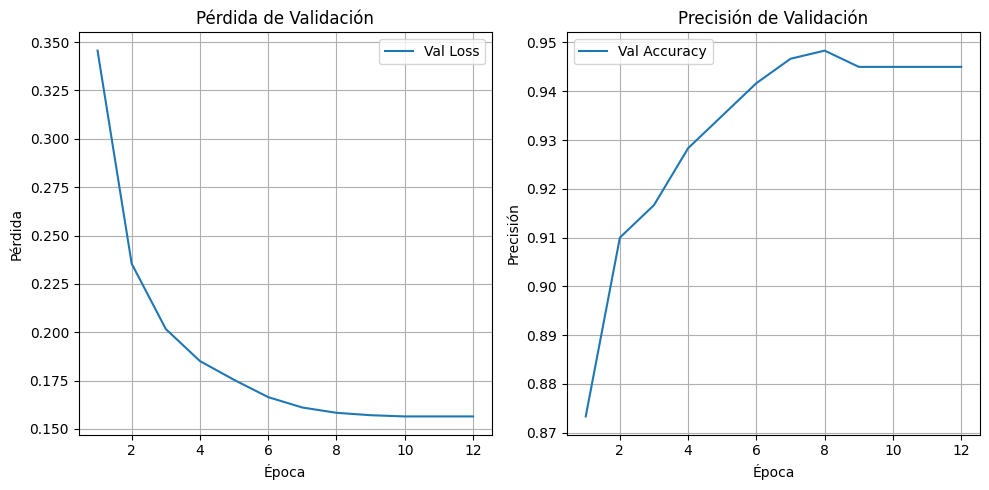

In [ ]:
import matplotlib.pyplot as plt

with open(metrics_path, "rb") as f:
    metrics = pickle.load(f)

val_losses = metrics["val_metrics"]["losses"]
val_accuracies = metrics["val_metrics"]["accuracies"]
epochs = range(1, len(val_losses) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Pérdida de Validación")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label="Val Accuracy")
plt.xlabel("Época")
plt.ylabel("Precisión")
plt.title("Precisión de Validación")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(RUN_PATH, "validation_metrics.png"))

# Diagnóstico y gráficas (Entrenamiento de TimeSformer con Transfer Learning)

In [ ]:
# Diagnóstico y gráficas (Entrenamiento de TimeSformer con Transfer Learning)
# - Evaluar métricas recolectadas
# - Diagnosticar según metodología (11.3)

import matplotlib.pyplot as plt
import os
import logging
import pickle

# Configurar logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler("diagnostics.log"),
        logging.StreamHandler()
    ]
)

# Definir rutas
# BASE_PATH_ = "/content/drive/MyDrive/Proyecto IA-3/violence_school_project/"
# MODEL_PATH = os.path.join(BASE_PATH_, "models/timesformer")
# RUN_PATH = os.path.join(MODEL_PATH, "run_YYYYMMDD_HHMMSS")  # Ajustar según RUN_ID

RUN_PATH_METRICAS = "/content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_20250407_115035"

# Cargar métricas
metrics_path = os.path.join(RUN_PATH_METRICAS, "timesformer_transfer_metrics.pkl")
if not os.path.exists(metrics_path):
    raise FileNotFoundError(f"No se encontró el archivo de métricas: {metrics_path}")

with open(metrics_path, "rb") as f:
    metrics = pickle.load(f)

train_losses = metrics["train_losses"]
val_losses = metrics["val_losses"]
train_accuracies = metrics["train_accuracies"]
val_accuracies = metrics["val_accuracies"]
val_f1_scores = metrics["val_f1_scores"]
test_loss = metrics["test_loss"]
test_accuracy = metrics["test_accuracy"]
test_f1 = metrics["test_f1"]


# Gráficas
plt.figure(figsize=(15, 10))

# Pérdida
plt.subplot(2, 2, 1)
plt.plot(train_losses, label="Train Loss", color="blue")
plt.plot(val_losses, label="Val Loss", color="orange")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Pérdida (TimeSformer - Transfer Learning)")
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy", color="blue")
plt.plot(val_accuracies, label="Val Accuracy", color="orange")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.title("Accuracy (TimeSformer - Transfer Learning)")
plt.legend()
plt.grid(True)

# F1-Score (validación)
plt.subplot(2, 2, 3)
plt.plot(val_f1_scores, label="Val F1-Score", color="green")
plt.xlabel("Época")
plt.ylabel("F1-Score")
plt.title("F1-Score (Validación)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(RUN_PATH, "timesformer_transfer_training_curves.png"))
logging.info(f"Gráficas guardadas en: {os.path.join(RUN_PATH, 'timesformer_transfer_training_curves.png')}")

# Diagnóstico (11.3)
if val_accuracies[-1] < 0.7:
    logging.warning("Subajuste: Accuracy en validación es bajo (<0.7). Considerar aumentar capacidad (descongelar más capas), más épocas, o revisar el dataset.")
elif val_accuracies[-1] < train_accuracies[-1] - 0.1:
    logging.warning("Sobreajuste: Diferencia significativa entre train y val accuracy (>0.1). Considerar regularización (aumentar weight decay), más datos, o data augmentation.")
else:
    logging.info("Rendimiento aceptable en términos de accuracy.")

logging.info(f"Resultados finales en test: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, F1-Score: {test_f1:.4f}")

# Recomendaciones para el siguiente paso (fine-tuning)
if val_f1 < 0.8:
    logging.info("F1-score en validación es bajo (<0.8). Se recomienda proceder con fine-tuning, descongelando algunas capas del modelo (por ejemplo, las últimas capas de atención).")
else:
    logging.info("F1-score en validación es aceptable (>=0.8). El modelo puede usarse directamente, pero fine-tuning podría mejorar aún más el rendimiento.")

KeyError: 'train_losses'

Evaluación en Validación: 100%|██████████| 300/300 [01:35<00:00,  3.13it/s]


Matriz de confusión guardada en: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_20250407_115035/evaluation/val_confusion_matrix.png
=== Métricas de Validación ===
Val Loss: 0.1565
Val Accuracy: 0.9450
Val Precision: 0.9588
Val Recall: 0.9300
Val F1: 0.9442
Métricas guardadas en: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_20250407_115035/evaluation/val_metrics.pkl


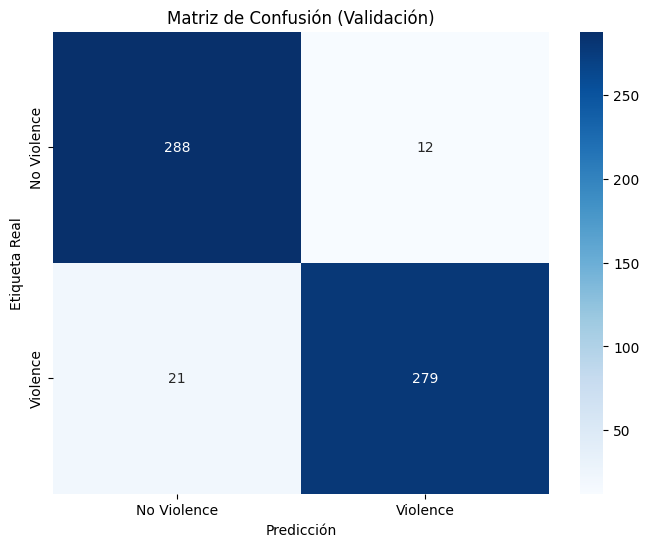

In [ ]:
# Evaluación detallada de TimeSformer en el conjunto de validación
# - Metodología del Capítulo 11 y buenas prácticas

# Instalar dependencias
=
# !pip install scikit-learn
# !pip install tqdm
# !pip install seaborn

# # Importar librerías
import os
# import cv2
# import torch
# import logging
import pickle
# import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Configurar logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler("timesformer_val_evaluation.log"),
        logging.StreamHandler()
    ]
)

# Definir rutas
BASE_PATH = "/content/drive/MyDrive/Proyecto IA-3/violence_school_project/"
DATA_PATH = os.path.join(BASE_PATH, "timesformer_data")
# MODEL_PATH = os.path.join(BASE_PATH, "models/timesformer/run_20250407_115035/best_timesformer_transfer.pt")  # Ajustar según RUN_ID
RUN_PATH = os.path.join(BASE_PATH, "models/timesformer/run_20250407_115035/evaluation")

# Validar rutas
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"DATA_PATH no encontrado: {DATA_PATH}")
# if not os.path.exists(MODEL_PATH):
#     raise FileNotFoundError(f"MODEL_PATH no encontrado: {MODEL_PATH}")
if not os.path.exists(RUN_PATH):
    os.makedirs(RUN_PATH, exist_ok=True)
    logging.info(f"Creado directorio RUN_PATH: {RUN_PATH}")


# Cargar el procesador de imágenes y el modelo
# image_processor = AutoImageProcessor.from_pretrained("facebook/timesformer-base-finetuned-k400")
# model = TimesformerForVideoClassification.from_pretrained(MODEL_PATH)

# Mover modelo a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
logging.info(f"Modelo cargado en dispositivo: {device}")

# Configurar dataset y dataloader
# val_dataset = ViolenceVideoDataset(DATA_PATH, split="val", num_frames=8, image_processor=image_processor)
# val_data = [(frames, label) for frames, label in val_dataset if frames is not None]
val_loader = DataLoader(val_data, batch_size=2, shuffle=False, num_workers=2)

# Evaluar en el conjunto de validación
model.eval()
val_loss = 0
val_preds, val_labels = [], []
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluación en Validación"):
        videos, labels = batch
        videos = videos.to(device)
        labels = labels.squeeze().to(device)

        outputs = model(pixel_values=videos, labels=labels)
        loss = outputs.loss
        val_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

val_loss /= len(val_loader)
val_accuracy = accuracy_score(val_labels, val_preds)
val_precision = precision_score(val_labels, val_preds, average="binary")
val_recall = recall_score(val_labels, val_preds, average="binary")
val_f1 = f1_score(val_labels, val_preds, average="binary")

# Calcular matriz de confusión
conf_matrix = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Violence", "Violence"], yticklabels=["No Violence", "Violence"])
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión (Validación)")
plt.savefig(os.path.join(RUN_PATH, "val_confusion_matrix.png"))
logging.info(f"Matriz de confusión guardada en: {os.path.join(RUN_PATH, 'val_confusion_matrix.png')}")
print(f"Matriz de confusión guardada en: {os.path.join(RUN_PATH, 'val_confusion_matrix.png')}")

# Logging de métricas
print("=== Métricas de Validación ===")
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Accuracy: {val_accuracy:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")
print(f"Val F1: {val_f1:.4f}")

# Guardar métricas
metrics = {
    "val_loss": val_loss,
    "val_accuracy": val_accuracy,
    "val_precision": val_precision,
    "val_recall": val_recall,
    "val_f1": val_f1,
    "val_preds": val_preds,
    "val_labels": val_labels,
    "conf_matrix": conf_matrix.tolist()
}
metrics_path = os.path.join(RUN_PATH, "val_metrics.pkl")
with open(metrics_path, "wb") as f:
    pickle.dump(metrics, f)
logging.info(f"Métricas guardadas en: {metrics_path}")
print(f"Métricas guardadas en: {metrics_path}")

Evaluación en Test: 100%|██████████| 150/150 [00:49<00:00,  3.01it/s]


Matriz de confusión guardada en: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_20250407_115035/evaluation/test_confusion_matrix.png
=== Métricas de Test ===
Test Loss: 0.1352
Test Accuracy: 0.9633
Test Precision: 0.9793
Test Recall: 0.9467
Test F1: 0.9627
Métricas guardadas en: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_20250407_115035/evaluation/test_metrics.pkl


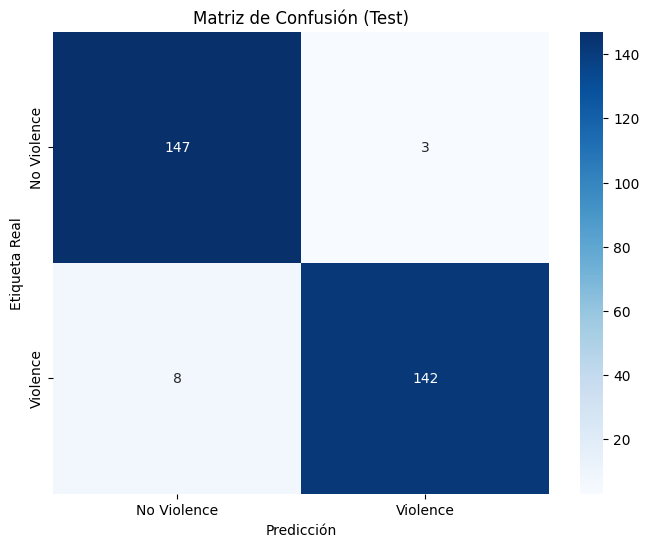

In [ ]:
# Evaluación detallada de TimeSformer en el conjunto de test
# - Metodología del Capítulo 11 y buenas prácticas


# Configurar logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler("timesformer_test_evaluation.log"),
        logging.StreamHandler()
    ]
)

# Definir rutas
# BASE_PATH = "/content/drive/MyDrive/Proyecto IA-3/violence_school_project/"
# DATA_PATH = os.path.join(BASE_PATH, "timesformer_data")
# MODEL_PATH = os.path.join(BASE_PATH, "models/timesformer/run_YYYYMMDD_HHMMSS/best_timesformer_transfer.pt")  # Ajustar según RUN_ID
# RUN_PATH = os.path.join(BASE_PATH, "models/timesformer/run_YYYYMMDD_HHMMSS/evaluation")

# Validar rutas
# if not os.path.exists(DATA_PATH):
#     raise FileNotFoundError(f"DATA_PATH no encontrado: {DATA_PATH}")
# if not os.path.exists(MODEL_PATH):
#     raise FileNotFoundError(f"MODEL_PATH no encontrado: {MODEL_PATH}")
# if not os.path.exists(RUN_PATH):
#     os.makedirs(RUN_PATH, exist_ok=True)
#     logging.info(f"Creado directorio RUN_PATH: {RUN_PATH}")


# Cargar el procesador de imágenes y el modelo
# image_processor = AutoImageProcessor.from_pretrained("facebook/timesformer-base-finetuned-k400")
# model = TimeSformerForVideoClassification.from_pretrained(MODEL_PATH)

# Mover modelo a GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# logging.info(f"Modelo cargado en dispositivo: {device}")

# Configurar dataset y dataloader
# test_dataset = ViolenceVideoDataset(DATA_PATH, split="test", num_frames=8, image_processor=image_processor)
# test_data = [(frames, label) for frames, label in test_dataset if frames is not None]
test_loader = DataLoader(test_data, batch_size=2, shuffle=False, num_workers=2)

# Evaluar en el conjunto de test
model.eval()
test_loss = 0
test_preds, test_labels = [], []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluación en Test"):
        videos, labels = batch
        videos = videos.to(device)
        labels = labels.squeeze().to(device)

        outputs = model(pixel_values=videos, labels=labels)
        loss = outputs.loss
        test_loss += loss.item()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader)
test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, average="binary")
test_recall = recall_score(test_labels, test_preds, average="binary")
test_f1 = f1_score(test_labels, test_preds, average="binary")

# Calcular matriz de confusión
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Violence", "Violence"], yticklabels=["No Violence", "Violence"])
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión (Test)")
plt.savefig(os.path.join(RUN_PATH, "test_confusion_matrix.png"))
logging.info(f"Matriz de confusión guardada en: {os.path.join(RUN_PATH, 'test_confusion_matrix.png')}")
print(f"Matriz de confusión guardada en: {os.path.join(RUN_PATH, 'test_confusion_matrix.png')}")

# Logging de métricas
print("=== Métricas de Test ===")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1: {test_f1:.4f}")

# Guardar métricas
metrics = {
    "test_loss": test_loss,
    "test_accuracy": test_accuracy,
    "test_precision": test_precision,
    "test_recall": test_recall,
    "test_f1": test_f1,
    "test_preds": test_preds,
    "test_labels": test_labels,
    "conf_matrix": conf_matrix.tolist()
}
metrics_path = os.path.join(RUN_PATH, "test_metrics.pkl")
with open(metrics_path, "wb") as f:
    pickle.dump(metrics, f)
logging.info(f"Métricas guardadas en: {metrics_path}")
print(f"Métricas guardadas en: {metrics_path}")

In [ ]:
# Visualización de predicciones de TimeSformer en videos del conjunto de test
# - Metodología del Capítulo 11 y buenas prácticas

# Instalar dependencias
# !pip install transformers==4.44.2
# !pip install torch==2.6.0
# !pip install opencv-python
# !pip install tqdm

# # Importar librerías
# import os
# import cv2
# import torch
# import logging
import random
# import numpy as np
# from tqdm import tqdm
# from torch.utils.data import Dataset
# from transformers import AutoImageProcessor, TimeSformerForVideoClassification

# Configurar logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler("timesformer_predictions_visualization.log"),
        logging.StreamHandler()
    ]
)

# Definir rutas
# BASE_PATH = "/content/drive/MyDrive/Proyecto IA-3/violence_school_project/"
# DATA_PATH = os.path.join(BASE_PATH, "timesformer_data")
# MODEL_PATH = os.path.join(BASE_PATH, "models/timesformer/run_20250407_115035/best_timesformer_transfer.pt")  # Ajustar según RUN_ID
RUN_PATH_PRED = os.path.join(BASE_PATH, "models/timesformer/run_20250407_115035/predictions")

# Validar rutas
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"DATA_PATH no encontrado: {DATA_PATH}")
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"MODEL_PATH no encontrado: {MODEL_PATH}")
if not os.path.exists(RUN_PATH_PRED):
    os.makedirs(RUN_PATH_PRED, exist_ok=True)
    logging.info(f"Creado directorio RUN_PATH_PRED: {RUN_PATH_PRED}")



# Clase para cargar y preprocesar videos (reutilizada)
class ViolenceVideoDataset2(Dataset):
    def __init__(self, video_dir, split="test", num_frames=8, image_processor=None):
        self.video_dir = os.path.join(video_dir, split)
        self.num_frames = num_frames
        self.image_processor = image_processor
        self.videos = []
        self.labels = []

        for label, class_name in enumerate(["no_violence", "violence"]):
            class_dir = os.path.join(self.video_dir, class_name)
            if not os.path.exists(class_dir):
                logging.warning(f"No se encontró la carpeta: {class_dir}")
                continue
            for video_file in os.listdir(class_dir):
                if video_file.endswith((".mp4", ".avi")):
                    self.videos.append(os.path.join(class_dir, video_file))
                    self.labels.append(label)

        logging.info(f"Cargados {len(self.videos)} videos para {split}")

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        video_path = self.videos[idx]
        label = self.labels[idx]

        cap = cv2.VideoCapture(video_path)
        frames = []
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if frame_count < self.num_frames:
            while len(frames) < self.num_frames:
                ret, frame = cap.read()
                if not ret:
                    if frames:
                        frames.append(frames[-1])
                    else:
                        cap.release()
                        logging.warning(f"Video {video_path} no tiene frames válidos")
                        return None, None, None
                else:
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frames.append(frame)
        else:
            step = max(1, frame_count // self.num_frames)
            frame_indices = list(range(0, frame_count, step))[:self.num_frames]
            for idx in frame_indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
                ret, frame = cap.read()
                if not ret:
                    continue
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame)

        cap.release()

        if len(frames) != self.num_frames:
            logging.warning(f"No se pudieron cargar {self.num_frames} frames de {video_path}")
            return None, None, None

        inputs = self.image_processor(frames, return_tensors="pt")
        # video_tensor = inputs["pixel_values"].squeeze(1)
        video_tensor = inputs["pixel_values"]

        return video_tensor, label, frames



# Cargar el procesador de imágenes y el modelo
# image_processor = AutoImageProcessor.from_pretrained("facebook/timesformer-base-finetuned-k400")
# model = TimeSformerForVideoClassification.from_pretrained(MODEL_PATH)

# Mover modelo a GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# logging.info(f"Modelo cargado en dispositivo: {device}")

# Configurar dataset
test_dataset_pred = ViolenceVideoDataset2(DATA_PATH, split="test", num_frames=8, image_processor=image_processor)
test_data_pred = [(frames, label, frames_raw) for frames, label, frames_raw in test_dataset_pred if frames is not None]

# Seleccionar un subconjunto de videos para visualizar (por ejemplo, 5 videos)
num_videos_to_visualize = 5
selected_data = random.sample(test_data_pred, min(num_videos_to_visualize, len(test_data_pred)))
logging.info(f"Seleccionados {len(selected_data)} videos para visualización.")
print(f"Seleccionados {len(selected_data)} videos para visualización.")

# Realizar predicciones y visualizar
model.eval()
for idx, (video_tensor, true_label, frames) in enumerate(selected_data):
    # video_tensor = video_tensor.squeeze(0).to(device)  # Añadir dimensión de batch
    video_tensor = video_tensor.to(device)  # Añadir dimensión de batch

    with torch.no_grad():
        outputs = model(pixel_values=video_tensor)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
        pred_label = torch.argmax(probs, dim=1).cpu().numpy()[0]
        confidence = probs[0, pred_label].cpu().numpy()

    # Seleccionar un frame representativo (por ejemplo, el frame del medio)
    frame = frames[len(frames) // 2]
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

    # Añadir texto con la predicción y la confianza
    label_text = f"Pred: {'Violence' if pred_label == 1 else 'No Violence'} ({confidence:.2f})"
    true_text = f"True: {'Violence' if true_label == 1 else 'No Violence'}"
    cv2.putText(frame, label_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0) if pred_label == true_label else (0, 0, 255), 2)
    cv2.putText(frame, true_text, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Guardar frame con predicción
    output_path = os.path.join(RUN_PATH_PRED, f"prediction_{idx + 1}.jpg")
    cv2.imwrite(output_path, frame)
    logging.info(f"Predicción guardada en: {output_path}")
    print(f"Predicción guardada en: {output_path}")

Seleccionados 5 videos para visualización.
Predicción guardada en: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_20250407_115035/predictions/prediction_1.jpg
Predicción guardada en: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_20250407_115035/predictions/prediction_2.jpg
Predicción guardada en: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_20250407_115035/predictions/prediction_3.jpg
Predicción guardada en: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_20250407_115035/predictions/prediction_4.jpg
Predicción guardada en: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_20250407_115035/predictions/prediction_5.jpg


## Usar el modelo para pruebas adicionales

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

In [ ]:
# import cv2
# import torch
# import numpy as np
# from transformers import AutoImageProcessor, TimesformerForVideoClassification

# Cargar el procesador de imágenes
# image_processor = AutoImageProcessor.from_pretrained("facebook/timesformer-base-finetuned-k400")

# Definir rutas
RUN_PATH_MODEL = "/content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_20250407_115035"
final_checkpoint_path = os.path.join(RUN_PATH_MODEL, "final_timesformer_transfer.pt")
best_checkpoint_path = os.path.join(RUN_PATH_MODEL, "best_timesformer_transfer.pt")

# Cargar el modelo entrenado
model = TimesformerForVideoClassification.from_pretrained(best_checkpoint_path)
model.to(device)
model.eval()

# Función para preprocesar un video
def preprocess_video(video_path, num_frames=8):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(1, frame_count // num_frames)
    frame_indices = list(range(0, frame_count, step))[:num_frames]

    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            continue
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

    cap.release()

    if len(frames) != num_frames:
        raise ValueError(f"No se pudieron cargar {num_frames} frames del video {video_path}")

    inputs = image_processor(frames, return_tensors="pt")
    video_tensor = inputs["pixel_values"].squeeze(0)  # (T, C, H, W)
    return video_tensor

# Hacer una predicción
# video_path = "/content/drive/MyDrive/Proyecto IA-3/violence_school_project/timesformer_data/test/violence/violence_1354.mp4"  # Reemplaza con la ruta de tu video
video_path = "/content/drive/MyDrive/Proyecto IA-3/violence_school_project/timesformer_data/test/no_violence/no_violence_1354.mp4"  # Reemplaza con la ruta de tu video
video_tensor = preprocess_video(video_path, num_frames=8)
video_tensor = video_tensor.unsqueeze(0).to(device)  # (1, T, C, H, W)

with torch.no_grad():
    with torch.amp.autocast('cuda'):
        outputs = model(pixel_values=video_tensor)
    logits = outputs.logits
    pred = torch.argmax(logits, dim=1).cpu().numpy()[0]

# Mapear la predicción a una etiqueta
labels_map = {0: "no_violence", 1: "violence"}
predicted_label = labels_map[pred]
print(f"Predicción: {predicted_label}")

Predicción: no_violence


In [ ]:
# Pruebas de robustez de TimeSformer
# - Metodología del Capítulo 11 y buenas prácticas

# Instalar dependencias
!pip install transformers==4.44.2
!pip install torch==2.6.0
!pip install opencv-python
!pip install scikit-learn
!pip install tqdm

# Importar librerías
import os
import cv2
import torch
import logging
import pickle
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import AutoImageProcessor, TimeSformerForVideoClassification

# Configurar logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler("timesformer_robustness_test.log"),
        logging.StreamHandler()
    ]
)

# Definir rutas
BASE_PATH = "/content/drive/MyDrive/Proyecto IA-3/violence_school_project/"
DATA_PATH = os.path.join(BASE_PATH, "timesformer_data")
MODEL_PATH = os.path.join(BASE_PATH, "models/timesformer/run_YYYYMMDD_HHMMSS/best_timesformer_transfer.pt")  # Ajustar según RUN_ID
RUN_PATH = os.path.join(BASE_PATH, "models/timesformer/run_YYYYMMDD_HHMMSS/robustness")

# Validar rutas
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"DATA_PATH no encontrado: {DATA_PATH}")
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"MODEL_PATH no encontrado: {MODEL_PATH}")
if not os.path.exists(RUN_PATH):
    os.makedirs(RUN_PATH, exist_ok=True)
    logging.info(f"Creado directorio RUN_PATH: {RUN_PATH}")

# Clase para cargar y preprocesar videos con modificaciones para pruebas de robustez
class ViolenceVideoDatasetRobustness(Dataset):
    def __init__(self, video_dir, split="test", num_frames=8, image_processor=None, condition="normal"):
        self.video_dir = os.path.join(video_dir, split)
        self.num_frames = num_frames
        self.image_processor = image_processor
        self.condition = condition  # "normal", "low_frames", "low_light"
        self.videos = []
        self.labels = []

        for label, class_name in enumerate(["no_violence", "violence"]):
            class_dir = os.path.join(self.video_dir, class_name)
            if not os.path.exists(class_dir):
                logging.warning(f"No se encontró la carpeta: {class_dir}")
                continue
            for video_file in os.listdir(class_dir):
                if video_file.endswith((".mp4", ".avi")):
                    self.videos.append(os.path.join(class_dir, video_file))
                    self.labels.append(label)

        logging.info(f"Cargados {len(self.videos)} videos para {split} (condición: {condition})")

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        video_path = self.videos[idx]
        label = self.labels[idx]

        cap = cv2.VideoCapture(video_path)
        frames = []
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        if self.condition == "low_frames":
            # Simular video con pocos frames (usar solo 4 frames y repetir)
            target_frames = 4
            if frame_count < target_frames:
                while len(frames) < target_frames:
                    ret, frame = cap.read()
                    if not ret:
                        if frames:
                            frames.append(frames[-1])
                        else:
                            cap.release()
                            logging.warning(f"Video {video_path} no tiene frames válidos")
                            return None, None
                    else:
                        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        frames.append(frame)
            else:
                step = max(1, frame_count // target_frames)
                frame_indices = list(range(0, frame_count, step))[:target_frames]
                for idx in frame_indices:
                    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
                    ret, frame = cap.read()
                    if not ret:
                        continue
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frames.append(frame)

            # Repetir frames para alcanzar num_frames
            while len(frames) < self.num_frames:
                frames.append(frames[-1])

        else:
            # Carga normal
            if frame_count < self.num_frames:
                while len(frames) < self.num_frames:
                    ret, frame = cap.read()
                    if not ret:
                        if frames:
                            frames.append(frames[-1])
                        else:
                            cap.release()
                            logging.warning(f"Video {video_path} no tiene frames válidos")
                            return None, None
                    else:
                        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        frames.append(frame)
            else:
                step = max(1, frame_count // self.num_frames)
                frame_indices = list(range(0, frame_count, step))[:self.num_frames]
                for idx in frame_indices:
                    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
                    ret, frame = cap.read()
                    if not ret:
                        continue
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frames.append(frame)

        cap.release()

        if len(frames) != self.num_frames:
            logging.warning(f"No se pudieron cargar {self.num_frames} frames de {video_path}")
            return None, None

        # Simular iluminación baja
        if self.condition == "low_light":
            frames = [np.clip(frame * 0.5, 0, 255).astype(np.uint8) for frame in frames]

        inputs = self.image_processor(frames, return_tensors="pt")
        video_tensor = inputs["pixel_values"].squeeze(1)
        label_tensor = torch.LongTensor([label])

        return video_tensor, label_tensor

# Cargar el procesador de imágenes y el modelo
image_processor = AutoImageProcessor.from_pretrained("facebook/timesformer-base-finetuned-k400")
model = TimeSformerForVideoClassification.from_pretrained(MODEL_PATH)

# Mover modelo a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
logging.info(f"Modelo cargado en dispositivo: {device}")

# Evaluar en diferentes condiciones
conditions = ["normal", "low_frames", "low_light"]
results = {}

for condition in conditions:
    logging.info(f"Evaluando condición: {condition}")
    dataset = ViolenceVideoDatasetRobustness(DATA_PATH, split="test", num_frames=8, image_processor=image_processor, condition=condition)
    data = [(frames, label) for frames, label in dataset if frames is not None]
    loader = DataLoader(data, batch_size=2, shuffle=False, num_workers=2)

    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in tqdm(loader, desc=f"Evaluación ({condition})"):
            videos, batch_labels = batch
            videos = videos.to(device)
            batch_labels = batch_labels.squeeze().to(device)

            outputs = model(pixel_values=videos)
            logits = outputs.logits
            batch_preds = torch.argmax(logits, dim=1)
            preds.extend(batch_preds.cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())

    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="binary")
    results[condition] = {"accuracy": accuracy, "f1": f1}

    logging.info(f"Condición {condition}: Accuracy: {accuracy:.4f}, F1: {f1:.4f}")

# Guardar resultados
results_path = os.path.join(RUN_PATH, "robustness_results.pkl")
with open(results_path, "wb") as f:
    pickle.dump(results, f)
logging.info(f"Resultados de robustez guardados en: {results_path}")

In [ ]:
# Diagnóstico mejorado de TimeSformer
# - Metodología del Capítulo 11 y buenas prácticas

# Instalar dependencias
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn

# Importar librerías
import os
import logging
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Configurar logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler("diagnostics.log"),
        logging.StreamHandler()
    ]
)

# Definir rutas
BASE_PATH = "/content/drive/MyDrive/Proyecto IA-3/violence_school_project/"
MODEL_PATH = os.path.join(BASE_PATH, "models/timesformer")
RUN_PATH = os.path.join(MODEL_PATH, "run_YYYYMMDD_HHMMSS")  # Ajustar según RUN_ID

# Cargar métricas
metrics_path = os.path.join(RUN_PATH, "timesformer_transfer_metrics.pkl")
if not os.path.exists(metrics_path):
    raise FileNotFoundError(f"No se encontró el archivo de métricas: {metrics_path}")

with open(metrics_path, "rb") as f:
    metrics = pickle.load(f)

train_metrics = metrics["train_metrics"]
val_metrics = metrics["val_metrics"]
test_loss = metrics["test_loss"]
test_accuracy = metrics["test_accuracy"]
test_precision = metrics["test_precision"]
test_recall = metrics["test_recall"]
test_f1 = metrics["test_f1"]
test_preds = metrics["test_preds"]
test_labels = metrics["test_labels"]

# Gráficas
plt.figure(figsize=(15, 15))

# Pérdida
plt.subplot(3, 2, 1)
plt.plot(train_metrics["losses"], label="Train Loss", color="blue")
plt.plot(val_metrics["losses"], label="Val Loss", color="orange")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Pérdida (TimeSformer - Transfer Learning)")
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(3, 2, 2)
plt.plot(train_metrics["accuracies"], label="Train Accuracy", color="blue")
plt.plot(val_metrics["accuracies"], label="Val Accuracy", color="orange")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.title("Accuracy (TimeSformer - Transfer Learning)")
plt.legend()
plt.grid(True)

# F1-Score (validación)
plt.subplot(3, 2, 3)
plt.plot(val_metrics["f1_scores"], label="Val F1-Score", color="green")
plt.xlabel("Época")
plt.ylabel("F1-Score")
plt.title("F1-Score (Validación)")
plt.legend()
plt.grid(True)

# Precision y Recall (validación)
plt.subplot(3, 2, 4)
plt.plot(val_metrics["precisions"], label="Val Precision", color="purple")
plt.plot(val_metrics["recalls"], label="Val Recall", color="red")
plt.xlabel("Época")
plt.ylabel("Métrica")
plt.title("Precision y Recall (Validación)")
plt.legend()
plt.grid(True)

# Curva ROC (test)
fpr, tpr, _ = roc_curve(test_labels, test_preds)
roc_auc = auc(fpr, tpr)
plt.subplot(3, 2, 5)
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC (Test)")
plt.legend(loc="lower right")
plt.grid(True)

# Curva Precision-Recall (test)
precision, recall, _ = precision_recall_curve(test_labels, test_preds)
pr_auc = auc(recall, precision)
plt.subplot(3, 2, 6)
plt.plot(recall, precision, color="blue", lw=2, label=f"PR curve (area = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall (Test)")
plt.legend(loc="lower left")
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(RUN_PATH, "timesformer_transfer_diagnostics.png"))
logging.info(f"Gráficas guardadas en: {os.path.join(RUN_PATH, 'timesformer_transfer_diagnostics.png')}")

# Diagnóstico (11.3)
if val_metrics["accuracies"][-1] < 0.7:
    logging.warning("Subajuste: Accuracy en validación es bajo (<0.7). Considerar aumentar capacidad (descongelar más capas), más épocas, o revisar el dataset.")
elif val_metrics["accuracies"][-1] < train_metrics["accuracies"][-1] - 0.1:
    logging.warning("Sobreajuste: Diferencia significativa entre train y val accuracy (>0.1). Considerar regularización (aumentar weight decay), más datos, o data augmentation.")
else:
    logging.info("Rendimiento aceptable en términos de accuracy.")

if val_metrics["f1_scores"][-1] < 0.8:
    logging.info("F1-score en validación es bajo (<0.8). Se recomienda proceder con fine-tuning, descongelando algunas capas del modelo (por ejemplo, las últimas capas de atención).")
else:
    logging.info("F1-score en validación es aceptable (>=0.8). El modelo puede usarse directamente, pero fine-tuning podría mejorar aún más el rendimiento.")

logging.info(f"Resultados finales en test: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-Score: {test_f1:.4f}")

# **ENTRENAMIENTO FINE-TIUNING**

In [ ]:
# Instalar dependencias necesarias
!pip install transformers torch torchvision opencv-python scikit-learn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Fine-tuning de TimeSformer para detección de violencia escolar
# - Ajustado para diagnóstico y gráficas
# - Metodología del Capítulo 11 y buenas prácticas profesionales


# Importar librerías
import os
import cv2
import torch
import logging
import pickle
from datetime import datetime
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from transformers import AutoImageProcessor, TimesformerForVideoClassification
from transformers import get_linear_schedule_with_warmup

In [ ]:

# Configurar logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler("fine_tuning.log"),
        logging.StreamHandler()
    ]
)

# Definir rutas
BASE_PATH = "/content/drive/MyDrive/Proyecto IA-3/violence_school_project/"
DATA_PATH = os.path.join(BASE_PATH, "timesformer_data")
MODEL_PATH = os.path.join(BASE_PATH, "models/timesformer")
RUN_ID = datetime.now().strftime("%Y%m%d_%H%M%S")
RUN_PATH = os.path.join(MODEL_PATH, f"run_finetune_{RUN_ID}")

# Validar rutas
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"DATA_PATH no encontrado: {DATA_PATH}")
if not os.path.exists(RUN_PATH):
    os.makedirs(RUN_PATH, exist_ok=True)
    logging.info(f"Creado directorio RUN_PATH: {RUN_PATH}")

# Clase para cargar y preprocesar videos
class ViolenceVideoDatasetFine(Dataset):
    def __init__(self, video_dir, split="train", num_frames=8, image_processor=None):
        self.video_dir = os.path.join(video_dir, split)
        self.num_frames = num_frames
        self.image_processor = image_processor
        self.videos = []
        self.labels = []

        # Cargar videos y etiquetas
        for label, class_name in enumerate(["no_violence", "violence"]):
            class_dir = os.path.join(self.video_dir, class_name)
            if not os.path.exists(class_dir):
                logging.warning(f"No se encontró la carpeta: {class_dir}")
                continue
            for video_file in os.listdir(class_dir):
                if video_file.endswith((".mp4", ".avi")):
                    self.videos.append(os.path.join(class_dir, video_file))
                    self.labels.append(label)

        logging.info(f"Cargados {len(self.videos)} videos para {split}")

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        video_path = self.videos[idx]
        label = self.labels[idx]

        # Cargar video
        cap = cv2.VideoCapture(video_path)
        frames = []
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if frame_count < self.num_frames:
            # Repetir el último frame si el video es demasiado corto
            while len(frames) < self.num_frames:
                ret, frame = cap.read()
                if not ret:
                    if frames:
                        frames.append(frames[-1])  # Repetir último frame
                    else:
                        cap.release()
                        logging.warning(f"Video {video_path} no tiene frames válidos")
                        return None, None
                else:
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frames.append(frame)
        else:
            # Submuestreo uniforme
            step = max(1, frame_count // self.num_frames)
            frame_indices = list(range(0, frame_count, step))[:self.num_frames]
            for idx in frame_indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
                ret, frame = cap.read()
                if not ret:
                    continue
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame)

        cap.release()

        if len(frames) != self.num_frames:
            logging.warning(f"No se pudieron cargar {self.num_frames} frames de {video_path}")
            return None, None

        # Preprocesar frames con AutoImageProcessor
        inputs = self.image_processor(frames, return_tensors="pt")
        video_tensor = inputs["pixel_values"].squeeze(0)  # (T, C, H, W)
        if video_tensor.shape != (self.num_frames, 3, 224, 224):
            logging.warning(f"Dimensiones incorrectas para {video_path}: {video_tensor.shape}")
            return None, None
        label_tensor = torch.LongTensor([label])

        return video_tensor, label_tensor


In [ ]:
# Cargar el procesador de imágenes
image_processor = AutoImageProcessor.from_pretrained("facebook/timesformer-base-finetuned-k400")

# Cargar el modelo preentrenado desde el transfer learning
TRANSFER_MODEL_PATH = "/content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_20250407_115035/best_timesformer_transfer.pt"
if not os.path.exists(TRANSFER_MODEL_PATH):
    raise FileNotFoundError(f"No se encontró el modelo de transfer learning: {TRANSFER_MODEL_PATH}")

model = TimesformerForVideoClassification.from_pretrained(TRANSFER_MODEL_PATH)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
logging.info(f"Modelo cargado desde: {TRANSFER_MODEL_PATH} en dispositivo: {device}")
print(f"Modelo cargado desde: {TRANSFER_MODEL_PATH} en dispositivo: {device}")

# Descongelar las últimas 4 capas del backbone para fine-tuning
for param in model.parameters():
    param.requires_grad = False  # Congelar todas las capas inicialmente

# Descongelar las últimas 4 capas del backbone (timesformer.encoder.layer[-4:])
#  (la parte que extrae características del video)
for layer in model.timesformer.encoder.layer[-2:]:
    for param in layer.parameters():
        param.requires_grad = True

# Descongelar el clasificador
# (la parte que toma las características extraídas y predice la clase del video).
# Esto permite que el clasificador se adapte específicamente a la nueva tarea.
for param in model.classifier.parameters():
    param.requires_grad = True

logging.info("Congeladas todas las capas excepto las últimas 4 del backbone y el clasificador")
print("Congeladas todas las capas excepto las últimas 4 del backbone y el clasificador")

# Liberar memoria de la GPU
torch.cuda.empty_cache()

Modelo cargado desde: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_20250407_115035/best_timesformer_transfer.pt en dispositivo: cuda
Congeladas todas las capas excepto las últimas 4 del backbone y el clasificador


In [ ]:
# Configurar dataset y dataloaders
logging.info("Cargando datasets...")

train_dataset = ViolenceVideoDatasetFine(DATA_PATH, split="train", num_frames=8, image_processor=image_processor)
val_dataset = ViolenceVideoDatasetFine(DATA_PATH, split="val", num_frames=8, image_processor=image_processor)
test_dataset = ViolenceVideoDatasetFine(DATA_PATH, split="test", num_frames=8, image_processor=image_processor)

# Filtrar None en los datasets
train_data = [(frames, label) for frames, label in train_dataset if frames is not None]
val_data = [(frames, label) for frames, label in val_dataset if frames is not None]
test_data = [(frames, label) for frames, label in test_dataset if frames is not None]

# Configurar DataLoaders con num_workers=0 para evitar problemas de multiprocessing
train_loader = DataLoader(train_data, batch_size=1, shuffle=True, num_workers=0)
val_loader = DataLoader(val_data, batch_size=1, shuffle=False, num_workers=0)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False, num_workers=0)


print(f"Number of valid training samples: {len(train_data)}")
print(f"Number of valid validation samples: {len(val_data)}")
print(f"Number of valid test samples: {len(test_data)}")

Number of valid training samples: 2100
Number of valid validation samples: 600
Number of valid test samples: 300


In [ ]:
# Verificar la distribución de etiquetas
train_labels_all = [label.item() for _, label in train_data]
val_labels_all = [label.item() for _, label in val_data]
print(f"Distribución de etiquetas en train: {np.bincount(train_labels_all)}")
print(f"Distribución de etiquetas en val: {np.bincount(val_labels_all)}")


Distribución de etiquetas en train: [1050 1050]
Distribución de etiquetas en val: [300 300]


### ENTRENAMIENTO

In [ ]:
# Liberar memoria de la GPU
torch.cuda.empty_cache()

In [ ]:
# Configurar optimizador y scheduler con hiperparámetros ajustados
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),  # Solo optimizar parámetros descongelados
    lr=1e-5,  # Reducir la tasa de aprendizaje para fine-tuning
    weight_decay=0.2  # Aumentar el weight_decay para mitigar sobreajuste
    # weight_decay=0.05  # Aumentar el weight_decay para mitigar sobreajuste
)

num_epochs = 10  # número de épocas

total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),  # 10% de warmup
    num_training_steps=total_steps
)

# Configurar mixed precision training (desactivado temporalmente)
scaler = torch.amp.GradScaler('cuda')

In [ ]:

# Listas para almacenar métricas
train_metrics = {
    "losses": [],
    "accuracies": [],
    "precisions": [],
    "recalls": [],
    "f1_scores": []
}
val_metrics = {
    "losses": [],
    "accuracies": [],
    "precisions": [],
    "recalls": [],
    "f1_scores": []
}

# Entrenamiento con early stopping
best_val_loss = float("inf")
patience = 3
early_stop_counter = 0

for epoch in range(num_epochs):
    logging.info(f"Inicio de Época {epoch + 1}/{num_epochs}")

    # Entrenamiento
    model.train()
    train_loss = 0
    train_preds, train_labels = [], []
    for batch in tqdm(train_loader, desc=f"Entrenamiento Época {epoch + 1}"):
        videos, labels = batch
        videos = videos.to(device)  # (B, T, C, H, W)
        labels = labels.to(device)  # (B,)

        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):
            outputs = model(pixel_values=videos, labels=labels)
            loss = outputs.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        train_loss += loss.item()
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_loss /= len(train_loader)
    train_accuracy = accuracy_score(train_labels, train_preds)
    train_precision = precision_score(train_labels, train_preds, average="binary")
    train_recall = recall_score(train_labels, train_preds, average="binary")
    train_f1 = f1_score(train_labels, train_preds, average="binary")

    train_metrics["losses"].append(train_loss)
    train_metrics["accuracies"].append(train_accuracy)
    train_metrics["precisions"].append(train_precision)
    train_metrics["recalls"].append(train_recall)
    train_metrics["f1_scores"].append(train_f1)

    # Validación
    model.eval()
    val_loss = 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validación Época {epoch + 1}"):
            videos, labels = batch
            videos = videos.to(device)
            labels = labels.to(device)

            with torch.amp.autocast('cuda'):
                outputs = model(pixel_values=videos, labels=labels)
                loss = outputs.loss
            val_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_precision = precision_score(val_labels, val_preds, average="binary")
    val_recall = recall_score(val_labels, val_preds, average="binary")
    val_f1 = f1_score(val_labels, val_preds, average="binary")

    val_metrics["losses"].append(val_loss)
    val_metrics["accuracies"].append(val_accuracy)
    val_metrics["precisions"].append(val_precision)
    val_metrics["recalls"].append(val_recall)
    val_metrics["f1_scores"].append(val_f1)

    # Logging de métricas
    logging.info(f"Época {epoch + 1} completada")
    logging.info(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}")
    logging.info(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")
    print(f"Época {epoch + 1} completada")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")

    # Guardar checkpoint si mejora
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint_path = os.path.join(RUN_PATH, "best_timesformer_finetune.pt")
        model.save_pretrained(checkpoint_path)
        logging.info(f"Mejor modelo guardado en: {checkpoint_path}")
        print(f"Mejor modelo guardado en: {checkpoint_path}")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        logging.info(f"Pérdida de validación no mejoró. Early stop counter: {early_stop_counter}/{patience}")
        print(f"Pérdida de validación no mejoró. Early stop counter: {early_stop_counter}/{patience}")
        if early_stop_counter >= patience:
            logging.info("Early stopping activado.")
            print("Early stopping activado.")
            break

    # Guardar checkpoint intermedio cada 5 épocas
    if (epoch + 1) % 5 == 0:
        checkpoint_path = os.path.join(RUN_PATH, f"timesformer_finetune_epoch_{epoch + 1}.pt")
        model.save_pretrained(checkpoint_path)
        logging.info(f"Checkpoint intermedio guardado: {checkpoint_path}")
        print(f"Checkpoint intermedio guardado: {checkpoint_path}")

# Guardar modelo final en formato transformers
final_checkpoint_path = os.path.join(RUN_PATH, "final_timesformer_finetune.pt")
model.save_pretrained(final_checkpoint_path)
logging.info(f"Modelo final guardado en formato transformers: {final_checkpoint_path}")
print(f"Modelo final guardado en formato transformers: {final_checkpoint_path}")



Validación Época 1: 100%|██████████| 600/600 [00:25<00:00, 23.58it/s]


Época 1 completada
Train Loss: 0.1187, Train Accuracy: 0.9605, Train Precision: 0.9699, Train Recall: 0.9505, Train F1: 0.9601
Val Loss: 0.1219, Val Accuracy: 0.9550, Val Precision: 0.9789, Val Recall: 0.9300, Val F1: 0.9538
Mejor modelo guardado en: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_finetune_20250408_003512/best_timesformer_finetune.pt


Validación Época 2: 100%|██████████| 600/600 [00:25<00:00, 23.52it/s]


Época 2 completada
Train Loss: 0.0666, Train Accuracy: 0.9786, Train Precision: 0.9818, Train Recall: 0.9752, Train F1: 0.9785
Val Loss: 0.0981, Val Accuracy: 0.9683, Val Precision: 0.9828, Val Recall: 0.9533, Val F1: 0.9679
Mejor modelo guardado en: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_finetune_20250408_003512/best_timesformer_finetune.pt


Validación Época 3: 100%|██████████| 600/600 [00:25<00:00, 23.47it/s]


Época 3 completada
Train Loss: 0.0171, Train Accuracy: 0.9971, Train Precision: 0.9962, Train Recall: 0.9981, Train F1: 0.9971
Val Loss: 0.0926, Val Accuracy: 0.9717, Val Precision: 0.9829, Val Recall: 0.9600, Val F1: 0.9713
Mejor modelo guardado en: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_finetune_20250408_003512/best_timesformer_finetune.pt


Validación Época 4: 100%|██████████| 600/600 [00:25<00:00, 23.48it/s]


Época 4 completada
Train Loss: 0.0065, Train Accuracy: 0.9986, Train Precision: 0.9990, Train Recall: 0.9981, Train F1: 0.9986
Val Loss: 0.1093, Val Accuracy: 0.9650, Val Precision: 0.9827, Val Recall: 0.9467, Val F1: 0.9643
Pérdida de validación no mejoró. Early stop counter: 1/3


Validación Época 5: 100%|██████████| 600/600 [00:25<00:00, 23.45it/s]


Época 5 completada
Train Loss: 0.0053, Train Accuracy: 0.9986, Train Precision: 0.9981, Train Recall: 0.9990, Train F1: 0.9986
Val Loss: 0.0969, Val Accuracy: 0.9700, Val Precision: 0.9764, Val Recall: 0.9633, Val F1: 0.9698
Pérdida de validación no mejoró. Early stop counter: 2/3
Checkpoint intermedio guardado: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_finetune_20250408_003512/timesformer_finetune_epoch_5.pt


Validación Época 6: 100%|██████████| 600/600 [00:25<00:00, 23.51it/s]


Época 6 completada
Train Loss: 0.0012, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1: 1.0000
Val Loss: 0.1120, Val Accuracy: 0.9683, Val Precision: 0.9828, Val Recall: 0.9533, Val F1: 0.9679
Pérdida de validación no mejoró. Early stop counter: 3/3
Early stopping activado.
Modelo final guardado en formato transformers: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_finetune_20250408_003512/final_timesformer_finetune.pt


In [ ]:
# Guardar el mejor modelo en formato .pt para el prototipo
best_model_path = os.path.join(RUN_PATH, "best_timesformer_finetune.pt")
if os.path.exists(best_model_path):
    best_model = TimesformerForVideoClassification.from_pretrained(best_model_path)
    pt_model_path = os.path.join(RUN_PATH, "best_timesformer_finetune_weights.pt")
    torch.save(best_model.state_dict(), pt_model_path)
    logging.info(f"Mejor modelo guardado en formato .pt para el prototipo: {pt_model_path}")
    print(f"Mejor modelo guardado en formato .pt para el prototipo: {pt_model_path}")

Mejor modelo guardado en formato .pt para el prototipo: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_finetune_20250408_003512/best_timesformer_finetune_weights.pt


In [ ]:
# Evaluar en el conjunto de test
model.eval()
test_loss = 0
test_preds, test_labels = [], []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluación en Test"):
        videos, labels = batch
        videos = videos.to(device)
        labels = labels.to(device)

        with torch.amp.autocast('cuda'):
            outputs = model(pixel_values=videos, labels=labels)
            loss = outputs.loss
        test_loss += loss.item()

        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)[:, 1]  # Probabilidades de la clase positiva (violencia)
        test_preds.extend(probs.cpu().numpy())  # Guardar probabilidades para curvas ROC y PR
        test_labels.extend(labels.cpu().numpy())

        # Calcular predicciones binarias para métricas
        preds = torch.argmax(logits, dim=1)

test_loss /= len(test_loader)
test_accuracy = accuracy_score(test_labels, (np.array(test_preds) > 0.5).astype(int))
test_precision = precision_score(test_labels, (np.array(test_preds) > 0.5).astype(int), average="binary")
test_recall = recall_score(test_labels, (np.array(test_preds) > 0.5).astype(int), average="binary")
test_f1 = f1_score(test_labels, (np.array(test_preds) > 0.5).astype(int), average="binary")

logging.info(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}")


Evaluación en Test: 100%|██████████| 300/300 [00:12<00:00, 24.48it/s]

Test Loss: 0.0870, Test Accuracy: 0.9733, Test Precision: 0.9797, Test Recall: 0.9667, Test F1: 0.9732


In [ ]:
# Guardar métricas
metrics = {
    "train_metrics": train_metrics,
    "val_metrics": val_metrics,
    "test_loss": test_loss,
    "test_accuracy": test_accuracy,
    "test_precision": test_precision,
    "test_recall": test_recall,
    "test_f1": test_f1,
    "test_preds": test_preds,  # Probabilidades para curvas ROC y PR
    "test_labels": test_labels
}
metrics_path = os.path.join(RUN_PATH, "timesformer_finetune_metrics.pkl")
with open(metrics_path, "wb") as f:
    pickle.dump(metrics, f)
logging.info(f"Métricas guardadas en: {metrics_path}")
print(f"Métricas guardadas en: {metrics_path}")

Métricas guardadas en: /content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_finetune_20250408_003512/timesformer_finetune_metrics.pkl


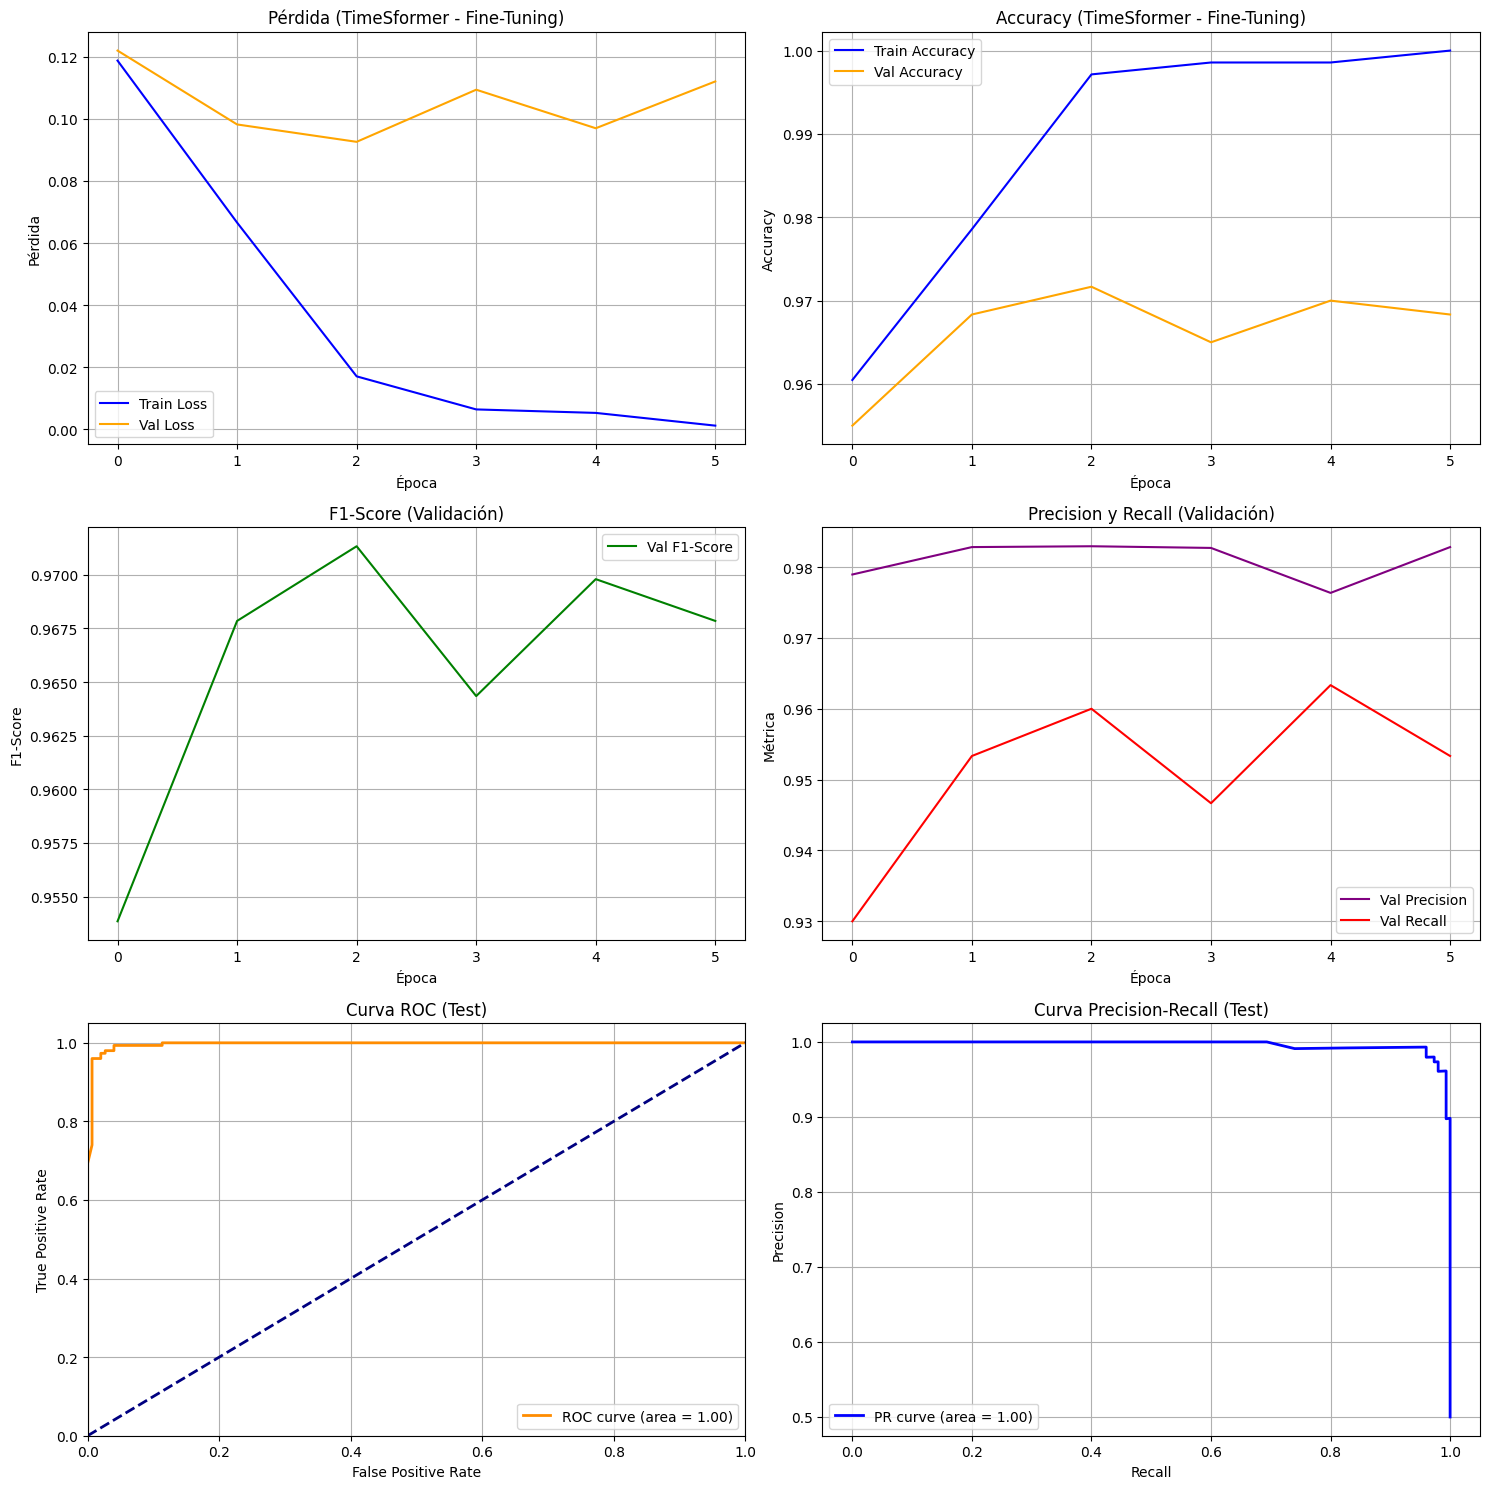

In [ ]:
import os
import logging
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Configurar logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler("diagnostics.log"),
        logging.StreamHandler()
    ]
)

# Definir rutas
BASE_PATH = "/content/drive/MyDrive/Proyecto IA-3/violence_school_project/"
MODEL_PATH = os.path.join(BASE_PATH, "models/timesformer")
RUN_PATH = os.path.join(MODEL_PATH, "run_finetune_20250408_003512")

# Cargar métricas
metrics_path = os.path.join(RUN_PATH, "timesformer_finetune_metrics.pkl")
if not os.path.exists(metrics_path):
    raise FileNotFoundError(f"No se encontró el archivo de métricas: {metrics_path}")

with open(metrics_path, "rb") as f:
    metrics = pickle.load(f)

train_metrics = metrics["train_metrics"]
val_metrics = metrics["val_metrics"]
test_loss = metrics["test_loss"]
test_accuracy = metrics["test_accuracy"]
test_precision = metrics["test_precision"]
test_recall = metrics["test_recall"]
test_f1 = metrics["test_f1"]
test_preds = metrics["test_preds"]
test_labels = metrics["test_labels"]

# Gráficas
plt.figure(figsize=(15, 15))

# Pérdida
plt.subplot(3, 2, 1)
plt.plot(train_metrics["losses"], label="Train Loss", color="blue")
plt.plot(val_metrics["losses"], label="Val Loss", color="orange")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Pérdida (TimeSformer - Fine-Tuning)")
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(3, 2, 2)
plt.plot(train_metrics["accuracies"], label="Train Accuracy", color="blue")
plt.plot(val_metrics["accuracies"], label="Val Accuracy", color="orange")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.title("Accuracy (TimeSformer - Fine-Tuning)")
plt.legend()
plt.grid(True)

# F1-Score (validación)
plt.subplot(3, 2, 3)
plt.plot(val_metrics["f1_scores"], label="Val F1-Score", color="green")
plt.xlabel("Época")
plt.ylabel("F1-Score")
plt.title("F1-Score (Validación)")
plt.legend()
plt.grid(True)

# Precision y Recall (validación)
plt.subplot(3, 2, 4)
plt.plot(val_metrics["precisions"], label="Val Precision", color="purple")
plt.plot(val_metrics["recalls"], label="Val Recall", color="red")
plt.xlabel("Época")
plt.ylabel("Métrica")
plt.title("Precision y Recall (Validación)")
plt.legend()
plt.grid(True)

# Curva ROC (test)
fpr, tpr, _ = roc_curve(test_labels, test_preds)
roc_auc = auc(fpr, tpr)
plt.subplot(3, 2, 5)
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC (Test)")
plt.legend(loc="lower right")
plt.grid(True)

# Curva Precision-Recall (test)
precision, recall, _ = precision_recall_curve(test_labels, test_preds)
pr_auc = auc(recall, precision)
plt.subplot(3, 2, 6)
plt.plot(recall, precision, color="blue", lw=2, label=f"PR curve (area = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall (Test)")
plt.legend(loc="lower left")
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(RUN_PATH, "timesformer_finetune_diagnostics.png"))
logging.info(f"Gráficas guardadas en: {os.path.join(RUN_PATH, 'timesformer_finetune_diagnostics.png')}")

# Diagnóstico
if val_metrics["accuracies"][-1] < 0.7:
    logging.warning("Subajuste: Accuracy en validación es bajo (<0.7). Considerar aumentar capacidad (descongelar más capas), más épocas, o revisar el dataset.")
elif val_metrics["accuracies"][-1] < train_metrics["accuracies"][-1] - 0.1:
    logging.warning("Sobreajuste: Diferencia significativa entre train y val accuracy (>0.1). Considerar regularización (aumentar weight decay), más datos, o data augmentation.")
else:
    logging.info("Rendimiento aceptable en términos de accuracy.")

if val_metrics["f1_scores"][-1] < 0.8:
    logging.info("F1-score en validación es bajo (<0.8). Se recomienda proceder con fine-tuning, descongelando algunas capas del modelo (por ejemplo, las últimas capas de atención).")
else:
    logging.info("F1-score en validación es aceptable (>=0.8). El modelo puede usarse directamente, pero fine-tuning podría mejorar aún más el rendimiento.")

logging.info(f"Resultados finales en test: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-Score: {test_f1:.4f}")

# PRUEBAS

In [ ]:
# import os
# import logging
# import torch
# import numpy as np
# from transformers import TimesformerForVideoClassification, AutoImageProcessor
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# from tqdm import tqdm
# import cv2

# Configurar logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler("test_new_data.log"),
        logging.StreamHandler()
    ]
)

# Definir rutas
BASE_PATH = "/content/drive/MyDrive/Proyecto IA-3/violence_school_project/"
MODEL_PATH = os.path.join(BASE_PATH, "models/timesformer")
RUN_PATH = os.path.join(MODEL_PATH, "run_finetune_20250408_003512")
BEST_MODEL_PATH = os.path.join(RUN_PATH, "best_timesformer_finetune.pt")
NEW_DATA_PATH = os.path.join(BASE_PATH, "new_test_data/")  # Carpeta con nuevos videos

# Verificar que el modelo exista
if not os.path.exists(BEST_MODEL_PATH):
    raise FileNotFoundError(f"No se encontró el modelo en: {BEST_MODEL_PATH}")

# Configurar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Usando dispositivo: {device}")

# Cargar el modelo
model_pred = TimesformerForVideoClassification.from_pretrained(BEST_MODEL_PATH)
model_pred.to(device)
model_pred.eval()
logging.info(f"Modelo cargado desde: {BEST_MODEL_PATH}")

# Cargar el procesador de imágenes
processor = AutoImageProcessor.from_pretrained("facebook/timesformer-base-finetuned-k400")

# Función para redimensionar un frame manteniendo la relación de aspecto
def resize_frame(frame, target_size=(224, 224)):
    h, w = frame.shape[:2]
    target_h, target_w = target_size

    # Calcular la relación de aspecto
    ratio = min(target_w / w, target_h / h)
    new_w, new_h = int(w * ratio), int(h * ratio)

    # Redimensionar manteniendo la relación de aspecto
    resized_frame = cv2.resize(frame, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Crear un fondo negro de tamaño objetivo
    padded_frame = np.zeros((target_h, target_w, 3), dtype=np.uint8)

    # Calcular el padding para centrar la imagen
    pad_top = (target_h - new_h) // 2
    pad_left = (target_w - new_w) // 2

    # Colocar la imagen redimensionada en el centro
    padded_frame[pad_top:pad_top + new_h, pad_left:pad_left + new_w] = resized_frame
    return padded_frame

# Función para preprocesar un video
def preprocess_video(video_path, num_frames=8, target_size=(224, 224)):
    # Cargar el video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"No se pudo abrir el video: {video_path}")

    # Obtener el número total de frames
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames < num_frames:
        raise ValueError(f"El video {video_path} tiene menos de {num_frames} frames")

    # Muestrear frames uniformemente
    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    frames = []
    valid_frame_count = 0
    frame_idx = 0

    # Intentar leer frames hasta obtener los 8 necesarios
    while valid_frame_count < num_frames and frame_idx < total_frames:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if not ret:
            logging.warning(f"No se pudo leer el frame {frame_idx} del video {video_path}. Intentando con el siguiente frame.")
            frame_idx += 1
            continue

        # Convertir de BGR a RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Redimensionar el frame manteniendo la relación de aspecto
        frame = resize_frame(frame, target_size)

        frames.append(frame)
        valid_frame_count += 1
        frame_idx += max(1, (total_frames - frame_idx) // (num_frames - valid_frame_count + 1))

    cap.release()

    # Verificar que se hayan obtenido suficientes frames
    if valid_frame_count < num_frames:
        raise ValueError(f"No se pudieron obtener {num_frames} frames válidos del video {video_path}. Solo se obtuvieron {valid_frame_count} frames.")

    # Preprocesar los frames con AutoImageProcessor
    inputs = processor(frames, return_tensors="pt")
    pixel_values = inputs["pixel_values"]  # (1, T, C, H, W)
    return pixel_values

# Lista para almacenar resultados
predictions = []
probabilities = []
true_labels = []  # Solo si los nuevos datos tienen etiquetas

# Umbral para clasificación binaria
THRESHOLD = 0.5

# Procesar nuevos videos
new_videos = [f for f in os.listdir(NEW_DATA_PATH) if f.endswith((".mp4", ".avi", ".mov"))]
if not new_videos:
    raise ValueError(f"No se encontraron videos en: {NEW_DATA_PATH}")

logging.info(f"Se encontraron {len(new_videos)} videos para probar.")

for video_file in tqdm(new_videos, desc="Procesando nuevos videos"):
    video_path = os.path.join(NEW_DATA_PATH, video_file)
    try:
        # Preprocesar el video
        pixel_values = preprocess_video(video_path)
        pixel_values = pixel_values.to(device)

        # Realizar predicción
        with torch.no_grad():
            outputs = model_pred(pixel_values=pixel_values)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)
            prob_violence = probs[0, 1].item()  # Probabilidad de la clase "violencia"
            pred = 1 if prob_violence > THRESHOLD else 0  # Predicción binaria

        # Almacenar resultados
        predictions.append(pred)
        probabilities.append(prob_violence)

        # Si el nombre del archivo indica la etiqueta real (por ejemplo, "violencia_001.mp4" o "no_violencia_001.mp4")
        if "violencia" in video_file.lower():
            true_labels.append(1)
        elif "no_violencia" in video_file.lower():
            true_labels.append(0)
        else:
            true_labels.append(None)  # Etiqueta desconocida

        logging.info(f"Video: {video_file}, Predicción: {'Violencia' if pred == 1 else 'No Violencia'}, Probabilidad (violencia): {prob_violence:.4f}")

    except Exception as e:
        logging.error(f"Error al procesar el video {video_file}: {str(e)}")
        continue

# Analizar resultados
if all(label is not None for label in true_labels):
    # Calcular métricas si tenemos etiquetas reales
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average="binary")
    recall = recall_score(true_labels, predictions, average="binary")
    f1 = f1_score(true_labels, predictions, average="binary")

    logging.info("Resultados con nuevos datos (con etiquetas reales):")
    logging.info(f"Accuracy: {accuracy:.4f}")
    logging.info(f"Precision: {precision:.4f}")
    logging.info(f"Recall: {recall:.4f}")
    logging.info(f"F1-Score: {f1:.4f}")
else:
    # Análisis cualitativo si no tenemos etiquetas reales
    logging.info("Resultados con nuevos datos (sin etiquetas reales):")
    for video_file, pred, prob in zip(new_videos, predictions, probabilities):
        logging.info(f"Video: {video_file}, Predicción: {'Violencia' if pred == 1 else 'No Violencia'}, Probabilidad (violencia): {prob:.4f}")

# Guardar resultados en un archivo
results_path = os.path.join(RUN_PATH, "new_data_test_results.txt")
with open(results_path, "w") as f:
    f.write("Resultados de Pruebas con Nuevos Datos\n")
    f.write("=" * 40 + "\n\n")
    if all(label is not None for label in true_labels):
        f.write(f"Accuracy: {accuracy:.4f}\n")
        f.write(f"Precision: {precision:.4f}\n")
        f.write(f"Recall: {recall:.4f}\n")
        f.write(f"F1-Score: {f1:.4f}\n\n")
    f.write("Predicciones por Video:\n")
    for video_file, pred, prob in zip(new_videos, predictions, probabilities):
        f.write(f"Video: {video_file}, Predicción: {'Violencia' if pred == 1 else 'No Violencia'}, Probabilidad (violencia): {prob:.4f}\n")
logging.info(f"Resultados guardados en: {results_path}")

Procesando nuevos videos: 100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


# PREUBAS DE CERO

In [ ]:
!pip install transformers torch opencv-python numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
from google.colab import drive
drive.flush_and_unmount()

# Montar Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import logging
import torch
import numpy as np
import cv2
from transformers import TimesformerForVideoClassification, AutoImageProcessor
from datetime import datetime

# Configurar logging para mostrar solo en la consola
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.StreamHandler()  # Solo muestra en la consola
    ]
)

# Definir rutas
BASE_PATH = "/content/drive/MyDrive/Proyecto IA-3/violence_school_project/"
MODEL_PATH = os.path.join(BASE_PATH, "models/timesformer/run_finetune_20250408_003512/best_timesformer_finetune.pt")
VIDEO_PATH = os.path.join(BASE_PATH, "videos/videos_procesados/video_prueba3.mp4")  # Video crudo de entrada

# Verificar que el modelo exista
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"No se encontró el modelo TimeSformer en: {MODEL_PATH}")

# Verificar que el video exista
if not os.path.exists(VIDEO_PATH):
    raise FileNotFoundError(f"No se encontró el video en: {VIDEO_PATH}")

# Configurar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Usando dispositivo: {device}")

# Cargar el modelo TimeSformer
model = TimesformerForVideoClassification.from_pretrained(MODEL_PATH)
model.to(device)
model.eval()
logging.info(f"Modelo TimeSformer cargado desde: {MODEL_PATH}")

# Cargar el procesador de imágenes
processor = AutoImageProcessor.from_pretrained("facebook/timesformer-base-finetuned-k400")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/412 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
VIDEO_PATH = os.path.join(BASE_PATH, "videos/videos_procesados/videos_input.mp4")  # Video crudo de entrada

In [ ]:

# Parámetros
TARGET_SIZE = (224, 224)  # Resolución esperada por TimeSformer
TARGET_FPS = 15  # FPS esperados por TimeSformer
NUM_FRAMES = 8  # Número de frames que espera TimeSformer
THRESHOLD_VIOLENCE = 0.5  # Umbral para clasificar como violencia

# Función para obtener información del video
def get_video_info(video_path):
    video = cv2.VideoCapture(video_path)
    if not video.isOpened():
        raise ValueError(f"No se pudo abrir el video: {video_path}")

    fps = video.get(cv2.CAP_PROP_FPS)
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count / fps if fps > 0 else 0
    video.release()
    return {"fps": fps, "frame_count": frame_count, "duration": duration}

# Función para preprocesar el video crudo
def preprocess_raw_video(video_path, num_frames=NUM_FRAMES, target_size=TARGET_SIZE, target_fps=TARGET_FPS):
    # Cargar el video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"No se pudo abrir el video: {video_path}")

    # Obtener información del video
    video_info = get_video_info(video_path)
    original_fps = video_info["fps"]
    total_frames = video_info["frame_count"]
    logging.info(f"Video: {video_path}, FPS original: {original_fps}, Total frames: {total_frames}")

    # Ajustar FPS: calcular cuántos frames corresponden a 15 FPS
    target_frame_count = int((total_frames / original_fps) * target_fps)
    if target_frame_count < num_frames:
        raise ValueError(f"El video es demasiado corto para muestrear {num_frames} frames a {target_fps} FPS. Frames disponibles: {target_frame_count}")

    # Muestrear frames para reducir a 15 FPS
    frame_indices = np.linspace(0, total_frames - 1, target_frame_count, dtype=int)
    frames = []
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            logging.warning(f"No se pudo leer el frame {idx}. Saltando...")
            continue
        frames.append(frame)

    # Verificar que tenemos suficientes frames después de ajustar FPS
    if len(frames) < num_frames:
        cap.release()
        raise ValueError(f"No se pudieron obtener suficientes frames después de ajustar FPS. Frames obtenidos: {len(frames)}")

    # Muestrear 8 frames uniformemente de los frames ajustados
    sample_indices = np.linspace(0, len(frames) - 1, num_frames, dtype=int)
    selected_frames = [frames[i] for i in sample_indices]

    # Redimensionar y convertir a RGB
    processed_frames = []
    for frame in selected_frames:
        # Convertir de BGR a RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Redimensionar manteniendo la relación de aspecto
        h, w = frame.shape[:2]
        ratio = min(target_size[0] / w, target_size[1] / h)
        new_w, new_h = int(w * ratio), int(h * ratio)
        resized_frame = cv2.resize(frame, (new_w, new_h), interpolation=cv2.INTER_AREA)

        # Crear un fondo negro de tamaño objetivo y centrar la imagen
        padded_frame = np.zeros((target_size[1], target_size[0], 3), dtype=np.uint8)
        pad_top = (target_size[1] - new_h) // 2
        pad_left = (target_size[0] - new_w) // 2
        padded_frame[pad_top:pad_top + new_h, pad_left:pad_left + new_w] = resized_frame

        processed_frames.append(padded_frame)

    cap.release()

    # Preprocesar con AutoImageProcessor
    inputs = processor(processed_frames, return_tensors="pt")
    pixel_values = inputs["pixel_values"].to(device)  # (1, T, C, H, W)
    return pixel_values

# Función para predecir violencia
def predict_violence(video_path):
    try:
        # Preprocesar el video
        pixel_values = preprocess_raw_video(video_path)

        # Realizar predicción
        with torch.no_grad():
            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)
            prob_violence = probs[0, 1].item()  # Probabilidad de la clase "violencia"
            pred = 1 if prob_violence > THRESHOLD_VIOLENCE else 0  # Predicción binaria

        return pred, prob_violence

    except Exception as e:
        logging.error(f"Error al predecir violencia en el video {video_path}: {str(e)}")
        raise

# Realizar la predicción
logging.info(f"Procesando video: {VIDEO_PATH}")
try:
    pred, prob_violence = predict_violence(VIDEO_PATH)
    result = "Violencia" if pred == 1 else "No Violencia"
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"\n=== Resultado de la Predicción ===")
    print(f"Video: {os.path.basename(VIDEO_PATH)}")
    print(f"Predicción: {result}")
    print(f"Probabilidad de violencia: {prob_violence:.4f}")
    print(f"Timestamp: {timestamp}\n")

except Exception as e:
    logging.error(f"No se pudo completar la predicción: {str(e)}")
    print(f"No se pudo completar la predicción: {str(e)}")


=== Resultado de la Predicción ===
Video: videos_input.mp4
Predicción: Violencia
Probabilidad de violencia: 0.9879
Timestamp: 2025-04-09 00:37:36



# EXPORTAR EL MODELO EN ONNX

In [ ]:
!pip install transformers torch torchvision numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 72.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.onnx
from transformers import TimesformerForVideoClassification

# Cargar el modelo desde el directorio que contiene model.safetensors
model_dir = "/content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_finetune_20250408_003512/final_timesformer_finetune.pt"
model = TimesformerForVideoClassification.from_pretrained(model_dir)

# Mover el modelo a evaluación y al dispositivo adecuado
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()
model.to(device)

# Crear un ejemplo de entrada
dummy_input = torch.randn(1, 8, 3, 224, 224).to(device)

# Exportar a ONNX
torch.onnx.export(
    model,
    dummy_input,
    "timesformer_finetunedV2.onnx",
    input_names=["pixel_values"],
    output_names=["logits"],
    dynamic_axes={"pixel_values": {0: "batch_size"}, "logits": {0: "batch_size"}},
    opset_version=12
)


In [ ]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.7 MB/s eta 0:00:00


In [ ]:
# Verificar la exportación
import onnxruntime as ort
import numpy as np

session = ort.InferenceSession("timesformer_finetunedV2.onnx")
dummy_input_np = dummy_input.cpu().numpy()
outputs = session.run(None, {"pixel_values": dummy_input_np})[0]
print("Logits de salida:", outputs)

Logits de salida: [[ 3.5753365 -4.170919 ]]


In [ ]:
import torch
import torch.onnx
from transformers import TimesformerForVideoClassification

# Cargar el modelo desde el directorio que contiene model.safetensors
model_dir = "/content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_finetune_20250408_003512/best_timesformer_finetune.pt"
model = TimesformerForVideoClassification.from_pretrained(model_dir)

# Mover el modelo a evaluación y al dispositivo adecuado
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()
model.to(device)

# Crear un ejemplo de entrada
dummy_input = torch.randn(1, 8, 3, 224, 224).to(device)

# Definir el directorio y la ruta de salida en Google Drive
output_dir = "/content/drive/MyDrive/Proyecto IA-3/violence_school_project/models/timesformer/run_finetune_20250408_003512/"
output_path = f"{output_dir}/timesformer_finetuned.onnx"

# Exportar a ONNX
torch.onnx.export(
    model,
    dummy_input,
    output_path,  # Usar la ruta completa con el directorio
    input_names=["pixel_values"],
    output_names=["logits"],
    dynamic_axes={"pixel_values": {0: "batch_size"}, "logits": {0: "batch_size"}},
    opset_version=12
)

print(f"Modelo exportado y guardado en: {output_path}")

# CONCLUSIONES